In [1]:
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
# from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model
# Relevant libraries and functions
from __future__ import print_function
import random
import matplotlib.pyplot as plt
import scipy.ndimage
import numpy as np, h5py
import numpy.ma as npm
import os, time, sys
import tensorflow as tf
import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Convolution2D, Input, SpatialDropout2D, UpSampling2D, MaxPooling2D, concatenate
from tensorflow.keras.layers import Activation, Conv2DTranspose
from tensorflow.keras.layers import Layer
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Input, Conv2D, add, Conv3D, Reshape,Conv3DTranspose
from tensorflow.keras.callbacks import History, EarlyStopping, ModelCheckpoint, CSVLogger
from itertools import cycle
from sklearn import metrics
from tensorflow.keras.optimizers import RMSprop
from keras.utils import np_utils
from tensorflow.keras import backend
# from keras.backend.tensorflow_backend import set_session
from tensorflow.python.keras.backend import set_session
from keras.layers.convolutional import Convolution2D, MaxPooling2D, SeparableConv2D, Conv2DTranspose
from sklearn.utils import shuffle
import math 
from keras.utils import plot_model
import graphviz

C:\Users\Walshlab\AppData\Roaming\Python\Python38\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

if tf.test.gpu_device_name(): 

    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:
    print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


#### Define discriminator

In [5]:
### Test 3D discriminator

def define_discriminator(image_shape):
    
    # weight initialization
    
    # source image input
    in_src_image = Input(shape=image_shape)  #Image we want to convert to another image
    # target image input
    in_target_image = Input(shape=image_shape)  #Image we want to generate after training. 
    
    # concatenate images, channel-wise
    merged = Concatenate()([in_src_image, in_target_image])
    
    d = Conv3D(filters=128, kernel_size=(4,4,16), strides=(2,2,16), padding='same', activation=None)(merged)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Dropout(0.3)(d)
    
    d = Conv3D(filters=32, kernel_size=(2,2,8),strides=(2,2,4), padding='same', activation=None)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Dropout(0.3)(d)
    
    d = Conv3D(filters=16, kernel_size=(2,2,4),strides=(1,1,2), padding='same', activation=None)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Dropout(0.3)(d)
    
#     d = layers.GlobalAveragePooling3D()(d)
    
    d = Dense(units = 32, activation="relu")(d)
    d = Dense(units = 16, activation="relu")(d)
    d = Dense(units = 8, activation="relu")(d)
    

    
    
    patch_out = Dense(units=1, activation="sigmoid")(d)
#     patch_out = Dense(units=2)(d)
    # define model
    model = Model([in_src_image, in_target_image], patch_out)
    # compile model
    #The model is trained with a batch size of one image and Adam opt. 
    #with a small learning rate and 0.5 beta. 
    #The loss for the discriminator is weighted by 50% for each model update.
    model.summary(line_length = 120)
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])

    return model

In [6]:
d_model = define_discriminator((32,32,256,1))
# plot_model(disc_model, to_file='disc_model.png', show_shapes=True)

Model: "model_1"
________________________________________________________________________________________________________________________
 Layer (type)                          Output Shape               Param #       Connected to                            
 input_3 (InputLayer)                  [(None, 32, 32, 256, 1)]   0             []                                      
                                                                                                                        
 input_4 (InputLayer)                  [(None, 32, 32, 256, 1)]   0             []                                      
                                                                                                                        
 concatenate_1 (Concatenate)           (None, 32, 32, 256, 2)     0             ['input_3[0][0]',                       
                                                                                 'input_4[0][0]']                       
               

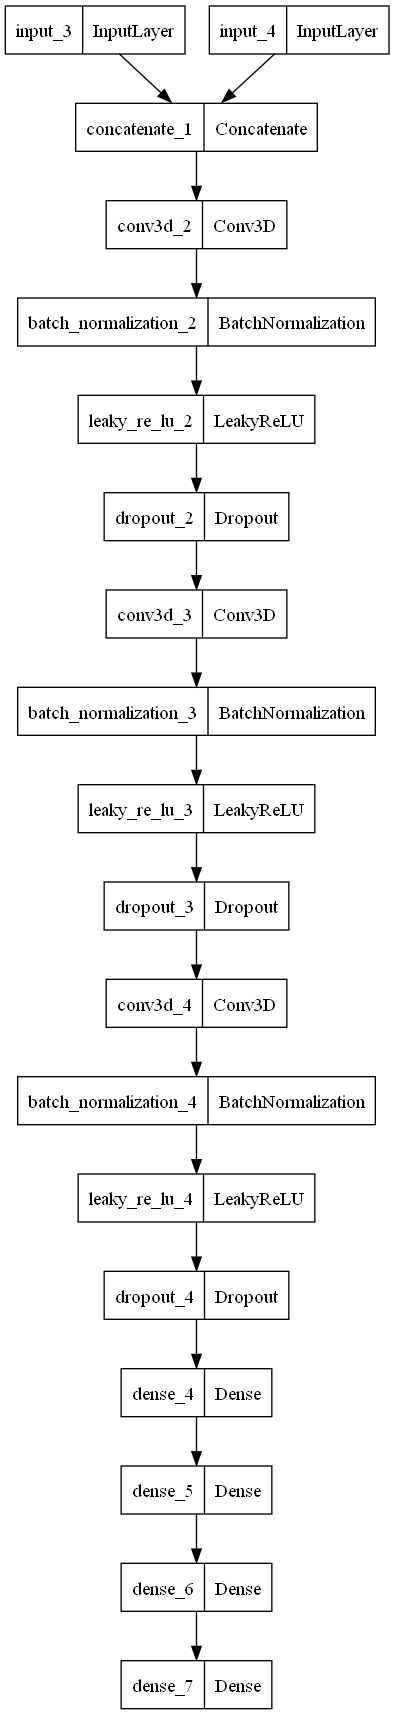

In [7]:
plot_model(d_model, to_file='D_Model_plot.png')

#### Define generator

In [8]:
##############################
#Now define the generator - in our case we will define a U-net
# define an encoder block to be used in generator
def define_encoder_block1(layer_in, n_filters, batchnorm=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add downsampling layer
    g = Conv3D(n_filters, (2,2,16), strides=(2,2,2), padding='same', kernel_initializer=init)(layer_in)
    # conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g

In [9]:
##############################
#Now define the generator - in our case we will define a U-net
# define an encoder block to be used in generator
def define_encoder_block2(layer_in, n_filters, batchnorm=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add downsampling layer
    g = Conv3D(n_filters, (2,2,4), strides=(2,2,2), padding='same', kernel_initializer=init)(layer_in)
    # conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g

In [10]:
def define_encoder_block(layer_in, n_filters, batchnorm=True, kernelSize = (2,2,4),strides=(2,2,2)):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add downsampling layer
    g = Conv3D(n_filters, kernelSize, strides, padding='same', kernel_initializer=init)(layer_in)
    # conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g

In [11]:
# define a decoder block to be used in generator
def decoder_block1(layer_in, skip_in, n_filters, dropout=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add upsampling layer
    g = Conv3DTranspose(n_filters, (2,2,16), strides=(2,2,2), padding='same', kernel_initializer=init)(layer_in)
    # add batch normalization
    g = BatchNormalization()(g, training=True)
    # conditionally add dropout
    if dropout:
        g = Dropout(0.5)(g, training=True)
    # merge with skip connection
    g = Concatenate()([g, skip_in])
    # relu activation
    g = Activation('relu')(g)
    return g

In [12]:
def decoder_block2(layer_in, skip_in, n_filters, dropout=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add upsampling layer
    g = Conv3DTranspose(n_filters, (2,2,4), strides=(2,2,2), padding='same', kernel_initializer=init)(layer_in)
    # add batch normalization
    g = BatchNormalization()(g, training=True)
    # conditionally add dropout
    if dropout:
        g = Dropout(0.5)(g, training=True)
    # merge with skip connection
    g = Concatenate()([g, skip_in])
    # relu activation
    g = Activation('relu')(g)
    return g

In [13]:
#### Previous Version
# Input shape = 32 x 32 x 256
# Four encoder and decoder blocks
def define_generator(image_shape=(32,32,256,1)):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=image_shape)
    
    e1 = define_encoder_block2(in_image, 16, batchnorm=True)
    e2 = define_encoder_block2(e1, 32)
    e3 = define_encoder_block1(e2, 64)
    e4 = define_encoder_block1(e3, 128)
    
    b = Conv3D(64, (4,4,8), strides = (2,2,2), padding='same', kernel_initializer=init)(e4)
    b = Activation('relu')(b)
    
    
    d1 = decoder_block1(b, e4, 128)
    d2 = decoder_block1(d1, e3, 64, dropout=False)
    d3 = decoder_block2(d2, e2, 32, dropout=False)
    d4 = decoder_block2(d3, e1, 16, dropout=False)
    
    
    g = Conv3DTranspose(image_shape[2], (4,4,8), strides=(2,2,2), padding='same', kernel_initializer=init)(d4)
    g = Dense(64)(g)
    g = Dense(32)(g)
    g = Dense(16)(g)
    g = Dense(1)(g)
    
    
    out_image = Activation('tanh')(g)
    model = Model(in_image, out_image)
    model.summary(line_length = 120)
    return model

In [14]:
g_model = define_generator((32,32,256,1))

Model: "model_2"
________________________________________________________________________________________________________________________
 Layer (type)                          Output Shape               Param #       Connected to                            
 input_5 (InputLayer)                  [(None, 32, 32, 256, 1)]   0             []                                      
                                                                                                                        
 conv3d_5 (Conv3D)                     (None, 16, 16, 128, 16)    272           ['input_5[0][0]']                       
                                                                                                                        
 batch_normalization_5 (BatchNormaliza  (None, 16, 16, 128, 16)   64            ['conv3d_5[0][0]']                      
 tion)                                                                                                                  
               

                                                                                                                        
 conv3d_transpose_3 (Conv3DTranspose)  (None, 16, 16, 128, 16)    16400         ['activation_3[0][0]']                  
                                                                                                                        
 batch_normalization_12 (BatchNormaliz  (None, 16, 16, 128, 16)   64            ['conv3d_transpose_3[0][0]']            
 ation)                                                                                                                 
                                                                                                                        
 concatenate_5 (Concatenate)           (None, 16, 16, 128, 32)    0             ['batch_normalization_12[0][0]',        
                                                                                 'leaky_re_lu_5[0][0]']                 
                                

#### Define Gan

In [15]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape=(32,32,256,1)):
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False       #Descriminator layers set to untrainable in the combined GAN but 
                                                #standalone descriminator will be trainable.
            
    # define the source image
    in_src = Input(shape=image_shape)
    # suppy the image as input to the generator 
    gen_out = g_model(in_src)
    # supply the input image and generated image as inputs to the discriminator
    dis_out = d_model([in_src, gen_out])
    # src image as input, generated image and disc. output as outputs
    model = Model(in_src, [dis_out, gen_out])
    # compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    
    #Total loss is the weighted sum of adversarial loss (BCE) and L1 loss (MAE)
    #Authors suggested weighting BCE vs L1 as 1:100.
    model.compile(loss=['binary_crossentropy', 'mae'], 
               optimizer=opt, loss_weights=[1,100])
    model.summary(line_length = 120)
    return model

In [16]:
gan_model = define_gan(g_model, d_model)

Model: "model_3"
________________________________________________________________________________________________________________________
 Layer (type)                          Output Shape               Param #       Connected to                            
 input_6 (InputLayer)                  [(None, 32, 32, 256, 1)]   0             []                                      
                                                                                                                        
 model_2 (Functional)                  (None, 32, 32, 256, 1)     4437537       ['input_6[0][0]']                       
                                                                                                                        
 model_1 (Functional)                  (None, 8, 8, 2, 1)         206897        ['input_6[0][0]',                       
                                                                                 'model_2[0][0]']                       
               

#### Read the images

In [17]:
dataDirectory = 'E:\\Linghao Hu\\FLIM Enhan\\New Dataset\\Simulate_Dataset'  # Directory with trainging data
imageNumber = 3000
imageStacks = os.listdir(dataDirectory)[:imageNumber]
stackNumber = int(len(imageStacks))

timePointNumber = 256 # Number of time-points
width = 28
height = 28



# Build the stack for each endpoint tpsfH, tpsfL, t1, t2, a1, a2

tpsfHImageStack = np.ndarray((stackNumber, int(timePointNumber), int(width), int(height), int(1)), dtype=np.float32)
tpsfLImageStack = np.ndarray((stackNumber, int(timePointNumber), int(width), int(height), int(1)), dtype=np.float32)

i = 0;

for d in imageStacks:
    # Save values to respective stack
    data = h5py.File(os.path.join(dataDirectory,d),'r')
    tpsfHImageStack[i,:,:,:,0] = data.get('hFLIM')
    tpsfLImageStack[i,:,:,:,0] = data.get('lFLIM')
    i = i + 1
    
# change the axis order of the stack 
tpsfHImageStack =  np.moveaxis(tpsfHImageStack, 1, -2)
tpsfLImageStack =  np.moveaxis(tpsfLImageStack, 1, -2)
 

In [18]:
tpsfHImageStack = np.squeeze(tpsfHImageStack)
tpsfLImageStack = np.squeeze(tpsfLImageStack)


def padTPSFImage(targetShape,inputImage):
    padding = [(0, targetShape[i] - inputImage.shape[i]) for i in range(len(targetShape))]
    paddedImage = np.pad(inputImage, padding, mode='constant')
    return paddedImage

padHImage = padTPSFImage((imageNumber,32,32,256),tpsfHImageStack)
padLImage = padTPSFImage((imageNumber,32,32,256),tpsfLImageStack)

#### Check the images

In [19]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def Montage_Image(imageList,n_col, image_size=28, margin=0):
    """
    Plot all the images listed in `img_names` in a gird with `n_col` columns.
    Images will be resized to `image_size`*`image_size`.
    This function assumes input images have the same shape.
    
    Args:
        img_names([string]): list of image paths
        n_col(int): number of images in one row
        image_size(int): the length of each image on the montage view
        margin(int): the horizonal and vertical gap between image image
        
    Returns:
        np.array: The montage view of all images listed in `img_names`
    """
    img_list = []
    for i in range(256):
        img_list.append(imageList[:,:,i])
    stack = np.hstack(img_list)

    # Compute number of rows
    n_row = math.ceil(256 / n_col)
    image = np.ones((n_row * image_size + (n_row - 1) * margin,
                     n_col * image_size + (n_col - 1) * margin)) * 255

    for i in range(int(stack.shape[1] / image_size)):
        r, c = i // n_col, i % n_col
        image[image_size * r + r * margin : image_size * (r + 1) + r * margin,
              image_size * c + c * margin : image_size * (c + 1) + c * margin
             ] = stack[:, image_size * i : image_size * (i + 1)]
        
    return image

In [20]:
def resize_image(image):
    image = image.reshape(32,32,256)
    montageImage = Montage_Image(image,32, image_size=32, margin= 0)
    return(montageImage)

In [21]:
montageHImage = resize_image(padHImage[0,:,:])
montageLImage = resize_image(padLImage[0,:,:])

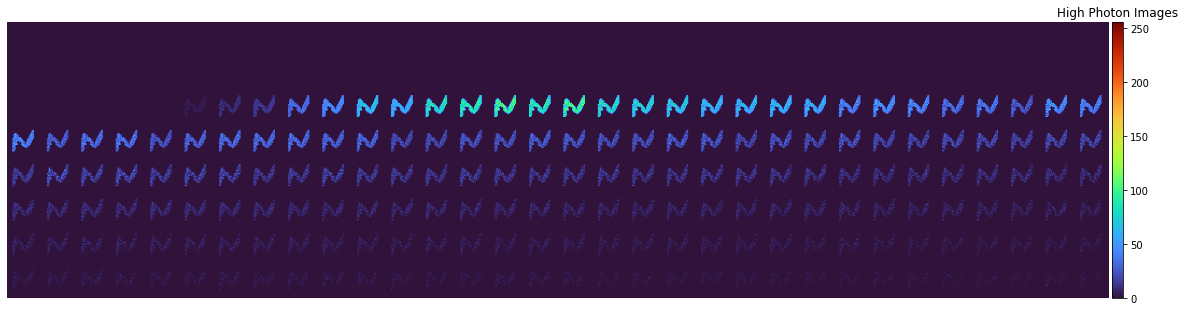

In [22]:
plt.figure(figsize=(20, round(montageHImage.shape[1] / montageHImage.shape[0] * 20)))
# plt.imshow(montageList, cmap='Blues',vmax =50)
plt.axis('off')
ax = plt.gca()
im = ax.imshow(montageHImage, cmap='turbo',vmax = 255)
    
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.05)
plt.title('High Photon Images')
plt.colorbar(im, cax=cax)
plt.show()

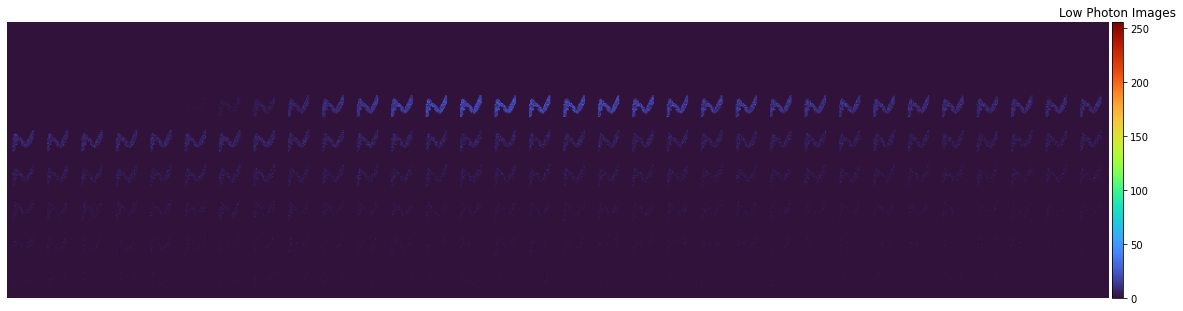

In [23]:
plt.figure(figsize=(20, round(montageLImage.shape[1] / montageLImage.shape[0] * 20)))
# plt.imshow(montageList, cmap='Blues',vmax =50)
plt.axis('off')
ax = plt.gca()
im = ax.imshow(montageLImage, cmap='turbo',vmax = 255)
    
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.05)
plt.title('Low Photon Images')
plt.colorbar(im, cax=cax)
plt.show()

#### Prepare for the images for training

In [24]:
# tpsfHImage = padHImage.reshape(1000,1024,256,1)
# tpsfLImage = padLImage.reshape(1000,1024,256,1)
# src_images = tpsfLImage
# tar_images = tpsfHImage
# padHImage = padHImage.reshape((imageNumber,32,32,256,1))
# padLImage = padLImage.reshape((imageNumber,32,32,256,1))

src_images = padLImage
tar_images = padHImage


data = [src_images, tar_images]

In [25]:
def preprocess_data(data):
    # load compressed arrays
    # unpack arrays
    X1, X2 = data[0], data[1]
    # scale from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]

dataset = preprocess_data(data)

In [26]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
    # unpack dataset
    trainA, trainB = dataset
    # choose random instances
    ix = randint(0, trainA.shape[0], n_samples)
    # retrieve selected images
    X1, X2 = trainA[ix], trainB[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, patch_shape, patch_shape, 2 , 1))
#     y = ones((n_samples, patch_shape))
    return [X1, X2], y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
    # generate fake instance
    X = g_model.predict(samples)
    # create 'fake' class labels (0)
    y = zeros((len(X), patch_shape, patch_shape, 2, 1))
#     y = zeros((len(X), patch_shape))
    return X, y

#### Train the model

In [27]:
# train pix2pix models
def train(d_model, g_model, gan_model, dataset, n_epochs=10, n_batch=1):
    # determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]
    # unpack dataset
    trainA, trainB = dataset
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # manually enumerate epochs
    for i in range(n_steps):
        # select a batch of real samples
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
        # generate a batch of fake samples
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
        # update discriminator for real samples
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        # update discriminator for generated samples
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        # update the generator
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        # summarize performance
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
        # summarize model performance
# if (i+1) % (bat_per_epo * 10) == 0:
# summarize_performance(i, g_model, dataset)

In [28]:
train(d_model, g_model, gan_model, dataset, n_epochs=50, n_batch=10) 

1/1 [==============================] - 14s 14s/step
>1, d1[0.442] d2[0.273] g[100.589]
1/1 [==============================] - 0s 209ms/step
>2, d1[0.427] d2[0.276] g[53.363]
1/1 [==============================] - 0s 210ms/step
>3, d1[0.419] d2[0.283] g[23.913]
1/1 [==============================] - 0s 209ms/step
>4, d1[0.417] d2[0.291] g[11.120]
1/1 [==============================] - 0s 209ms/step
>5, d1[0.418] d2[0.293] g[6.513]
1/1 [==============================] - 0s 210ms/step
>6, d1[0.418] d2[0.292] g[4.788]
1/1 [==============================] - 0s 210ms/step
>7, d1[0.417] d2[0.294] g[3.970]
1/1 [==============================] - 0s 211ms/step
>8, d1[0.413] d2[0.291] g[3.450]
1/1 [==============================] - 0s 208ms/step
>9, d1[0.414] d2[0.293] g[3.240]
1/1 [==============================] - 0s 208ms/step
>10, d1[0.411] d2[0.295] g[2.967]
1/1 [==============================] - 0s 209ms/step
>11, d1[0.409] d2[0.296] g[2.900]
1/1 [==============================] - 0s 208ms/

1/1 [==============================] - 0s 213ms/step
>95, d1[0.378] d2[0.315] g[1.555]
1/1 [==============================] - 0s 211ms/step
>96, d1[0.377] d2[0.314] g[1.520]
1/1 [==============================] - 0s 212ms/step
>97, d1[0.378] d2[0.315] g[1.553]
1/1 [==============================] - 0s 213ms/step
>98, d1[0.374] d2[0.318] g[1.572]
1/1 [==============================] - 0s 213ms/step
>99, d1[0.377] d2[0.307] g[1.530]
1/1 [==============================] - 0s 211ms/step
>100, d1[0.377] d2[0.314] g[1.524]
1/1 [==============================] - 0s 212ms/step
>101, d1[0.372] d2[0.320] g[1.591]
1/1 [==============================] - 0s 213ms/step
>102, d1[0.375] d2[0.311] g[1.647]
1/1 [==============================] - 0s 211ms/step
>103, d1[0.373] d2[0.321] g[1.603]
1/1 [==============================] - 0s 212ms/step
>104, d1[0.376] d2[0.312] g[1.609]
1/1 [==============================] - 0s 214ms/step
>105, d1[0.376] d2[0.313] g[1.539]
1/1 [==============================] 

1/1 [==============================] - 0s 214ms/step
>188, d1[0.378] d2[0.297] g[1.473]
1/1 [==============================] - 0s 214ms/step
>189, d1[0.367] d2[0.328] g[1.422]
1/1 [==============================] - 0s 213ms/step
>190, d1[0.362] d2[0.328] g[1.502]
1/1 [==============================] - 0s 212ms/step
>191, d1[0.374] d2[0.332] g[1.404]
1/1 [==============================] - 0s 213ms/step
>192, d1[0.361] d2[0.338] g[1.374]
1/1 [==============================] - 0s 213ms/step
>193, d1[0.360] d2[0.335] g[1.295]
1/1 [==============================] - 0s 212ms/step
>194, d1[0.361] d2[0.338] g[1.403]
1/1 [==============================] - 0s 213ms/step
>195, d1[0.356] d2[0.339] g[1.375]
1/1 [==============================] - 0s 212ms/step
>196, d1[0.356] d2[0.340] g[1.330]
1/1 [==============================] - 0s 212ms/step
>197, d1[0.359] d2[0.332] g[1.375]
1/1 [==============================] - 0s 211ms/step
>198, d1[0.358] d2[0.339] g[1.398]
1/1 [===========================

1/1 [==============================] - 0s 212ms/step
>281, d1[0.354] d2[0.340] g[1.242]
1/1 [==============================] - 0s 212ms/step
>282, d1[0.356] d2[0.337] g[1.223]
1/1 [==============================] - 0s 211ms/step
>283, d1[0.355] d2[0.341] g[1.287]
1/1 [==============================] - 0s 212ms/step
>284, d1[0.352] d2[0.338] g[1.272]
1/1 [==============================] - 0s 212ms/step
>285, d1[0.353] d2[0.341] g[1.281]
1/1 [==============================] - 0s 213ms/step
>286, d1[0.355] d2[0.340] g[1.281]
1/1 [==============================] - 0s 218ms/step
>287, d1[0.353] d2[0.339] g[1.174]
1/1 [==============================] - 0s 214ms/step
>288, d1[0.356] d2[0.339] g[1.210]
1/1 [==============================] - 0s 217ms/step
>289, d1[0.353] d2[0.338] g[1.199]
1/1 [==============================] - 0s 221ms/step
>290, d1[0.354] d2[0.336] g[1.263]
1/1 [==============================] - 0s 211ms/step
>291, d1[0.357] d2[0.341] g[1.165]
1/1 [===========================

1/1 [==============================] - 0s 232ms/step
>374, d1[0.352] d2[0.337] g[1.243]
1/1 [==============================] - 0s 233ms/step
>375, d1[0.355] d2[0.342] g[1.199]
1/1 [==============================] - 0s 231ms/step
>376, d1[0.353] d2[0.333] g[1.353]
1/1 [==============================] - 0s 232ms/step
>377, d1[0.357] d2[0.343] g[1.376]
1/1 [==============================] - 0s 234ms/step
>378, d1[0.353] d2[0.336] g[1.324]
1/1 [==============================] - 0s 232ms/step
>379, d1[0.352] d2[0.342] g[1.194]
1/1 [==============================] - 0s 232ms/step
>380, d1[0.351] d2[0.342] g[1.223]
1/1 [==============================] - 0s 232ms/step
>381, d1[0.352] d2[0.337] g[1.188]
1/1 [==============================] - 0s 233ms/step
>382, d1[0.354] d2[0.343] g[1.175]
1/1 [==============================] - 0s 233ms/step
>383, d1[0.351] d2[0.336] g[1.300]
1/1 [==============================] - 0s 233ms/step
>384, d1[0.352] d2[0.344] g[1.221]
1/1 [===========================

1/1 [==============================] - 0s 222ms/step
>467, d1[0.351] d2[0.341] g[1.175]
1/1 [==============================] - 0s 212ms/step
>468, d1[0.351] d2[0.341] g[1.196]
1/1 [==============================] - 0s 214ms/step
>469, d1[0.351] d2[0.341] g[1.201]
1/1 [==============================] - 0s 216ms/step
>470, d1[0.351] d2[0.341] g[1.138]
1/1 [==============================] - 0s 211ms/step
>471, d1[0.352] d2[0.340] g[1.157]
1/1 [==============================] - 0s 216ms/step
>472, d1[0.353] d2[0.341] g[1.133]
1/1 [==============================] - 0s 220ms/step
>473, d1[0.352] d2[0.339] g[1.138]
1/1 [==============================] - 0s 212ms/step
>474, d1[0.354] d2[0.342] g[1.146]
1/1 [==============================] - 0s 220ms/step
>475, d1[0.352] d2[0.340] g[1.130]
1/1 [==============================] - 0s 216ms/step
>476, d1[0.353] d2[0.340] g[1.138]
1/1 [==============================] - 0s 222ms/step
>477, d1[0.353] d2[0.340] g[1.131]
1/1 [===========================

1/1 [==============================] - 0s 218ms/step
>560, d1[0.352] d2[0.344] g[1.225]
1/1 [==============================] - 0s 233ms/step
>561, d1[0.348] d2[0.333] g[1.226]
1/1 [==============================] - 0s 233ms/step
>562, d1[0.352] d2[0.344] g[1.112]
1/1 [==============================] - 0s 226ms/step
>563, d1[0.351] d2[0.345] g[1.104]
1/1 [==============================] - 0s 233ms/step
>564, d1[0.350] d2[0.342] g[1.132]
1/1 [==============================] - 0s 221ms/step
>565, d1[0.348] d2[0.343] g[1.140]
1/1 [==============================] - 0s 224ms/step
>566, d1[0.350] d2[0.341] g[1.116]
1/1 [==============================] - 0s 223ms/step
>567, d1[0.350] d2[0.340] g[1.146]
1/1 [==============================] - 0s 218ms/step
>568, d1[0.350] d2[0.344] g[1.128]
1/1 [==============================] - 0s 227ms/step
>569, d1[0.348] d2[0.335] g[1.232]
1/1 [==============================] - 0s 226ms/step
>570, d1[0.360] d2[0.343] g[1.171]
1/1 [===========================

1/1 [==============================] - 0s 214ms/step
>653, d1[0.351] d2[0.340] g[1.075]
1/1 [==============================] - 0s 214ms/step
>654, d1[0.349] d2[0.335] g[1.188]
1/1 [==============================] - 0s 215ms/step
>655, d1[0.353] d2[0.341] g[1.220]
1/1 [==============================] - 0s 214ms/step
>656, d1[0.349] d2[0.334] g[1.171]
1/1 [==============================] - 0s 214ms/step
>657, d1[0.354] d2[0.341] g[1.134]
1/1 [==============================] - 0s 214ms/step
>658, d1[0.349] d2[0.342] g[1.132]
1/1 [==============================] - 0s 215ms/step
>659, d1[0.352] d2[0.332] g[1.143]
1/1 [==============================] - 0s 214ms/step
>660, d1[0.353] d2[0.341] g[1.118]
1/1 [==============================] - 0s 214ms/step
>661, d1[0.352] d2[0.339] g[1.071]
1/1 [==============================] - 0s 214ms/step
>662, d1[0.348] d2[0.337] g[1.066]
1/1 [==============================] - 0s 214ms/step
>663, d1[0.352] d2[0.338] g[1.123]
1/1 [===========================

1/1 [==============================] - 0s 212ms/step
>746, d1[0.355] d2[0.329] g[1.140]
1/1 [==============================] - 0s 212ms/step
>747, d1[0.354] d2[0.333] g[1.178]
1/1 [==============================] - 0s 213ms/step
>748, d1[0.356] d2[0.333] g[1.119]
1/1 [==============================] - 0s 213ms/step
>749, d1[0.353] d2[0.327] g[1.122]
1/1 [==============================] - 0s 213ms/step
>750, d1[0.354] d2[0.330] g[1.105]
1/1 [==============================] - 0s 213ms/step
>751, d1[0.355] d2[0.326] g[1.103]
1/1 [==============================] - 0s 229ms/step
>752, d1[0.353] d2[0.332] g[1.187]
1/1 [==============================] - 0s 228ms/step
>753, d1[0.353] d2[0.329] g[1.154]
1/1 [==============================] - 0s 227ms/step
>754, d1[0.357] d2[0.326] g[1.067]
1/1 [==============================] - 0s 214ms/step
>755, d1[0.353] d2[0.335] g[1.191]
1/1 [==============================] - 0s 214ms/step
>756, d1[0.355] d2[0.330] g[1.199]
1/1 [===========================

1/1 [==============================] - 0s 214ms/step
>839, d1[0.351] d2[0.342] g[1.198]
1/1 [==============================] - 0s 214ms/step
>840, d1[0.354] d2[0.328] g[1.113]
1/1 [==============================] - 0s 216ms/step
>841, d1[0.352] d2[0.329] g[1.135]
1/1 [==============================] - 0s 212ms/step
>842, d1[0.354] d2[0.331] g[1.110]
1/1 [==============================] - 0s 215ms/step
>843, d1[0.356] d2[0.333] g[1.077]
1/1 [==============================] - 0s 214ms/step
>844, d1[0.356] d2[0.342] g[1.084]
1/1 [==============================] - 0s 216ms/step
>845, d1[0.356] d2[0.339] g[1.116]
1/1 [==============================] - 0s 213ms/step
>846, d1[0.354] d2[0.335] g[1.061]
1/1 [==============================] - 0s 216ms/step
>847, d1[0.352] d2[0.331] g[1.145]
1/1 [==============================] - 0s 212ms/step
>848, d1[0.351] d2[0.336] g[1.118]
1/1 [==============================] - 0s 212ms/step
>849, d1[0.353] d2[0.325] g[1.157]
1/1 [===========================

1/1 [==============================] - 0s 213ms/step
>932, d1[0.358] d2[0.345] g[1.093]
1/1 [==============================] - 0s 213ms/step
>933, d1[0.352] d2[0.343] g[1.042]
1/1 [==============================] - 0s 213ms/step
>934, d1[0.350] d2[0.341] g[1.192]
1/1 [==============================] - 0s 214ms/step
>935, d1[0.355] d2[0.337] g[1.119]
1/1 [==============================] - 0s 213ms/step
>936, d1[0.350] d2[0.324] g[1.155]
1/1 [==============================] - 0s 213ms/step
>937, d1[0.351] d2[0.335] g[1.099]
1/1 [==============================] - 0s 213ms/step
>938, d1[0.352] d2[0.336] g[1.055]
1/1 [==============================] - 0s 213ms/step
>939, d1[0.354] d2[0.344] g[1.052]
1/1 [==============================] - 0s 214ms/step
>940, d1[0.354] d2[0.353] g[1.122]
1/1 [==============================] - 0s 212ms/step
>941, d1[0.351] d2[0.345] g[1.041]
1/1 [==============================] - 0s 212ms/step
>942, d1[0.354] d2[0.336] g[1.100]
1/1 [===========================

1/1 [==============================] - 0s 214ms/step
>1025, d1[0.351] d2[0.344] g[1.077]
1/1 [==============================] - 0s 213ms/step
>1026, d1[0.350] d2[0.342] g[1.017]
1/1 [==============================] - 0s 213ms/step
>1027, d1[0.348] d2[0.345] g[1.026]
1/1 [==============================] - 0s 213ms/step
>1028, d1[0.350] d2[0.343] g[1.070]
1/1 [==============================] - 0s 214ms/step
>1029, d1[0.345] d2[0.339] g[1.062]
1/1 [==============================] - 0s 213ms/step
>1030, d1[0.356] d2[0.340] g[1.042]
1/1 [==============================] - 0s 212ms/step
>1031, d1[0.358] d2[0.338] g[1.031]
1/1 [==============================] - 0s 213ms/step
>1032, d1[0.353] d2[0.340] g[1.045]
1/1 [==============================] - 0s 219ms/step
>1033, d1[0.352] d2[0.342] g[1.047]
1/1 [==============================] - 0s 212ms/step
>1034, d1[0.350] d2[0.340] g[1.043]
1/1 [==============================] - 0s 214ms/step
>1035, d1[0.349] d2[0.341] g[1.051]
1/1 [================

1/1 [==============================] - 0s 213ms/step
>1117, d1[0.350] d2[0.347] g[1.016]
1/1 [==============================] - 0s 229ms/step
>1118, d1[0.347] d2[0.346] g[0.988]
1/1 [==============================] - 0s 230ms/step
>1119, d1[0.348] d2[0.347] g[1.044]
1/1 [==============================] - 0s 221ms/step
>1120, d1[0.348] d2[0.347] g[1.009]
1/1 [==============================] - 0s 226ms/step
>1121, d1[0.349] d2[0.344] g[0.986]
1/1 [==============================] - 0s 212ms/step
>1122, d1[0.350] d2[0.346] g[0.994]
1/1 [==============================] - 0s 211ms/step
>1123, d1[0.348] d2[0.344] g[1.011]
1/1 [==============================] - 0s 227ms/step
>1124, d1[0.350] d2[0.345] g[0.980]
1/1 [==============================] - 0s 224ms/step
>1125, d1[0.347] d2[0.344] g[0.996]
1/1 [==============================] - 0s 228ms/step
>1126, d1[0.351] d2[0.344] g[1.017]
1/1 [==============================] - 0s 212ms/step
>1127, d1[0.346] d2[0.345] g[1.039]
1/1 [================

1/1 [==============================] - 0s 213ms/step
>1209, d1[0.347] d2[0.347] g[1.017]
1/1 [==============================] - 0s 212ms/step
>1210, d1[0.347] d2[0.345] g[0.987]
1/1 [==============================] - 0s 212ms/step
>1211, d1[0.345] d2[0.345] g[1.015]
1/1 [==============================] - 0s 211ms/step
>1212, d1[0.354] d2[0.346] g[1.052]
1/1 [==============================] - 0s 212ms/step
>1213, d1[0.349] d2[0.346] g[0.966]
1/1 [==============================] - 0s 214ms/step
>1214, d1[0.348] d2[0.346] g[0.997]
1/1 [==============================] - 0s 213ms/step
>1215, d1[0.349] d2[0.346] g[1.015]
1/1 [==============================] - 0s 226ms/step
>1216, d1[0.347] d2[0.345] g[0.980]
1/1 [==============================] - 0s 228ms/step
>1217, d1[0.346] d2[0.348] g[0.970]
1/1 [==============================] - 0s 222ms/step
>1218, d1[0.346] d2[0.347] g[0.981]
1/1 [==============================] - 0s 218ms/step
>1219, d1[0.345] d2[0.347] g[0.962]
1/1 [================

1/1 [==============================] - 0s 213ms/step
>1301, d1[0.347] d2[0.348] g[0.959]
1/1 [==============================] - 0s 213ms/step
>1302, d1[0.347] d2[0.346] g[0.960]
1/1 [==============================] - 0s 212ms/step
>1303, d1[0.346] d2[0.347] g[0.953]
1/1 [==============================] - 0s 216ms/step
>1304, d1[0.347] d2[0.346] g[0.950]
1/1 [==============================] - 0s 213ms/step
>1305, d1[0.346] d2[0.343] g[1.019]
1/1 [==============================] - 0s 214ms/step
>1306, d1[0.348] d2[0.346] g[1.046]
1/1 [==============================] - 0s 213ms/step
>1307, d1[0.347] d2[0.342] g[1.032]
1/1 [==============================] - 0s 230ms/step
>1308, d1[0.347] d2[0.347] g[1.020]
1/1 [==============================] - 0s 217ms/step
>1309, d1[0.348] d2[0.344] g[0.998]
1/1 [==============================] - 0s 220ms/step
>1310, d1[0.347] d2[0.347] g[0.960]
1/1 [==============================] - 0s 213ms/step
>1311, d1[0.347] d2[0.345] g[0.995]
1/1 [================

1/1 [==============================] - 0s 212ms/step
>1393, d1[0.348] d2[0.346] g[0.993]
1/1 [==============================] - 0s 215ms/step
>1394, d1[0.346] d2[0.348] g[0.972]
1/1 [==============================] - 0s 214ms/step
>1395, d1[0.347] d2[0.342] g[1.016]
1/1 [==============================] - 0s 213ms/step
>1396, d1[0.347] d2[0.346] g[1.023]
1/1 [==============================] - 0s 213ms/step
>1397, d1[0.346] d2[0.347] g[0.951]
1/1 [==============================] - 0s 214ms/step
>1398, d1[0.346] d2[0.346] g[1.000]
1/1 [==============================] - 0s 213ms/step
>1399, d1[0.347] d2[0.346] g[0.984]
1/1 [==============================] - 0s 214ms/step
>1400, d1[0.347] d2[0.344] g[0.995]
1/1 [==============================] - 0s 214ms/step
>1401, d1[0.346] d2[0.348] g[0.971]
1/1 [==============================] - 0s 214ms/step
>1402, d1[0.346] d2[0.344] g[1.024]
1/1 [==============================] - 0s 213ms/step
>1403, d1[0.348] d2[0.345] g[1.029]
1/1 [================

1/1 [==============================] - 0s 213ms/step
>1485, d1[0.345] d2[0.346] g[1.028]
1/1 [==============================] - 0s 212ms/step
>1486, d1[0.344] d2[0.348] g[1.004]
1/1 [==============================] - 0s 213ms/step
>1487, d1[0.346] d2[0.344] g[0.998]
1/1 [==============================] - 0s 211ms/step
>1488, d1[0.345] d2[0.350] g[0.976]
1/1 [==============================] - 0s 213ms/step
>1489, d1[0.344] d2[0.347] g[0.992]
1/1 [==============================] - 0s 213ms/step
>1490, d1[0.347] d2[0.348] g[0.967]
1/1 [==============================] - 0s 212ms/step
>1491, d1[0.346] d2[0.342] g[1.054]
1/1 [==============================] - 0s 212ms/step
>1492, d1[0.347] d2[0.343] g[1.102]
1/1 [==============================] - 0s 214ms/step
>1493, d1[0.346] d2[0.343] g[1.017]
1/1 [==============================] - 0s 214ms/step
>1494, d1[0.349] d2[0.349] g[0.981]
1/1 [==============================] - 0s 212ms/step
>1495, d1[0.349] d2[0.347] g[0.988]
1/1 [================

1/1 [==============================] - 0s 212ms/step
>1577, d1[0.344] d2[0.349] g[0.946]
1/1 [==============================] - 0s 213ms/step
>1578, d1[0.346] d2[0.347] g[1.000]
1/1 [==============================] - 0s 227ms/step
>1579, d1[0.345] d2[0.349] g[1.004]
1/1 [==============================] - 0s 213ms/step
>1580, d1[0.344] d2[0.345] g[0.983]
1/1 [==============================] - 0s 212ms/step
>1581, d1[0.345] d2[0.348] g[0.987]
1/1 [==============================] - 0s 215ms/step
>1582, d1[0.344] d2[0.349] g[1.022]
1/1 [==============================] - 0s 214ms/step
>1583, d1[0.345] d2[0.350] g[0.960]
1/1 [==============================] - 0s 228ms/step
>1584, d1[0.344] d2[0.347] g[0.997]
1/1 [==============================] - 0s 223ms/step
>1585, d1[0.346] d2[0.348] g[0.988]
1/1 [==============================] - 0s 214ms/step
>1586, d1[0.346] d2[0.340] g[1.082]
1/1 [==============================] - 0s 212ms/step
>1587, d1[0.347] d2[0.347] g[1.051]
1/1 [================

1/1 [==============================] - 0s 213ms/step
>1669, d1[0.346] d2[0.347] g[0.951]
1/1 [==============================] - 0s 212ms/step
>1670, d1[0.347] d2[0.344] g[1.029]
1/1 [==============================] - 0s 214ms/step
>1671, d1[0.348] d2[0.347] g[0.996]
1/1 [==============================] - 0s 213ms/step
>1672, d1[0.344] d2[0.348] g[0.981]
1/1 [==============================] - 0s 212ms/step
>1673, d1[0.345] d2[0.347] g[0.973]
1/1 [==============================] - 0s 214ms/step
>1674, d1[0.346] d2[0.347] g[0.972]
1/1 [==============================] - 0s 214ms/step
>1675, d1[0.347] d2[0.347] g[0.984]
1/1 [==============================] - 0s 212ms/step
>1676, d1[0.344] d2[0.348] g[0.981]
1/1 [==============================] - 0s 213ms/step
>1677, d1[0.345] d2[0.344] g[0.981]
1/1 [==============================] - 0s 213ms/step
>1678, d1[0.346] d2[0.349] g[0.984]
1/1 [==============================] - 0s 212ms/step
>1679, d1[0.346] d2[0.345] g[1.008]
1/1 [================

1/1 [==============================] - 0s 213ms/step
>1761, d1[0.344] d2[0.348] g[1.002]
1/1 [==============================] - 0s 213ms/step
>1762, d1[0.345] d2[0.348] g[0.974]
1/1 [==============================] - 0s 213ms/step
>1763, d1[0.345] d2[0.340] g[1.092]
1/1 [==============================] - 0s 214ms/step
>1764, d1[0.347] d2[0.348] g[1.005]
1/1 [==============================] - 0s 214ms/step
>1765, d1[0.344] d2[0.348] g[0.936]
1/1 [==============================] - 0s 213ms/step
>1766, d1[0.345] d2[0.343] g[1.042]
1/1 [==============================] - 0s 214ms/step
>1767, d1[0.349] d2[0.344] g[1.078]
1/1 [==============================] - 0s 211ms/step
>1768, d1[0.346] d2[0.343] g[1.037]
1/1 [==============================] - 0s 213ms/step
>1769, d1[0.345] d2[0.348] g[0.970]
1/1 [==============================] - 0s 213ms/step
>1770, d1[0.346] d2[0.348] g[1.009]
1/1 [==============================] - 0s 213ms/step
>1771, d1[0.348] d2[0.348] g[0.956]
1/1 [================

1/1 [==============================] - 0s 269ms/step
>1853, d1[0.346] d2[0.342] g[1.055]
1/1 [==============================] - 0s 247ms/step
>1854, d1[0.350] d2[0.348] g[1.009]
1/1 [==============================] - 0s 274ms/step
>1855, d1[0.345] d2[0.347] g[0.951]
1/1 [==============================] - 0s 249ms/step
>1856, d1[0.346] d2[0.347] g[0.990]
1/1 [==============================] - 0s 249ms/step
>1857, d1[0.346] d2[0.348] g[0.964]
1/1 [==============================] - 0s 249ms/step
>1858, d1[0.345] d2[0.347] g[0.953]
1/1 [==============================] - 0s 247ms/step
>1859, d1[0.345] d2[0.345] g[0.982]
1/1 [==============================] - 0s 248ms/step
>1860, d1[0.349] d2[0.344] g[1.048]
1/1 [==============================] - 0s 256ms/step
>1861, d1[0.346] d2[0.346] g[0.966]
1/1 [==============================] - 0s 254ms/step
>1862, d1[0.344] d2[0.349] g[0.950]
1/1 [==============================] - 0s 249ms/step
>1863, d1[0.345] d2[0.348] g[0.974]
1/1 [================

1/1 [==============================] - 0s 236ms/step
>1945, d1[0.345] d2[0.348] g[0.972]
1/1 [==============================] - 0s 234ms/step
>1946, d1[0.344] d2[0.349] g[0.969]
1/1 [==============================] - 0s 229ms/step
>1947, d1[0.345] d2[0.345] g[1.002]
1/1 [==============================] - 0s 213ms/step
>1948, d1[0.350] d2[0.347] g[1.006]
1/1 [==============================] - 0s 214ms/step
>1949, d1[0.346] d2[0.348] g[0.941]
1/1 [==============================] - 0s 213ms/step
>1950, d1[0.347] d2[0.346] g[0.966]
1/1 [==============================] - 0s 221ms/step
>1951, d1[0.346] d2[0.346] g[1.023]
1/1 [==============================] - 0s 212ms/step
>1952, d1[0.346] d2[0.345] g[0.982]
1/1 [==============================] - 0s 213ms/step
>1953, d1[0.346] d2[0.348] g[0.957]
1/1 [==============================] - 0s 229ms/step
>1954, d1[0.344] d2[0.347] g[0.941]
1/1 [==============================] - 0s 215ms/step
>1955, d1[0.345] d2[0.348] g[0.962]
1/1 [================

1/1 [==============================] - 0s 214ms/step
>2037, d1[0.345] d2[0.347] g[1.001]
1/1 [==============================] - 0s 214ms/step
>2038, d1[0.346] d2[0.343] g[1.013]
1/1 [==============================] - 0s 216ms/step
>2039, d1[0.345] d2[0.348] g[0.965]
1/1 [==============================] - 0s 214ms/step
>2040, d1[0.345] d2[0.344] g[0.997]
1/1 [==============================] - 0s 213ms/step
>2041, d1[0.345] d2[0.348] g[0.965]
1/1 [==============================] - 0s 214ms/step
>2042, d1[0.345] d2[0.345] g[0.972]
1/1 [==============================] - 0s 211ms/step
>2043, d1[0.343] d2[0.348] g[0.991]
1/1 [==============================] - 0s 214ms/step
>2044, d1[0.344] d2[0.347] g[0.967]
1/1 [==============================] - 0s 211ms/step
>2045, d1[0.347] d2[0.348] g[1.012]
1/1 [==============================] - 0s 211ms/step
>2046, d1[0.346] d2[0.344] g[1.014]
1/1 [==============================] - 0s 213ms/step
>2047, d1[0.349] d2[0.347] g[0.997]
1/1 [================

1/1 [==============================] - 0s 212ms/step
>2129, d1[0.349] d2[0.343] g[1.026]
1/1 [==============================] - 0s 212ms/step
>2130, d1[0.347] d2[0.345] g[1.009]
1/1 [==============================] - 0s 213ms/step
>2131, d1[0.346] d2[0.343] g[1.024]
1/1 [==============================] - 0s 221ms/step
>2132, d1[0.349] d2[0.349] g[0.970]
1/1 [==============================] - 0s 213ms/step
>2133, d1[0.346] d2[0.345] g[0.960]
1/1 [==============================] - 0s 213ms/step
>2134, d1[0.346] d2[0.343] g[1.023]
1/1 [==============================] - 0s 213ms/step
>2135, d1[0.348] d2[0.345] g[1.004]
1/1 [==============================] - 0s 211ms/step
>2136, d1[0.346] d2[0.348] g[0.949]
1/1 [==============================] - 0s 212ms/step
>2137, d1[0.345] d2[0.349] g[0.944]
1/1 [==============================] - 0s 212ms/step
>2138, d1[0.352] d2[0.345] g[1.027]
1/1 [==============================] - 0s 214ms/step
>2139, d1[0.348] d2[0.346] g[1.009]
1/1 [================

1/1 [==============================] - 0s 230ms/step
>2221, d1[0.344] d2[0.348] g[0.968]
1/1 [==============================] - 0s 229ms/step
>2222, d1[0.345] d2[0.346] g[0.964]
1/1 [==============================] - 0s 232ms/step
>2223, d1[0.344] d2[0.349] g[0.984]
1/1 [==============================] - 0s 232ms/step
>2224, d1[0.345] d2[0.346] g[1.011]
1/1 [==============================] - 0s 232ms/step
>2225, d1[0.348] d2[0.345] g[0.984]
1/1 [==============================] - 0s 231ms/step
>2226, d1[0.345] d2[0.344] g[1.009]
1/1 [==============================] - 0s 231ms/step
>2227, d1[0.348] d2[0.348] g[0.977]
1/1 [==============================] - 0s 230ms/step
>2228, d1[0.345] d2[0.347] g[0.981]
1/1 [==============================] - 0s 232ms/step
>2229, d1[0.345] d2[0.349] g[1.014]
1/1 [==============================] - 0s 231ms/step
>2230, d1[0.343] d2[0.344] g[1.021]
1/1 [==============================] - 0s 232ms/step
>2231, d1[0.348] d2[0.349] g[0.961]
1/1 [================

1/1 [==============================] - 0s 219ms/step
>2313, d1[0.346] d2[0.349] g[0.955]
1/1 [==============================] - 0s 213ms/step
>2314, d1[0.343] d2[0.350] g[0.944]
1/1 [==============================] - 0s 212ms/step
>2315, d1[0.346] d2[0.347] g[0.993]
1/1 [==============================] - 0s 214ms/step
>2316, d1[0.346] d2[0.348] g[0.977]
1/1 [==============================] - 0s 216ms/step
>2317, d1[0.343] d2[0.349] g[0.924]
1/1 [==============================] - 0s 218ms/step
>2318, d1[0.344] d2[0.347] g[1.002]
1/1 [==============================] - 0s 220ms/step
>2319, d1[0.348] d2[0.348] g[0.984]
1/1 [==============================] - 0s 212ms/step
>2320, d1[0.345] d2[0.343] g[1.007]
1/1 [==============================] - 0s 216ms/step
>2321, d1[0.344] d2[0.348] g[0.988]
1/1 [==============================] - 0s 215ms/step
>2322, d1[0.343] d2[0.346] g[0.981]
1/1 [==============================] - 0s 213ms/step
>2323, d1[0.344] d2[0.350] g[0.990]
1/1 [================

1/1 [==============================] - 0s 213ms/step
>2405, d1[0.343] d2[0.350] g[0.957]
1/1 [==============================] - 0s 215ms/step
>2406, d1[0.343] d2[0.350] g[0.956]
1/1 [==============================] - 0s 214ms/step
>2407, d1[0.345] d2[0.350] g[0.932]
1/1 [==============================] - 0s 214ms/step
>2408, d1[0.344] d2[0.345] g[0.960]
1/1 [==============================] - 0s 212ms/step
>2409, d1[0.345] d2[0.347] g[0.947]
1/1 [==============================] - 0s 211ms/step
>2410, d1[0.344] d2[0.346] g[1.006]
1/1 [==============================] - 0s 212ms/step
>2411, d1[0.344] d2[0.347] g[0.955]
1/1 [==============================] - 0s 214ms/step
>2412, d1[0.344] d2[0.345] g[0.978]
1/1 [==============================] - 0s 213ms/step
>2413, d1[0.344] d2[0.349] g[0.981]
1/1 [==============================] - 0s 214ms/step
>2414, d1[0.345] d2[0.346] g[0.950]
1/1 [==============================] - 0s 213ms/step
>2415, d1[0.346] d2[0.347] g[0.986]
1/1 [================

1/1 [==============================] - 0s 225ms/step
>2497, d1[0.346] d2[0.348] g[0.981]
1/1 [==============================] - 0s 229ms/step
>2498, d1[0.345] d2[0.347] g[0.961]
1/1 [==============================] - 0s 240ms/step
>2499, d1[0.343] d2[0.348] g[0.964]
1/1 [==============================] - 0s 230ms/step
>2500, d1[0.344] d2[0.350] g[0.966]
1/1 [==============================] - 0s 228ms/step
>2501, d1[0.344] d2[0.344] g[0.960]
1/1 [==============================] - 0s 223ms/step
>2502, d1[0.347] d2[0.349] g[0.980]
1/1 [==============================] - 0s 222ms/step
>2503, d1[0.344] d2[0.345] g[0.992]
1/1 [==============================] - 0s 226ms/step
>2504, d1[0.346] d2[0.344] g[0.969]
1/1 [==============================] - 0s 223ms/step
>2505, d1[0.344] d2[0.348] g[1.006]
1/1 [==============================] - 0s 231ms/step
>2506, d1[0.344] d2[0.346] g[0.987]
1/1 [==============================] - 0s 253ms/step
>2507, d1[0.345] d2[0.344] g[1.002]
1/1 [================

1/1 [==============================] - 0s 229ms/step
>2589, d1[0.345] d2[0.351] g[0.909]
1/1 [==============================] - 0s 228ms/step
>2590, d1[0.343] d2[0.345] g[1.013]
1/1 [==============================] - 0s 229ms/step
>2591, d1[0.346] d2[0.343] g[1.033]
1/1 [==============================] - 0s 228ms/step
>2592, d1[0.346] d2[0.348] g[0.973]
1/1 [==============================] - 0s 229ms/step
>2593, d1[0.341] d2[0.351] g[0.954]
1/1 [==============================] - 0s 228ms/step
>2594, d1[0.342] d2[0.352] g[0.945]
1/1 [==============================] - 0s 228ms/step
>2595, d1[0.343] d2[0.348] g[0.996]
1/1 [==============================] - 0s 215ms/step
>2596, d1[0.344] d2[0.342] g[1.024]
1/1 [==============================] - 0s 211ms/step
>2597, d1[0.343] d2[0.346] g[0.990]
1/1 [==============================] - 0s 212ms/step
>2598, d1[0.346] d2[0.349] g[0.966]
1/1 [==============================] - 0s 211ms/step
>2599, d1[0.346] d2[0.346] g[1.006]
1/1 [================

1/1 [==============================] - 0s 211ms/step
>2681, d1[0.349] d2[0.348] g[0.981]
1/1 [==============================] - 0s 212ms/step
>2682, d1[0.347] d2[0.341] g[1.026]
1/1 [==============================] - 0s 211ms/step
>2683, d1[0.346] d2[0.344] g[1.023]
1/1 [==============================] - 0s 211ms/step
>2684, d1[0.346] d2[0.345] g[0.995]
1/1 [==============================] - 0s 211ms/step
>2685, d1[0.345] d2[0.348] g[1.005]
1/1 [==============================] - 0s 212ms/step
>2686, d1[0.347] d2[0.342] g[1.006]
1/1 [==============================] - 0s 212ms/step
>2687, d1[0.347] d2[0.351] g[0.957]
1/1 [==============================] - 0s 212ms/step
>2688, d1[0.344] d2[0.343] g[0.996]
1/1 [==============================] - 0s 211ms/step
>2689, d1[0.345] d2[0.347] g[1.012]
1/1 [==============================] - 0s 212ms/step
>2690, d1[0.346] d2[0.341] g[1.048]
1/1 [==============================] - 0s 213ms/step
>2691, d1[0.354] d2[0.352] g[0.968]
1/1 [================

1/1 [==============================] - 0s 211ms/step
>2773, d1[0.343] d2[0.342] g[1.012]
1/1 [==============================] - 0s 213ms/step
>2774, d1[0.346] d2[0.349] g[0.974]
1/1 [==============================] - 0s 214ms/step
>2775, d1[0.344] d2[0.343] g[1.021]
1/1 [==============================] - 0s 212ms/step
>2776, d1[0.343] d2[0.349] g[0.975]
1/1 [==============================] - 0s 212ms/step
>2777, d1[0.343] d2[0.343] g[1.014]
1/1 [==============================] - 0s 214ms/step
>2778, d1[0.348] d2[0.344] g[0.961]
1/1 [==============================] - 0s 211ms/step
>2779, d1[0.347] d2[0.348] g[1.016]
1/1 [==============================] - 0s 212ms/step
>2780, d1[0.343] d2[0.340] g[1.040]
1/1 [==============================] - 0s 212ms/step
>2781, d1[0.343] d2[0.348] g[0.951]
1/1 [==============================] - 0s 213ms/step
>2782, d1[0.342] d2[0.343] g[1.006]
1/1 [==============================] - 0s 212ms/step
>2783, d1[0.346] d2[0.349] g[0.949]
1/1 [================

1/1 [==============================] - 0s 212ms/step
>2865, d1[0.338] d2[0.355] g[0.932]
1/1 [==============================] - 0s 212ms/step
>2866, d1[0.343] d2[0.347] g[0.991]
1/1 [==============================] - 0s 212ms/step
>2867, d1[0.351] d2[0.343] g[1.077]
1/1 [==============================] - 0s 212ms/step
>2868, d1[0.339] d2[0.351] g[0.994]
1/1 [==============================] - 0s 212ms/step
>2869, d1[0.339] d2[0.337] g[1.057]
1/1 [==============================] - 0s 213ms/step
>2870, d1[0.346] d2[0.345] g[1.061]
1/1 [==============================] - 0s 212ms/step
>2871, d1[0.351] d2[0.352] g[0.918]
1/1 [==============================] - 0s 213ms/step
>2872, d1[0.348] d2[0.329] g[1.055]
1/1 [==============================] - 0s 212ms/step
>2873, d1[0.345] d2[0.354] g[0.941]
1/1 [==============================] - 0s 212ms/step
>2874, d1[0.341] d2[0.348] g[0.978]
1/1 [==============================] - 0s 212ms/step
>2875, d1[0.342] d2[0.342] g[1.073]
1/1 [================

1/1 [==============================] - 0s 212ms/step
>2957, d1[0.339] d2[0.356] g[0.995]
1/1 [==============================] - 0s 212ms/step
>2958, d1[0.338] d2[0.353] g[0.974]
1/1 [==============================] - 0s 211ms/step
>2959, d1[0.338] d2[0.334] g[1.103]
1/1 [==============================] - 0s 213ms/step
>2960, d1[0.337] d2[0.353] g[0.961]
1/1 [==============================] - 0s 213ms/step
>2961, d1[0.341] d2[0.319] g[1.101]
1/1 [==============================] - 0s 212ms/step
>2962, d1[0.346] d2[0.355] g[0.973]
1/1 [==============================] - 0s 212ms/step
>2963, d1[0.342] d2[0.350] g[0.991]
1/1 [==============================] - 0s 212ms/step
>2964, d1[0.344] d2[0.317] g[1.117]
1/1 [==============================] - 0s 212ms/step
>2965, d1[0.340] d2[0.350] g[0.999]
1/1 [==============================] - 0s 213ms/step
>2966, d1[0.353] d2[0.327] g[1.178]
1/1 [==============================] - 0s 214ms/step
>2967, d1[0.343] d2[0.346] g[1.035]
1/1 [================

1/1 [==============================] - 0s 212ms/step
>3049, d1[0.340] d2[0.351] g[0.949]
1/1 [==============================] - 0s 211ms/step
>3050, d1[0.341] d2[0.354] g[0.941]
1/1 [==============================] - 0s 213ms/step
>3051, d1[0.343] d2[0.341] g[1.061]
1/1 [==============================] - 0s 214ms/step
>3052, d1[0.346] d2[0.336] g[1.086]
1/1 [==============================] - 0s 213ms/step
>3053, d1[0.350] d2[0.350] g[0.975]
1/1 [==============================] - 0s 213ms/step
>3054, d1[0.351] d2[0.335] g[1.057]
1/1 [==============================] - 0s 211ms/step
>3055, d1[0.347] d2[0.350] g[1.003]
1/1 [==============================] - 0s 213ms/step
>3056, d1[0.342] d2[0.340] g[1.046]
1/1 [==============================] - 0s 212ms/step
>3057, d1[0.350] d2[0.341] g[1.058]
1/1 [==============================] - 0s 213ms/step
>3058, d1[0.355] d2[0.349] g[0.964]
1/1 [==============================] - 0s 213ms/step
>3059, d1[0.350] d2[0.341] g[0.992]
1/1 [================

1/1 [==============================] - 0s 213ms/step
>3141, d1[0.340] d2[0.344] g[1.016]
1/1 [==============================] - 0s 212ms/step
>3142, d1[0.342] d2[0.345] g[1.027]
1/1 [==============================] - 0s 212ms/step
>3143, d1[0.339] d2[0.351] g[1.003]
1/1 [==============================] - 0s 213ms/step
>3144, d1[0.340] d2[0.333] g[1.071]
1/1 [==============================] - 0s 213ms/step
>3145, d1[0.344] d2[0.352] g[0.960]
1/1 [==============================] - 0s 210ms/step
>3146, d1[0.340] d2[0.348] g[0.998]
1/1 [==============================] - 0s 212ms/step
>3147, d1[0.348] d2[0.320] g[1.168]
1/1 [==============================] - 0s 212ms/step
>3148, d1[0.342] d2[0.338] g[1.059]
1/1 [==============================] - 0s 213ms/step
>3149, d1[0.346] d2[0.309] g[1.168]
1/1 [==============================] - 0s 213ms/step
>3150, d1[0.337] d2[0.318] g[1.083]
1/1 [==============================] - 0s 211ms/step
>3151, d1[0.345] d2[0.342] g[1.057]
1/1 [================

1/1 [==============================] - 0s 213ms/step
>3233, d1[0.335] d2[0.334] g[1.056]
1/1 [==============================] - 0s 212ms/step
>3234, d1[0.359] d2[0.319] g[1.150]
1/1 [==============================] - 0s 213ms/step
>3235, d1[0.333] d2[0.341] g[1.049]
1/1 [==============================] - 0s 211ms/step
>3236, d1[0.374] d2[0.336] g[1.118]
1/1 [==============================] - 0s 213ms/step
>3237, d1[0.332] d2[0.341] g[1.101]
1/1 [==============================] - 0s 212ms/step
>3238, d1[0.363] d2[0.332] g[1.123]
1/1 [==============================] - 0s 214ms/step
>3239, d1[0.331] d2[0.355] g[0.999]
1/1 [==============================] - 0s 214ms/step
>3240, d1[0.361] d2[0.318] g[1.236]
1/1 [==============================] - 0s 211ms/step
>3241, d1[0.334] d2[0.319] g[1.120]
1/1 [==============================] - 0s 212ms/step
>3242, d1[0.333] d2[0.346] g[1.032]
1/1 [==============================] - 0s 214ms/step
>3243, d1[0.331] d2[0.356] g[1.002]
1/1 [================

1/1 [==============================] - 0s 214ms/step
>3325, d1[0.364] d2[0.305] g[1.156]
1/1 [==============================] - 0s 212ms/step
>3326, d1[0.333] d2[0.301] g[1.190]
1/1 [==============================] - 0s 212ms/step
>3327, d1[0.330] d2[0.360] g[1.012]
1/1 [==============================] - 0s 212ms/step
>3328, d1[0.341] d2[0.318] g[1.334]
1/1 [==============================] - 0s 214ms/step
>3329, d1[0.329] d2[0.315] g[1.204]
1/1 [==============================] - 0s 214ms/step
>3330, d1[0.331] d2[0.367] g[0.950]
1/1 [==============================] - 0s 211ms/step
>3331, d1[0.332] d2[0.335] g[1.079]
1/1 [==============================] - 0s 211ms/step
>3332, d1[0.344] d2[0.349] g[1.017]
1/1 [==============================] - 0s 213ms/step
>3333, d1[0.335] d2[0.359] g[0.975]
1/1 [==============================] - 0s 214ms/step
>3334, d1[0.334] d2[0.325] g[1.089]
1/1 [==============================] - 0s 212ms/step
>3335, d1[0.340] d2[0.356] g[0.948]
1/1 [================

1/1 [==============================] - 0s 210ms/step
>3417, d1[0.344] d2[0.359] g[0.960]
1/1 [==============================] - 0s 213ms/step
>3418, d1[0.335] d2[0.307] g[1.128]
1/1 [==============================] - 0s 211ms/step
>3419, d1[0.337] d2[0.340] g[1.065]
1/1 [==============================] - 0s 210ms/step
>3420, d1[0.375] d2[0.312] g[1.154]
1/1 [==============================] - 0s 212ms/step
>3421, d1[0.346] d2[0.323] g[1.123]
1/1 [==============================] - 0s 212ms/step
>3422, d1[0.338] d2[0.322] g[1.071]
1/1 [==============================] - 0s 213ms/step
>3423, d1[0.332] d2[0.335] g[1.066]
1/1 [==============================] - 0s 213ms/step
>3424, d1[0.368] d2[0.311] g[1.174]
1/1 [==============================] - 0s 213ms/step
>3425, d1[0.334] d2[0.312] g[1.093]
1/1 [==============================] - 0s 211ms/step
>3426, d1[0.339] d2[0.332] g[1.169]
1/1 [==============================] - 0s 213ms/step
>3427, d1[0.347] d2[0.364] g[0.933]
1/1 [================

1/1 [==============================] - 0s 212ms/step
>3509, d1[0.336] d2[0.294] g[1.309]
1/1 [==============================] - 0s 211ms/step
>3510, d1[0.328] d2[0.298] g[1.201]
1/1 [==============================] - 0s 212ms/step
>3511, d1[0.328] d2[0.372] g[0.941]
1/1 [==============================] - 0s 212ms/step
>3512, d1[0.331] d2[0.299] g[1.188]
1/1 [==============================] - 0s 214ms/step
>3513, d1[0.325] d2[0.296] g[1.229]
1/1 [==============================] - 0s 213ms/step
>3514, d1[0.326] d2[0.371] g[0.943]
1/1 [==============================] - 0s 213ms/step
>3515, d1[0.327] d2[0.347] g[1.141]
1/1 [==============================] - 0s 212ms/step
>3516, d1[0.338] d2[0.313] g[1.206]
1/1 [==============================] - 0s 210ms/step
>3517, d1[0.332] d2[0.308] g[1.181]
1/1 [==============================] - 0s 211ms/step
>3518, d1[0.382] d2[0.308] g[1.200]
1/1 [==============================] - 0s 212ms/step
>3519, d1[0.390] d2[0.335] g[1.026]
1/1 [================

1/1 [==============================] - 0s 211ms/step
>3601, d1[0.329] d2[0.290] g[1.222]
1/1 [==============================] - 0s 212ms/step
>3602, d1[0.329] d2[0.323] g[1.125]
1/1 [==============================] - 0s 211ms/step
>3603, d1[0.341] d2[0.305] g[1.199]
1/1 [==============================] - 0s 213ms/step
>3604, d1[0.328] d2[0.301] g[1.164]
1/1 [==============================] - 0s 212ms/step
>3605, d1[0.333] d2[0.367] g[0.937]
1/1 [==============================] - 0s 212ms/step
>3606, d1[0.335] d2[0.293] g[1.298]
1/1 [==============================] - 0s 211ms/step
>3607, d1[0.327] d2[0.296] g[1.245]
1/1 [==============================] - 0s 212ms/step
>3608, d1[0.323] d2[0.287] g[1.284]
1/1 [==============================] - 0s 213ms/step
>3609, d1[0.325] d2[0.342] g[1.108]
1/1 [==============================] - 0s 212ms/step
>3610, d1[0.338] d2[0.299] g[1.314]
1/1 [==============================] - 0s 212ms/step
>3611, d1[0.323] d2[0.292] g[1.275]
1/1 [================

1/1 [==============================] - 0s 211ms/step
>3693, d1[0.324] d2[0.367] g[1.011]
1/1 [==============================] - 0s 212ms/step
>3694, d1[0.329] d2[0.330] g[1.148]
1/1 [==============================] - 0s 213ms/step
>3695, d1[0.333] d2[0.367] g[1.020]
1/1 [==============================] - 0s 213ms/step
>3696, d1[0.344] d2[0.352] g[0.985]
1/1 [==============================] - 0s 212ms/step
>3697, d1[0.336] d2[0.317] g[1.172]
1/1 [==============================] - 0s 214ms/step
>3698, d1[0.335] d2[0.360] g[0.975]
1/1 [==============================] - 0s 212ms/step
>3699, d1[0.339] d2[0.328] g[1.161]
1/1 [==============================] - 0s 211ms/step
>3700, d1[0.375] d2[0.313] g[1.193]
1/1 [==============================] - 0s 212ms/step
>3701, d1[0.359] d2[0.347] g[1.043]
1/1 [==============================] - 0s 213ms/step
>3702, d1[0.337] d2[0.285] g[1.339]
1/1 [==============================] - 0s 211ms/step
>3703, d1[0.326] d2[0.284] g[1.388]
1/1 [================

1/1 [==============================] - 0s 213ms/step
>3785, d1[0.321] d2[0.283] g[1.336]
1/1 [==============================] - 0s 212ms/step
>3786, d1[0.323] d2[0.294] g[1.191]
1/1 [==============================] - 0s 213ms/step
>3787, d1[0.318] d2[0.381] g[1.007]
1/1 [==============================] - 0s 213ms/step
>3788, d1[0.323] d2[0.378] g[0.925]
1/1 [==============================] - 0s 212ms/step
>3789, d1[0.328] d2[0.313] g[1.233]
1/1 [==============================] - 0s 213ms/step
>3790, d1[0.327] d2[0.377] g[0.948]
1/1 [==============================] - 0s 211ms/step
>3791, d1[0.342] d2[0.347] g[1.156]
1/1 [==============================] - 0s 212ms/step
>3792, d1[0.344] d2[0.319] g[1.241]
1/1 [==============================] - 0s 216ms/step
>3793, d1[0.328] d2[0.371] g[0.943]
1/1 [==============================] - 0s 212ms/step
>3794, d1[0.343] d2[0.319] g[1.172]
1/1 [==============================] - 0s 212ms/step
>3795, d1[0.339] d2[0.360] g[1.023]
1/1 [================

1/1 [==============================] - 0s 212ms/step
>3877, d1[0.343] d2[0.288] g[1.313]
1/1 [==============================] - 0s 212ms/step
>3878, d1[0.322] d2[0.290] g[1.237]
1/1 [==============================] - 0s 212ms/step
>3879, d1[0.323] d2[0.380] g[0.946]
1/1 [==============================] - 0s 212ms/step
>3880, d1[0.323] d2[0.291] g[1.310]
1/1 [==============================] - 0s 212ms/step
>3881, d1[0.329] d2[0.312] g[1.239]
1/1 [==============================] - 0s 212ms/step
>3882, d1[0.412] d2[0.303] g[1.246]
1/1 [==============================] - 0s 212ms/step
>3883, d1[0.348] d2[0.311] g[1.200]
1/1 [==============================] - 0s 211ms/step
>3884, d1[0.335] d2[0.294] g[1.266]
1/1 [==============================] - 0s 213ms/step
>3885, d1[0.318] d2[0.277] g[1.341]
1/1 [==============================] - 0s 212ms/step
>3886, d1[0.335] d2[0.381] g[0.973]
1/1 [==============================] - 0s 212ms/step
>3887, d1[0.326] d2[0.286] g[1.326]
1/1 [================

1/1 [==============================] - 0s 211ms/step
>3969, d1[0.335] d2[0.262] g[1.471]
1/1 [==============================] - 0s 213ms/step
>3970, d1[0.319] d2[0.254] g[1.475]
1/1 [==============================] - 0s 213ms/step
>3971, d1[0.323] d2[0.267] g[1.329]
1/1 [==============================] - 0s 212ms/step
>3972, d1[0.323] d2[0.364] g[1.153]
1/1 [==============================] - 0s 213ms/step
>3973, d1[0.351] d2[0.279] g[1.407]
1/1 [==============================] - 0s 211ms/step
>3974, d1[0.320] d2[0.280] g[1.502]
1/1 [==============================] - 0s 212ms/step
>3975, d1[0.312] d2[0.276] g[1.553]
1/1 [==============================] - 0s 212ms/step
>3976, d1[0.315] d2[0.277] g[1.520]
1/1 [==============================] - 0s 213ms/step
>3977, d1[0.312] d2[0.274] g[1.428]
1/1 [==============================] - 0s 212ms/step
>3978, d1[0.311] d2[0.278] g[1.332]
1/1 [==============================] - 0s 212ms/step
>3979, d1[0.311] d2[0.320] g[1.253]
1/1 [================

1/1 [==============================] - 0s 212ms/step
>4061, d1[0.366] d2[0.360] g[0.986]
1/1 [==============================] - 0s 211ms/step
>4062, d1[0.358] d2[0.360] g[0.991]
1/1 [==============================] - 0s 213ms/step
>4063, d1[0.351] d2[0.359] g[0.937]
1/1 [==============================] - 0s 212ms/step
>4064, d1[0.350] d2[0.359] g[0.939]
1/1 [==============================] - 0s 212ms/step
>4065, d1[0.344] d2[0.359] g[1.032]
1/1 [==============================] - 0s 213ms/step
>4066, d1[0.344] d2[0.360] g[0.990]
1/1 [==============================] - 0s 212ms/step
>4067, d1[0.352] d2[0.359] g[0.931]
1/1 [==============================] - 0s 212ms/step
>4068, d1[0.349] d2[0.358] g[0.951]
1/1 [==============================] - 0s 211ms/step
>4069, d1[0.347] d2[0.354] g[1.003]
1/1 [==============================] - 0s 211ms/step
>4070, d1[0.347] d2[0.354] g[0.990]
1/1 [==============================] - 0s 212ms/step
>4071, d1[0.349] d2[0.351] g[0.967]
1/1 [================

1/1 [==============================] - 0s 211ms/step
>4153, d1[0.346] d2[0.349] g[0.992]
1/1 [==============================] - 0s 212ms/step
>4154, d1[0.345] d2[0.348] g[0.944]
1/1 [==============================] - 0s 213ms/step
>4155, d1[0.350] d2[0.350] g[0.935]
1/1 [==============================] - 0s 211ms/step
>4156, d1[0.347] d2[0.349] g[0.986]
1/1 [==============================] - 0s 212ms/step
>4157, d1[0.348] d2[0.350] g[0.976]
1/1 [==============================] - 0s 212ms/step
>4158, d1[0.347] d2[0.350] g[0.972]
1/1 [==============================] - 0s 212ms/step
>4159, d1[0.345] d2[0.350] g[0.961]
1/1 [==============================] - 0s 212ms/step
>4160, d1[0.346] d2[0.348] g[0.950]
1/1 [==============================] - 0s 210ms/step
>4161, d1[0.345] d2[0.350] g[0.958]
1/1 [==============================] - 0s 213ms/step
>4162, d1[0.346] d2[0.348] g[0.955]
1/1 [==============================] - 0s 212ms/step
>4163, d1[0.346] d2[0.348] g[0.988]
1/1 [================

1/1 [==============================] - 0s 213ms/step
>4245, d1[0.332] d2[0.287] g[1.277]
1/1 [==============================] - 0s 211ms/step
>4246, d1[0.326] d2[0.362] g[1.061]
1/1 [==============================] - 0s 212ms/step
>4247, d1[0.333] d2[0.279] g[1.429]
1/1 [==============================] - 0s 212ms/step
>4248, d1[0.320] d2[0.276] g[1.433]
1/1 [==============================] - 0s 211ms/step
>4249, d1[0.315] d2[0.274] g[1.469]
1/1 [==============================] - 0s 211ms/step
>4250, d1[0.313] d2[0.282] g[1.344]
1/1 [==============================] - 0s 213ms/step
>4251, d1[0.308] d2[0.284] g[1.304]
1/1 [==============================] - 0s 211ms/step
>4252, d1[0.309] d2[0.343] g[1.172]
1/1 [==============================] - 0s 213ms/step
>4253, d1[0.334] d2[0.367] g[1.154]
1/1 [==============================] - 0s 212ms/step
>4254, d1[0.332] d2[0.365] g[1.045]
1/1 [==============================] - 0s 212ms/step
>4255, d1[0.361] d2[0.300] g[1.298]
1/1 [================

1/1 [==============================] - 0s 211ms/step
>4337, d1[0.327] d2[0.277] g[1.363]
1/1 [==============================] - 0s 213ms/step
>4338, d1[0.333] d2[0.359] g[1.090]
1/1 [==============================] - 0s 211ms/step
>4339, d1[0.355] d2[0.267] g[1.407]
1/1 [==============================] - 0s 212ms/step
>4340, d1[0.313] d2[0.269] g[1.475]
1/1 [==============================] - 0s 212ms/step
>4341, d1[0.314] d2[0.264] g[1.389]
1/1 [==============================] - 0s 211ms/step
>4342, d1[0.308] d2[0.265] g[1.461]
1/1 [==============================] - 0s 213ms/step
>4343, d1[0.304] d2[0.259] g[1.426]
1/1 [==============================] - 0s 213ms/step
>4344, d1[0.305] d2[0.286] g[1.307]
1/1 [==============================] - 0s 211ms/step
>4345, d1[0.310] d2[0.390] g[0.988]
1/1 [==============================] - 0s 212ms/step
>4346, d1[0.317] d2[0.264] g[1.453]
1/1 [==============================] - 0s 213ms/step
>4347, d1[0.306] d2[0.249] g[1.512]
1/1 [================

1/1 [==============================] - 0s 212ms/step
>4429, d1[0.350] d2[0.352] g[0.950]
1/1 [==============================] - 0s 211ms/step
>4430, d1[0.349] d2[0.351] g[0.934]
1/1 [==============================] - 0s 213ms/step
>4431, d1[0.346] d2[0.352] g[0.951]
1/1 [==============================] - 0s 212ms/step
>4432, d1[0.351] d2[0.351] g[0.970]
1/1 [==============================] - 0s 213ms/step
>4433, d1[0.348] d2[0.353] g[0.898]
1/1 [==============================] - 0s 212ms/step
>4434, d1[0.348] d2[0.350] g[0.995]
1/1 [==============================] - 0s 212ms/step
>4435, d1[0.346] d2[0.352] g[0.963]
1/1 [==============================] - 0s 212ms/step
>4436, d1[0.348] d2[0.348] g[1.001]
1/1 [==============================] - 0s 213ms/step
>4437, d1[0.348] d2[0.350] g[0.955]
1/1 [==============================] - 0s 212ms/step
>4438, d1[0.346] d2[0.352] g[0.938]
1/1 [==============================] - 0s 212ms/step
>4439, d1[0.346] d2[0.354] g[0.918]
1/1 [================

1/1 [==============================] - 0s 213ms/step
>4521, d1[0.345] d2[0.352] g[0.988]
1/1 [==============================] - 0s 212ms/step
>4522, d1[0.348] d2[0.352] g[0.937]
1/1 [==============================] - 0s 212ms/step
>4523, d1[0.345] d2[0.352] g[0.953]
1/1 [==============================] - 0s 212ms/step
>4524, d1[0.345] d2[0.350] g[0.961]
1/1 [==============================] - 0s 212ms/step
>4525, d1[0.345] d2[0.354] g[0.946]
1/1 [==============================] - 0s 211ms/step
>4526, d1[0.343] d2[0.352] g[0.951]
1/1 [==============================] - 0s 213ms/step
>4527, d1[0.344] d2[0.352] g[0.942]
1/1 [==============================] - 0s 211ms/step
>4528, d1[0.341] d2[0.351] g[0.937]
1/1 [==============================] - 0s 214ms/step
>4529, d1[0.342] d2[0.352] g[0.949]
1/1 [==============================] - 0s 211ms/step
>4530, d1[0.341] d2[0.354] g[0.957]
1/1 [==============================] - 0s 211ms/step
>4531, d1[0.340] d2[0.354] g[0.955]
1/1 [================

1/1 [==============================] - 0s 212ms/step
>4613, d1[0.347] d2[0.347] g[0.948]
1/1 [==============================] - 0s 212ms/step
>4614, d1[0.352] d2[0.349] g[0.964]
1/1 [==============================] - 0s 212ms/step
>4615, d1[0.349] d2[0.350] g[0.977]
1/1 [==============================] - 0s 213ms/step
>4616, d1[0.353] d2[0.351] g[0.981]
1/1 [==============================] - 0s 212ms/step
>4617, d1[0.350] d2[0.350] g[0.967]
1/1 [==============================] - 0s 211ms/step
>4618, d1[0.349] d2[0.351] g[0.984]
1/1 [==============================] - 0s 212ms/step
>4619, d1[0.353] d2[0.348] g[0.955]
1/1 [==============================] - 0s 211ms/step
>4620, d1[0.352] d2[0.349] g[0.953]
1/1 [==============================] - 0s 212ms/step
>4621, d1[0.349] d2[0.347] g[0.946]
1/1 [==============================] - 0s 211ms/step
>4622, d1[0.351] d2[0.348] g[0.967]
1/1 [==============================] - 0s 212ms/step
>4623, d1[0.351] d2[0.350] g[1.006]
1/1 [================

1/1 [==============================] - 0s 211ms/step
>4705, d1[0.345] d2[0.350] g[0.947]
1/1 [==============================] - 0s 213ms/step
>4706, d1[0.344] d2[0.350] g[0.925]
1/1 [==============================] - 0s 212ms/step
>4707, d1[0.346] d2[0.349] g[0.930]
1/1 [==============================] - 0s 212ms/step
>4708, d1[0.346] d2[0.351] g[0.955]
1/1 [==============================] - 0s 211ms/step
>4709, d1[0.344] d2[0.350] g[0.958]
1/1 [==============================] - 0s 212ms/step
>4710, d1[0.344] d2[0.349] g[0.966]
1/1 [==============================] - 0s 213ms/step
>4711, d1[0.344] d2[0.350] g[0.940]
1/1 [==============================] - 0s 213ms/step
>4712, d1[0.347] d2[0.349] g[0.963]
1/1 [==============================] - 0s 212ms/step
>4713, d1[0.346] d2[0.349] g[0.980]
1/1 [==============================] - 0s 212ms/step
>4714, d1[0.346] d2[0.351] g[0.951]
1/1 [==============================] - 0s 212ms/step
>4715, d1[0.345] d2[0.351] g[0.929]
1/1 [================

1/1 [==============================] - 0s 212ms/step
>4797, d1[0.343] d2[0.350] g[0.977]
1/1 [==============================] - 0s 213ms/step
>4798, d1[0.340] d2[0.352] g[0.962]
1/1 [==============================] - 0s 210ms/step
>4799, d1[0.342] d2[0.353] g[0.939]
1/1 [==============================] - 0s 212ms/step
>4800, d1[0.340] d2[0.353] g[0.943]
1/1 [==============================] - 0s 212ms/step
>4801, d1[0.342] d2[0.351] g[0.918]
1/1 [==============================] - 0s 214ms/step
>4802, d1[0.343] d2[0.349] g[0.954]
1/1 [==============================] - 0s 211ms/step
>4803, d1[0.342] d2[0.353] g[0.915]
1/1 [==============================] - 0s 214ms/step
>4804, d1[0.342] d2[0.353] g[0.957]
1/1 [==============================] - 0s 212ms/step
>4805, d1[0.342] d2[0.354] g[0.928]
1/1 [==============================] - 0s 212ms/step
>4806, d1[0.343] d2[0.352] g[0.934]
1/1 [==============================] - 0s 213ms/step
>4807, d1[0.346] d2[0.353] g[0.937]
1/1 [================

1/1 [==============================] - 0s 212ms/step
>4889, d1[0.340] d2[0.352] g[0.926]
1/1 [==============================] - 0s 213ms/step
>4890, d1[0.341] d2[0.352] g[0.942]
1/1 [==============================] - 0s 213ms/step
>4891, d1[0.342] d2[0.352] g[0.917]
1/1 [==============================] - 0s 211ms/step
>4892, d1[0.342] d2[0.354] g[0.958]
1/1 [==============================] - 0s 212ms/step
>4893, d1[0.343] d2[0.352] g[0.906]
1/1 [==============================] - 0s 212ms/step
>4894, d1[0.341] d2[0.351] g[0.962]
1/1 [==============================] - 0s 214ms/step
>4895, d1[0.342] d2[0.350] g[0.921]
1/1 [==============================] - 0s 213ms/step
>4896, d1[0.340] d2[0.354] g[0.942]
1/1 [==============================] - 0s 212ms/step
>4897, d1[0.340] d2[0.353] g[0.976]
1/1 [==============================] - 0s 211ms/step
>4898, d1[0.343] d2[0.353] g[0.943]
1/1 [==============================] - 0s 213ms/step
>4899, d1[0.340] d2[0.354] g[0.940]
1/1 [================

1/1 [==============================] - 0s 211ms/step
>4981, d1[0.342] d2[0.350] g[0.939]
1/1 [==============================] - 0s 212ms/step
>4982, d1[0.340] d2[0.349] g[0.922]
1/1 [==============================] - 0s 212ms/step
>4983, d1[0.343] d2[0.353] g[0.968]
1/1 [==============================] - 0s 212ms/step
>4984, d1[0.342] d2[0.353] g[0.942]
1/1 [==============================] - 0s 212ms/step
>4985, d1[0.340] d2[0.353] g[0.947]
1/1 [==============================] - 0s 212ms/step
>4986, d1[0.339] d2[0.353] g[0.951]
1/1 [==============================] - 0s 212ms/step
>4987, d1[0.340] d2[0.353] g[0.921]
1/1 [==============================] - 0s 211ms/step
>4988, d1[0.341] d2[0.355] g[0.925]
1/1 [==============================] - 0s 212ms/step
>4989, d1[0.339] d2[0.353] g[0.973]
1/1 [==============================] - 0s 211ms/step
>4990, d1[0.339] d2[0.353] g[0.923]
1/1 [==============================] - 0s 212ms/step
>4991, d1[0.340] d2[0.354] g[0.912]
1/1 [================

1/1 [==============================] - 0s 212ms/step
>5073, d1[0.341] d2[0.352] g[0.956]
1/1 [==============================] - 0s 212ms/step
>5074, d1[0.341] d2[0.350] g[0.990]
1/1 [==============================] - 0s 211ms/step
>5075, d1[0.339] d2[0.352] g[0.952]
1/1 [==============================] - 0s 212ms/step
>5076, d1[0.342] d2[0.351] g[0.940]
1/1 [==============================] - 0s 213ms/step
>5077, d1[0.342] d2[0.352] g[0.905]
1/1 [==============================] - 0s 213ms/step
>5078, d1[0.343] d2[0.351] g[0.943]
1/1 [==============================] - 0s 211ms/step
>5079, d1[0.343] d2[0.351] g[0.978]
1/1 [==============================] - 0s 212ms/step
>5080, d1[0.344] d2[0.352] g[0.935]
1/1 [==============================] - 0s 212ms/step
>5081, d1[0.343] d2[0.350] g[0.955]
1/1 [==============================] - 0s 213ms/step
>5082, d1[0.342] d2[0.351] g[0.961]
1/1 [==============================] - 0s 211ms/step
>5083, d1[0.341] d2[0.349] g[0.964]
1/1 [================

1/1 [==============================] - 0s 212ms/step
>5165, d1[0.344] d2[0.351] g[0.987]
1/1 [==============================] - 0s 212ms/step
>5166, d1[0.342] d2[0.351] g[0.955]
1/1 [==============================] - 0s 213ms/step
>5167, d1[0.341] d2[0.352] g[0.970]
1/1 [==============================] - 0s 213ms/step
>5168, d1[0.341] d2[0.351] g[0.966]
1/1 [==============================] - 0s 211ms/step
>5169, d1[0.339] d2[0.355] g[0.936]
1/1 [==============================] - 0s 211ms/step
>5170, d1[0.341] d2[0.350] g[0.924]
1/1 [==============================] - 0s 213ms/step
>5171, d1[0.342] d2[0.350] g[0.954]
1/1 [==============================] - 0s 212ms/step
>5172, d1[0.342] d2[0.350] g[0.970]
1/1 [==============================] - 0s 212ms/step
>5173, d1[0.342] d2[0.351] g[0.960]
1/1 [==============================] - 0s 212ms/step
>5174, d1[0.342] d2[0.351] g[0.908]
1/1 [==============================] - 0s 213ms/step
>5175, d1[0.341] d2[0.349] g[0.932]
1/1 [================

1/1 [==============================] - 0s 212ms/step
>5257, d1[0.338] d2[0.357] g[0.898]
1/1 [==============================] - 0s 212ms/step
>5258, d1[0.339] d2[0.355] g[0.942]
1/1 [==============================] - 0s 212ms/step
>5259, d1[0.339] d2[0.356] g[0.948]
1/1 [==============================] - 0s 213ms/step
>5260, d1[0.340] d2[0.355] g[0.911]
1/1 [==============================] - 0s 213ms/step
>5261, d1[0.341] d2[0.351] g[0.987]
1/1 [==============================] - 0s 213ms/step
>5262, d1[0.339] d2[0.352] g[0.972]
1/1 [==============================] - 0s 212ms/step
>5263, d1[0.339] d2[0.354] g[0.923]
1/1 [==============================] - 0s 211ms/step
>5264, d1[0.339] d2[0.354] g[0.907]
1/1 [==============================] - 0s 212ms/step
>5265, d1[0.339] d2[0.352] g[0.923]
1/1 [==============================] - 0s 213ms/step
>5266, d1[0.340] d2[0.354] g[0.931]
1/1 [==============================] - 0s 213ms/step
>5267, d1[0.337] d2[0.355] g[0.945]
1/1 [================

1/1 [==============================] - 0s 210ms/step
>5349, d1[0.335] d2[0.351] g[1.069]
1/1 [==============================] - 0s 212ms/step
>5350, d1[0.330] d2[0.349] g[1.043]
1/1 [==============================] - 0s 211ms/step
>5351, d1[0.362] d2[0.351] g[1.104]
1/1 [==============================] - 0s 212ms/step
>5352, d1[0.327] d2[0.343] g[1.074]
1/1 [==============================] - 0s 211ms/step
>5353, d1[0.353] d2[0.338] g[1.105]
1/1 [==============================] - 0s 212ms/step
>5354, d1[0.328] d2[0.320] g[1.124]
1/1 [==============================] - 0s 212ms/step
>5355, d1[0.362] d2[0.355] g[1.099]
1/1 [==============================] - 0s 211ms/step
>5356, d1[0.339] d2[0.366] g[0.922]
1/1 [==============================] - 0s 212ms/step
>5357, d1[0.332] d2[0.365] g[1.009]
1/1 [==============================] - 0s 212ms/step
>5358, d1[0.328] d2[0.365] g[0.971]
1/1 [==============================] - 0s 212ms/step
>5359, d1[0.337] d2[0.357] g[0.963]
1/1 [================

1/1 [==============================] - 0s 213ms/step
>5441, d1[0.328] d2[0.351] g[1.141]
1/1 [==============================] - 0s 211ms/step
>5442, d1[0.321] d2[0.361] g[1.075]
1/1 [==============================] - 0s 212ms/step
>5443, d1[0.331] d2[0.296] g[1.188]
1/1 [==============================] - 0s 211ms/step
>5444, d1[0.324] d2[0.283] g[1.245]
1/1 [==============================] - 0s 211ms/step
>5445, d1[0.312] d2[0.314] g[1.220]
1/1 [==============================] - 0s 212ms/step
>5446, d1[0.370] d2[0.313] g[1.232]
1/1 [==============================] - 0s 212ms/step
>5447, d1[0.445] d2[0.303] g[1.181]
1/1 [==============================] - 0s 211ms/step
>5448, d1[0.402] d2[0.373] g[0.982]
1/1 [==============================] - 0s 210ms/step
>5449, d1[0.330] d2[0.361] g[0.976]
1/1 [==============================] - 0s 212ms/step
>5450, d1[0.328] d2[0.372] g[0.927]
1/1 [==============================] - 0s 213ms/step
>5451, d1[0.330] d2[0.358] g[0.985]
1/1 [================

1/1 [==============================] - 0s 212ms/step
>5533, d1[0.324] d2[0.347] g[1.123]
1/1 [==============================] - 0s 212ms/step
>5534, d1[0.425] d2[0.303] g[1.267]
1/1 [==============================] - 0s 212ms/step
>5535, d1[0.325] d2[0.287] g[1.237]
1/1 [==============================] - 0s 212ms/step
>5536, d1[0.325] d2[0.331] g[1.176]
1/1 [==============================] - 0s 211ms/step
>5537, d1[0.347] d2[0.292] g[1.292]
1/1 [==============================] - 0s 212ms/step
>5538, d1[0.316] d2[0.285] g[1.227]
1/1 [==============================] - 0s 212ms/step
>5539, d1[0.326] d2[0.358] g[1.141]
1/1 [==============================] - 0s 210ms/step
>5540, d1[0.325] d2[0.272] g[1.331]
1/1 [==============================] - 0s 211ms/step
>5541, d1[0.314] d2[0.269] g[1.377]
1/1 [==============================] - 0s 212ms/step
>5542, d1[0.311] d2[0.270] g[1.393]
1/1 [==============================] - 0s 214ms/step
>5543, d1[0.310] d2[0.267] g[1.392]
1/1 [================

1/1 [==============================] - 0s 212ms/step
>5625, d1[0.320] d2[0.281] g[1.355]
1/1 [==============================] - 0s 212ms/step
>5626, d1[0.317] d2[0.325] g[1.259]
1/1 [==============================] - 0s 211ms/step
>5627, d1[0.373] d2[0.290] g[1.385]
1/1 [==============================] - 0s 213ms/step
>5628, d1[0.313] d2[0.262] g[1.306]
1/1 [==============================] - 0s 211ms/step
>5629, d1[0.338] d2[0.300] g[1.292]
1/1 [==============================] - 0s 213ms/step
>5630, d1[0.308] d2[0.308] g[1.274]
1/1 [==============================] - 0s 211ms/step
>5631, d1[0.306] d2[0.283] g[1.318]
1/1 [==============================] - 0s 213ms/step
>5632, d1[0.316] d2[0.399] g[0.992]
1/1 [==============================] - 0s 212ms/step
>5633, d1[0.331] d2[0.252] g[1.437]
1/1 [==============================] - 0s 213ms/step
>5634, d1[0.307] d2[0.246] g[1.557]
1/1 [==============================] - 0s 211ms/step
>5635, d1[0.304] d2[0.247] g[1.475]
1/1 [================

1/1 [==============================] - 0s 213ms/step
>5717, d1[0.294] d2[0.251] g[1.404]
1/1 [==============================] - 0s 212ms/step
>5718, d1[0.289] d2[0.263] g[1.420]
1/1 [==============================] - 0s 211ms/step
>5719, d1[0.302] d2[0.406] g[1.010]
1/1 [==============================] - 0s 213ms/step
>5720, d1[0.320] d2[0.241] g[1.568]
1/1 [==============================] - 0s 212ms/step
>5721, d1[0.298] d2[0.237] g[1.663]
1/1 [==============================] - 0s 213ms/step
>5722, d1[0.300] d2[0.237] g[1.529]
1/1 [==============================] - 0s 211ms/step
>5723, d1[0.296] d2[0.234] g[1.491]
1/1 [==============================] - 0s 214ms/step
>5724, d1[0.294] d2[0.237] g[1.479]
1/1 [==============================] - 0s 211ms/step
>5725, d1[0.295] d2[0.271] g[1.410]
1/1 [==============================] - 0s 212ms/step
>5726, d1[0.305] d2[0.406] g[0.927]
1/1 [==============================] - 0s 211ms/step
>5727, d1[0.321] d2[0.248] g[1.460]
1/1 [================

1/1 [==============================] - 0s 211ms/step
>5809, d1[0.292] d2[0.235] g[1.473]
1/1 [==============================] - 0s 212ms/step
>5810, d1[0.290] d2[0.237] g[1.446]
1/1 [==============================] - 0s 214ms/step
>5811, d1[0.289] d2[0.235] g[1.469]
1/1 [==============================] - 0s 212ms/step
>5812, d1[0.291] d2[0.240] g[1.437]
1/1 [==============================] - 0s 212ms/step
>5813, d1[0.290] d2[0.251] g[1.389]
1/1 [==============================] - 0s 211ms/step
>5814, d1[0.298] d2[0.360] g[1.329]
1/1 [==============================] - 0s 213ms/step
>5815, d1[0.383] d2[0.270] g[1.374]
1/1 [==============================] - 0s 212ms/step
>5816, d1[0.324] d2[0.252] g[1.454]
1/1 [==============================] - 0s 212ms/step
>5817, d1[0.314] d2[0.288] g[1.342]
1/1 [==============================] - 0s 212ms/step
>5818, d1[0.311] d2[0.363] g[1.246]
1/1 [==============================] - 0s 211ms/step
>5819, d1[0.295] d2[0.400] g[1.002]
1/1 [================

1/1 [==============================] - 0s 210ms/step
>5901, d1[0.390] d2[0.324] g[1.462]
1/1 [==============================] - 0s 212ms/step
>5902, d1[0.390] d2[0.366] g[1.124]
1/1 [==============================] - 0s 213ms/step
>5903, d1[0.318] d2[0.259] g[1.487]
1/1 [==============================] - 0s 211ms/step
>5904, d1[0.300] d2[0.222] g[1.530]
1/1 [==============================] - 0s 211ms/step
>5905, d1[0.293] d2[0.231] g[1.515]
1/1 [==============================] - 0s 212ms/step
>5906, d1[0.297] d2[0.309] g[1.476]
1/1 [==============================] - 0s 215ms/step
>5907, d1[0.392] d2[0.368] g[1.281]
1/1 [==============================] - 0s 211ms/step
>5908, d1[0.327] d2[0.403] g[1.037]
1/1 [==============================] - 0s 211ms/step
>5909, d1[0.350] d2[0.237] g[1.521]
1/1 [==============================] - 0s 211ms/step
>5910, d1[0.301] d2[0.216] g[1.555]
1/1 [==============================] - 0s 212ms/step
>5911, d1[0.291] d2[0.210] g[1.602]
1/1 [================

1/1 [==============================] - 0s 212ms/step
>5993, d1[0.285] d2[0.202] g[1.659]
1/1 [==============================] - 0s 211ms/step
>5994, d1[0.274] d2[0.196] g[1.831]
1/1 [==============================] - 0s 212ms/step
>5995, d1[0.272] d2[0.196] g[1.743]
1/1 [==============================] - 0s 212ms/step
>5996, d1[0.275] d2[0.197] g[1.674]
1/1 [==============================] - 0s 211ms/step
>5997, d1[0.267] d2[0.194] g[1.764]
1/1 [==============================] - 0s 211ms/step
>5998, d1[0.272] d2[0.195] g[1.655]
1/1 [==============================] - 0s 210ms/step
>5999, d1[0.263] d2[0.193] g[1.679]
1/1 [==============================] - 0s 213ms/step
>6000, d1[0.268] d2[0.198] g[1.621]
1/1 [==============================] - 0s 212ms/step
>6001, d1[0.269] d2[0.204] g[1.597]
1/1 [==============================] - 0s 212ms/step
>6002, d1[0.263] d2[0.201] g[1.610]
1/1 [==============================] - 0s 212ms/step
>6003, d1[0.270] d2[0.208] g[1.548]
1/1 [================

1/1 [==============================] - 0s 211ms/step
>6085, d1[0.364] d2[0.238] g[1.576]
1/1 [==============================] - 0s 211ms/step
>6086, d1[0.270] d2[0.200] g[1.606]
1/1 [==============================] - 0s 213ms/step
>6087, d1[0.287] d2[0.215] g[1.516]
1/1 [==============================] - 0s 213ms/step
>6088, d1[0.272] d2[0.314] g[1.487]
1/1 [==============================] - 0s 210ms/step
>6089, d1[0.355] d2[0.306] g[1.537]
1/1 [==============================] - 0s 211ms/step
>6090, d1[0.302] d2[0.257] g[1.517]
1/1 [==============================] - 0s 213ms/step
>6091, d1[0.396] d2[0.340] g[1.364]
1/1 [==============================] - 0s 212ms/step
>6092, d1[0.276] d2[0.392] g[1.208]
1/1 [==============================] - 0s 211ms/step
>6093, d1[0.363] d2[0.235] g[1.578]
1/1 [==============================] - 0s 213ms/step
>6094, d1[0.280] d2[0.206] g[1.655]
1/1 [==============================] - 0s 213ms/step
>6095, d1[0.270] d2[0.200] g[1.652]
1/1 [================

1/1 [==============================] - 0s 211ms/step
>6177, d1[0.330] d2[0.354] g[1.464]
1/1 [==============================] - 0s 211ms/step
>6178, d1[0.468] d2[0.267] g[1.604]
1/1 [==============================] - 0s 211ms/step
>6179, d1[0.305] d2[0.204] g[1.583]
1/1 [==============================] - 0s 212ms/step
>6180, d1[0.298] d2[0.229] g[1.546]
1/1 [==============================] - 0s 212ms/step
>6181, d1[0.274] d2[0.420] g[1.253]
1/1 [==============================] - 0s 212ms/step
>6182, d1[0.347] d2[0.192] g[1.722]
1/1 [==============================] - 0s 212ms/step
>6183, d1[0.260] d2[0.180] g[1.925]
1/1 [==============================] - 0s 211ms/step
>6184, d1[0.267] d2[0.183] g[1.858]
1/1 [==============================] - 0s 211ms/step
>6185, d1[0.254] d2[0.186] g[1.869]
1/1 [==============================] - 0s 210ms/step
>6186, d1[0.252] d2[0.181] g[1.844]
1/1 [==============================] - 0s 212ms/step
>6187, d1[0.252] d2[0.179] g[1.737]
1/1 [================

1/1 [==============================] - 0s 212ms/step
>6269, d1[0.240] d2[0.157] g[1.870]
1/1 [==============================] - 0s 212ms/step
>6270, d1[0.238] d2[0.159] g[1.827]
1/1 [==============================] - 0s 213ms/step
>6271, d1[0.243] d2[0.164] g[1.833]
1/1 [==============================] - 0s 212ms/step
>6272, d1[0.240] d2[0.166] g[1.830]
1/1 [==============================] - 0s 211ms/step
>6273, d1[0.241] d2[0.199] g[1.677]
1/1 [==============================] - 0s 212ms/step
>6274, d1[0.241] d2[0.357] g[1.714]
1/1 [==============================] - 0s 213ms/step
>6275, d1[0.374] d2[0.196] g[1.822]
1/1 [==============================] - 0s 211ms/step
>6276, d1[0.355] d2[0.199] g[1.711]
1/1 [==============================] - 0s 211ms/step
>6277, d1[0.253] d2[0.448] g[1.195]
1/1 [==============================] - 0s 212ms/step
>6278, d1[0.288] d2[0.173] g[1.928]
1/1 [==============================] - 0s 212ms/step
>6279, d1[0.250] d2[0.162] g[1.911]
1/1 [================

1/1 [==============================] - 0s 212ms/step
>6361, d1[0.258] d2[0.340] g[1.719]
1/1 [==============================] - 0s 212ms/step
>6362, d1[0.450] d2[0.267] g[1.768]
1/1 [==============================] - 0s 211ms/step
>6363, d1[0.330] d2[0.204] g[1.679]
1/1 [==============================] - 0s 213ms/step
>6364, d1[0.241] d2[0.386] g[1.588]
1/1 [==============================] - 0s 212ms/step
>6365, d1[0.325] d2[0.359] g[1.576]
1/1 [==============================] - 0s 211ms/step
>6366, d1[0.261] d2[0.350] g[1.554]
1/1 [==============================] - 0s 212ms/step
>6367, d1[0.530] d2[0.234] g[1.706]
1/1 [==============================] - 0s 212ms/step
>6368, d1[0.277] d2[0.177] g[1.762]
1/1 [==============================] - 0s 211ms/step
>6369, d1[0.253] d2[0.182] g[1.705]
1/1 [==============================] - 0s 212ms/step
>6370, d1[0.251] d2[0.258] g[1.714]
1/1 [==============================] - 0s 212ms/step
>6371, d1[0.318] d2[0.493] g[0.975]
1/1 [================

1/1 [==============================] - 0s 213ms/step
>6453, d1[0.238] d2[0.160] g[1.907]
1/1 [==============================] - 0s 212ms/step
>6454, d1[0.226] d2[0.197] g[1.858]
1/1 [==============================] - 0s 213ms/step
>6455, d1[0.235] d2[0.497] g[1.117]
1/1 [==============================] - 0s 212ms/step
>6456, d1[0.290] d2[0.170] g[1.833]
1/1 [==============================] - 0s 214ms/step
>6457, d1[0.219] d2[0.148] g[2.026]
1/1 [==============================] - 0s 211ms/step
>6458, d1[0.214] d2[0.144] g[1.988]
1/1 [==============================] - 0s 213ms/step
>6459, d1[0.223] d2[0.151] g[2.008]
1/1 [==============================] - 0s 213ms/step
>6460, d1[0.214] d2[0.143] g[2.076]
1/1 [==============================] - 0s 214ms/step
>6461, d1[0.215] d2[0.153] g[1.912]
1/1 [==============================] - 0s 213ms/step
>6462, d1[0.212] d2[0.143] g[2.050]
1/1 [==============================] - 0s 213ms/step
>6463, d1[0.212] d2[0.154] g[1.981]
1/1 [================

1/1 [==============================] - 0s 212ms/step
>6545, d1[0.236] d2[0.236] g[1.573]
1/1 [==============================] - 0s 211ms/step
>6546, d1[0.228] d2[0.327] g[1.864]
1/1 [==============================] - 0s 212ms/step
>6547, d1[0.470] d2[0.154] g[1.987]
1/1 [==============================] - 0s 210ms/step
>6548, d1[0.375] d2[0.169] g[1.883]
1/1 [==============================] - 0s 211ms/step
>6549, d1[0.236] d2[0.383] g[1.372]
1/1 [==============================] - 0s 214ms/step
>6550, d1[0.281] d2[0.197] g[1.923]
1/1 [==============================] - 0s 216ms/step
>6551, d1[0.219] d2[0.204] g[1.829]
1/1 [==============================] - 0s 213ms/step
>6552, d1[0.234] d2[0.417] g[1.679]
1/1 [==============================] - 0s 212ms/step
>6553, d1[0.262] d2[0.193] g[1.905]
1/1 [==============================] - 0s 213ms/step
>6554, d1[0.245] d2[0.188] g[1.833]
1/1 [==============================] - 0s 212ms/step
>6555, d1[0.255] d2[0.233] g[1.514]
1/1 [================

1/1 [==============================] - 0s 211ms/step
>6637, d1[0.345] d2[0.386] g[0.980]
1/1 [==============================] - 0s 213ms/step
>6638, d1[0.346] d2[0.380] g[1.004]
1/1 [==============================] - 0s 212ms/step
>6639, d1[0.347] d2[0.393] g[0.959]
1/1 [==============================] - 0s 214ms/step
>6640, d1[0.351] d2[0.384] g[0.950]
1/1 [==============================] - 0s 211ms/step
>6641, d1[0.345] d2[0.392] g[0.976]
1/1 [==============================] - 0s 211ms/step
>6642, d1[0.348] d2[0.383] g[0.980]
1/1 [==============================] - 0s 213ms/step
>6643, d1[0.344] d2[0.395] g[0.935]
1/1 [==============================] - 0s 214ms/step
>6644, d1[0.339] d2[0.394] g[0.980]
1/1 [==============================] - 0s 213ms/step
>6645, d1[0.351] d2[0.387] g[0.953]
1/1 [==============================] - 0s 212ms/step
>6646, d1[0.350] d2[0.383] g[0.986]
1/1 [==============================] - 0s 214ms/step
>6647, d1[0.354] d2[0.386] g[0.971]
1/1 [================

1/1 [==============================] - 0s 212ms/step
>6729, d1[0.337] d2[0.370] g[1.217]
1/1 [==============================] - 0s 211ms/step
>6730, d1[0.317] d2[0.417] g[0.911]
1/1 [==============================] - 0s 214ms/step
>6731, d1[0.322] d2[0.311] g[1.253]
1/1 [==============================] - 0s 213ms/step
>6732, d1[0.299] d2[0.296] g[1.369]
1/1 [==============================] - 0s 214ms/step
>6733, d1[0.286] d2[0.399] g[1.216]
1/1 [==============================] - 0s 212ms/step
>6734, d1[0.339] d2[0.277] g[1.496]
1/1 [==============================] - 0s 211ms/step
>6735, d1[0.269] d2[0.235] g[1.556]
1/1 [==============================] - 0s 214ms/step
>6736, d1[0.281] d2[0.448] g[1.313]
1/1 [==============================] - 0s 213ms/step
>6737, d1[0.301] d2[0.232] g[1.561]
1/1 [==============================] - 0s 212ms/step
>6738, d1[0.239] d2[0.215] g[1.666]
1/1 [==============================] - 0s 213ms/step
>6739, d1[0.232] d2[0.216] g[1.687]
1/1 [================

1/1 [==============================] - 0s 213ms/step
>6821, d1[0.201] d2[0.160] g[1.837]
1/1 [==============================] - 0s 213ms/step
>6822, d1[0.204] d2[0.160] g[1.820]
1/1 [==============================] - 0s 212ms/step
>6823, d1[0.196] d2[0.156] g[1.872]
1/1 [==============================] - 0s 212ms/step
>6824, d1[0.206] d2[0.161] g[1.844]
1/1 [==============================] - 0s 212ms/step
>6825, d1[0.202] d2[0.162] g[1.809]
1/1 [==============================] - 0s 212ms/step
>6826, d1[0.194] d2[0.151] g[1.895]
1/1 [==============================] - 0s 212ms/step
>6827, d1[0.202] d2[0.190] g[1.675]
1/1 [==============================] - 0s 211ms/step
>6828, d1[0.211] d2[0.284] g[1.660]
1/1 [==============================] - 0s 212ms/step
>6829, d1[0.291] d2[0.344] g[1.805]
1/1 [==============================] - 0s 212ms/step
>6830, d1[0.325] d2[0.407] g[1.501]
1/1 [==============================] - 0s 212ms/step
>6831, d1[0.247] d2[0.156] g[1.984]
1/1 [================

1/1 [==============================] - 0s 212ms/step
>6913, d1[0.350] d2[0.368] g[1.014]
1/1 [==============================] - 0s 212ms/step
>6914, d1[0.362] d2[0.372] g[0.988]
1/1 [==============================] - 0s 212ms/step
>6915, d1[0.358] d2[0.376] g[1.010]
1/1 [==============================] - 0s 212ms/step
>6916, d1[0.356] d2[0.375] g[0.982]
1/1 [==============================] - 0s 212ms/step
>6917, d1[0.356] d2[0.381] g[1.005]
1/1 [==============================] - 0s 212ms/step
>6918, d1[0.357] d2[0.365] g[0.974]
1/1 [==============================] - 0s 211ms/step
>6919, d1[0.356] d2[0.376] g[0.979]
1/1 [==============================] - 0s 212ms/step
>6920, d1[0.351] d2[0.367] g[0.969]
1/1 [==============================] - 0s 210ms/step
>6921, d1[0.358] d2[0.375] g[0.989]
1/1 [==============================] - 0s 212ms/step
>6922, d1[0.352] d2[0.374] g[0.999]
1/1 [==============================] - 0s 212ms/step
>6923, d1[0.345] d2[0.376] g[0.999]
1/1 [================

1/1 [==============================] - 0s 212ms/step
>7005, d1[0.353] d2[0.163] g[1.893]
1/1 [==============================] - 0s 212ms/step
>7006, d1[0.245] d2[0.159] g[1.909]
1/1 [==============================] - 0s 212ms/step
>7007, d1[0.219] d2[0.167] g[1.827]
1/1 [==============================] - 0s 212ms/step
>7008, d1[0.205] d2[0.160] g[1.899]
1/1 [==============================] - 0s 215ms/step
>7009, d1[0.207] d2[0.159] g[1.888]
1/1 [==============================] - 0s 213ms/step
>7010, d1[0.203] d2[0.181] g[1.794]
1/1 [==============================] - 0s 212ms/step
>7011, d1[0.199] d2[0.402] g[1.657]
1/1 [==============================] - 0s 212ms/step
>7012, d1[0.302] d2[0.217] g[1.776]
1/1 [==============================] - 0s 212ms/step
>7013, d1[0.201] d2[0.158] g[1.873]
1/1 [==============================] - 0s 213ms/step
>7014, d1[0.211] d2[0.176] g[1.770]
1/1 [==============================] - 0s 213ms/step
>7015, d1[0.208] d2[0.176] g[1.784]
1/1 [================

1/1 [==============================] - 0s 211ms/step
>7097, d1[0.307] d2[0.542] g[0.988]
1/1 [==============================] - 0s 213ms/step
>7098, d1[0.234] d2[0.184] g[1.862]
1/1 [==============================] - 0s 213ms/step
>7099, d1[0.228] d2[0.167] g[1.892]
1/1 [==============================] - 0s 212ms/step
>7100, d1[0.216] d2[0.160] g[1.971]
1/1 [==============================] - 0s 211ms/step
>7101, d1[0.206] d2[0.152] g[1.937]
1/1 [==============================] - 0s 213ms/step
>7102, d1[0.209] d2[0.152] g[1.897]
1/1 [==============================] - 0s 211ms/step
>7103, d1[0.201] d2[0.158] g[1.902]
1/1 [==============================] - 0s 212ms/step
>7104, d1[0.209] d2[0.167] g[1.863]
1/1 [==============================] - 0s 211ms/step
>7105, d1[0.209] d2[0.184] g[1.773]
1/1 [==============================] - 0s 212ms/step
>7106, d1[0.203] d2[0.396] g[1.862]
1/1 [==============================] - 0s 213ms/step
>7107, d1[0.587] d2[0.591] g[0.876]
1/1 [================

1/1 [==============================] - 0s 211ms/step
>7189, d1[0.238] d2[0.541] g[1.018]
1/1 [==============================] - 0s 212ms/step
>7190, d1[0.297] d2[0.148] g[1.954]
1/1 [==============================] - 0s 210ms/step
>7191, d1[0.225] d2[0.150] g[2.036]
1/1 [==============================] - 0s 211ms/step
>7192, d1[0.221] d2[0.155] g[2.005]
1/1 [==============================] - 0s 212ms/step
>7193, d1[0.221] d2[0.150] g[2.055]
1/1 [==============================] - 0s 212ms/step
>7194, d1[0.219] d2[0.151] g[2.129]
1/1 [==============================] - 0s 213ms/step
>7195, d1[0.211] d2[0.147] g[2.061]
1/1 [==============================] - 0s 212ms/step
>7196, d1[0.209] d2[0.151] g[2.006]
1/1 [==============================] - 0s 212ms/step
>7197, d1[0.207] d2[0.145] g[2.010]
1/1 [==============================] - 0s 211ms/step
>7198, d1[0.208] d2[0.148] g[1.969]
1/1 [==============================] - 0s 211ms/step
>7199, d1[0.211] d2[0.157] g[1.930]
1/1 [================

1/1 [==============================] - 0s 212ms/step
>7281, d1[0.197] d2[0.133] g[2.067]
1/1 [==============================] - 0s 213ms/step
>7282, d1[0.192] d2[0.136] g[2.038]
1/1 [==============================] - 0s 212ms/step
>7283, d1[0.185] d2[0.136] g[2.080]
1/1 [==============================] - 0s 212ms/step
>7284, d1[0.201] d2[0.138] g[2.041]
1/1 [==============================] - 0s 211ms/step
>7285, d1[0.197] d2[0.163] g[1.935]
1/1 [==============================] - 0s 212ms/step
>7286, d1[0.194] d2[0.231] g[1.940]
1/1 [==============================] - 0s 212ms/step
>7287, d1[0.206] d2[0.185] g[1.950]
1/1 [==============================] - 0s 211ms/step
>7288, d1[0.203] d2[0.235] g[1.876]
1/1 [==============================] - 0s 212ms/step
>7289, d1[0.208] d2[0.169] g[1.978]
1/1 [==============================] - 0s 212ms/step
>7290, d1[0.219] d2[0.160] g[2.008]
1/1 [==============================] - 0s 213ms/step
>7291, d1[0.209] d2[0.168] g[1.964]
1/1 [================

1/1 [==============================] - 0s 213ms/step
>7373, d1[0.213] d2[0.144] g[2.090]
1/1 [==============================] - 0s 212ms/step
>7374, d1[0.202] d2[0.158] g[1.961]
1/1 [==============================] - 0s 212ms/step
>7375, d1[0.211] d2[0.386] g[2.109]
1/1 [==============================] - 0s 211ms/step
>7376, d1[0.805] d2[0.480] g[1.343]
1/1 [==============================] - 0s 211ms/step
>7377, d1[0.642] d2[0.258] g[1.562]
1/1 [==============================] - 0s 212ms/step
>7378, d1[0.481] d2[0.245] g[1.669]
1/1 [==============================] - 0s 212ms/step
>7379, d1[0.410] d2[0.282] g[1.577]
1/1 [==============================] - 0s 211ms/step
>7380, d1[0.382] d2[0.451] g[1.056]
1/1 [==============================] - 0s 213ms/step
>7381, d1[0.348] d2[0.363] g[1.428]
1/1 [==============================] - 0s 214ms/step
>7382, d1[0.310] d2[0.307] g[1.590]
1/1 [==============================] - 0s 212ms/step
>7383, d1[0.313] d2[0.500] g[1.367]
1/1 [================

1/1 [==============================] - 0s 210ms/step
>7465, d1[0.328] d2[0.577] g[0.841]
1/1 [==============================] - 0s 213ms/step
>7466, d1[0.212] d2[0.425] g[1.772]
1/1 [==============================] - 0s 211ms/step
>7467, d1[0.304] d2[0.578] g[1.032]
1/1 [==============================] - 0s 212ms/step
>7468, d1[0.217] d2[0.191] g[1.733]
1/1 [==============================] - 0s 212ms/step
>7469, d1[0.216] d2[0.161] g[1.860]
1/1 [==============================] - 0s 212ms/step
>7470, d1[0.206] d2[0.162] g[1.885]
1/1 [==============================] - 0s 212ms/step
>7471, d1[0.209] d2[0.195] g[1.850]
1/1 [==============================] - 0s 212ms/step
>7472, d1[0.203] d2[0.576] g[1.083]
1/1 [==============================] - 0s 212ms/step
>7473, d1[0.305] d2[0.143] g[2.080]
1/1 [==============================] - 0s 212ms/step
>7474, d1[0.219] d2[0.143] g[2.066]
1/1 [==============================] - 0s 212ms/step
>7475, d1[0.209] d2[0.146] g[2.095]
1/1 [================

1/1 [==============================] - 0s 212ms/step
>7557, d1[0.202] d2[0.150] g[2.009]
1/1 [==============================] - 0s 212ms/step
>7558, d1[0.199] d2[0.156] g[1.980]
1/1 [==============================] - 0s 212ms/step
>7559, d1[0.200] d2[0.151] g[1.920]
1/1 [==============================] - 0s 213ms/step
>7560, d1[0.192] d2[0.148] g[1.954]
1/1 [==============================] - 0s 213ms/step
>7561, d1[0.197] d2[0.154] g[1.922]
1/1 [==============================] - 0s 214ms/step
>7562, d1[0.204] d2[0.160] g[1.941]
1/1 [==============================] - 0s 212ms/step
>7563, d1[0.186] d2[0.197] g[1.809]
1/1 [==============================] - 0s 211ms/step
>7564, d1[0.211] d2[0.634] g[0.793]
1/1 [==============================] - 0s 213ms/step
>7565, d1[0.227] d2[0.207] g[1.857]
1/1 [==============================] - 0s 212ms/step
>7566, d1[0.206] d2[0.159] g[1.973]
1/1 [==============================] - 0s 211ms/step
>7567, d1[0.199] d2[0.162] g[1.963]
1/1 [================

1/1 [==============================] - 0s 214ms/step
>7649, d1[0.219] d2[0.156] g[1.986]
1/1 [==============================] - 0s 212ms/step
>7650, d1[0.214] d2[0.146] g[2.094]
1/1 [==============================] - 0s 212ms/step
>7651, d1[0.211] d2[0.149] g[1.996]
1/1 [==============================] - 0s 212ms/step
>7652, d1[0.200] d2[0.148] g[1.922]
1/1 [==============================] - 0s 212ms/step
>7653, d1[0.198] d2[0.153] g[1.905]
1/1 [==============================] - 0s 213ms/step
>7654, d1[0.211] d2[0.149] g[1.857]
1/1 [==============================] - 0s 210ms/step
>7655, d1[0.202] d2[0.145] g[1.923]
1/1 [==============================] - 0s 212ms/step
>7656, d1[0.198] d2[0.146] g[1.994]
1/1 [==============================] - 0s 213ms/step
>7657, d1[0.207] d2[0.150] g[1.915]
1/1 [==============================] - 0s 213ms/step
>7658, d1[0.208] d2[0.146] g[1.881]
1/1 [==============================] - 0s 213ms/step
>7659, d1[0.196] d2[0.145] g[1.928]
1/1 [================

1/1 [==============================] - 0s 213ms/step
>7741, d1[0.191] d2[0.149] g[1.929]
1/1 [==============================] - 0s 212ms/step
>7742, d1[0.196] d2[0.172] g[1.862]
1/1 [==============================] - 0s 212ms/step
>7743, d1[0.198] d2[0.456] g[1.478]
1/1 [==============================] - 0s 214ms/step
>7744, d1[0.256] d2[0.144] g[2.099]
1/1 [==============================] - 0s 212ms/step
>7745, d1[0.201] d2[0.145] g[2.062]
1/1 [==============================] - 0s 213ms/step
>7746, d1[0.195] d2[0.140] g[2.079]
1/1 [==============================] - 0s 212ms/step
>7747, d1[0.194] d2[0.141] g[2.131]
1/1 [==============================] - 0s 212ms/step
>7748, d1[0.196] d2[0.139] g[2.094]
1/1 [==============================] - 0s 211ms/step
>7749, d1[0.190] d2[0.143] g[2.108]
1/1 [==============================] - 0s 212ms/step
>7750, d1[0.199] d2[0.136] g[2.095]
1/1 [==============================] - 0s 212ms/step
>7751, d1[0.193] d2[0.141] g[2.085]
1/1 [================

1/1 [==============================] - 0s 212ms/step
>7833, d1[0.195] d2[0.145] g[2.013]
1/1 [==============================] - 0s 213ms/step
>7834, d1[0.189] d2[0.149] g[2.019]
1/1 [==============================] - 0s 212ms/step
>7835, d1[0.201] d2[0.159] g[1.894]
1/1 [==============================] - 0s 211ms/step
>7836, d1[0.206] d2[0.199] g[1.798]
1/1 [==============================] - 0s 212ms/step
>7837, d1[0.199] d2[0.573] g[0.948]
1/1 [==============================] - 0s 212ms/step
>7838, d1[0.210] d2[0.174] g[1.983]
1/1 [==============================] - 0s 211ms/step
>7839, d1[0.203] d2[0.268] g[1.979]
1/1 [==============================] - 0s 212ms/step
>7840, d1[0.360] d2[0.492] g[1.651]
1/1 [==============================] - 0s 212ms/step
>7841, d1[0.429] d2[0.410] g[1.820]
1/1 [==============================] - 0s 213ms/step
>7842, d1[0.296] d2[0.263] g[1.877]
1/1 [==============================] - 0s 211ms/step
>7843, d1[0.539] d2[0.480] g[1.407]
1/1 [================

1/1 [==============================] - 0s 213ms/step
>7925, d1[0.351] d2[0.373] g[1.013]
1/1 [==============================] - 0s 212ms/step
>7926, d1[0.355] d2[0.375] g[0.993]
1/1 [==============================] - 0s 211ms/step
>7927, d1[0.352] d2[0.372] g[1.000]
1/1 [==============================] - 0s 211ms/step
>7928, d1[0.357] d2[0.374] g[0.979]
1/1 [==============================] - 0s 211ms/step
>7929, d1[0.356] d2[0.355] g[1.116]
1/1 [==============================] - 0s 211ms/step
>7930, d1[0.360] d2[0.354] g[1.091]
1/1 [==============================] - 0s 213ms/step
>7931, d1[0.360] d2[0.371] g[1.049]
1/1 [==============================] - 0s 212ms/step
>7932, d1[0.361] d2[0.345] g[1.118]
1/1 [==============================] - 0s 213ms/step
>7933, d1[0.352] d2[0.375] g[1.001]
1/1 [==============================] - 0s 212ms/step
>7934, d1[0.357] d2[0.355] g[1.137]
1/1 [==============================] - 0s 212ms/step
>7935, d1[0.357] d2[0.319] g[1.260]
1/1 [================

1/1 [==============================] - 0s 211ms/step
>8017, d1[0.209] d2[0.145] g[2.048]
1/1 [==============================] - 0s 212ms/step
>8018, d1[0.202] d2[0.142] g[1.973]
1/1 [==============================] - 0s 212ms/step
>8019, d1[0.208] d2[0.143] g[1.988]
1/1 [==============================] - 0s 212ms/step
>8020, d1[0.198] d2[0.143] g[2.089]
1/1 [==============================] - 0s 211ms/step
>8021, d1[0.198] d2[0.141] g[1.992]
1/1 [==============================] - 0s 213ms/step
>8022, d1[0.204] d2[0.146] g[2.011]
1/1 [==============================] - 0s 211ms/step
>8023, d1[0.201] d2[0.143] g[1.954]
1/1 [==============================] - 0s 211ms/step
>8024, d1[0.209] d2[0.141] g[2.010]
1/1 [==============================] - 0s 212ms/step
>8025, d1[0.203] d2[0.150] g[1.928]
1/1 [==============================] - 0s 213ms/step
>8026, d1[0.188] d2[0.139] g[2.049]
1/1 [==============================] - 0s 212ms/step
>8027, d1[0.201] d2[0.146] g[1.946]
1/1 [================

1/1 [==============================] - 0s 212ms/step
>8109, d1[0.199] d2[0.155] g[1.876]
1/1 [==============================] - 0s 213ms/step
>8110, d1[0.207] d2[0.171] g[1.841]
1/1 [==============================] - 0s 213ms/step
>8111, d1[0.204] d2[0.171] g[1.881]
1/1 [==============================] - 0s 213ms/step
>8112, d1[0.207] d2[0.218] g[1.776]
1/1 [==============================] - 0s 211ms/step
>8113, d1[0.217] d2[0.412] g[1.254]
1/1 [==============================] - 0s 211ms/step
>8114, d1[0.213] d2[0.275] g[1.792]
1/1 [==============================] - 0s 213ms/step
>8115, d1[0.259] d2[0.309] g[1.652]
1/1 [==============================] - 0s 211ms/step
>8116, d1[0.241] d2[0.262] g[1.671]
1/1 [==============================] - 0s 211ms/step
>8117, d1[0.300] d2[0.232] g[1.917]
1/1 [==============================] - 0s 212ms/step
>8118, d1[0.465] d2[0.424] g[1.286]
1/1 [==============================] - 0s 211ms/step
>8119, d1[0.284] d2[0.291] g[1.635]
1/1 [================

1/1 [==============================] - 0s 213ms/step
>8201, d1[0.201] d2[0.145] g[1.956]
1/1 [==============================] - 0s 212ms/step
>8202, d1[0.203] d2[0.154] g[1.851]
1/1 [==============================] - 0s 213ms/step
>8203, d1[0.193] d2[0.213] g[1.601]
1/1 [==============================] - 0s 212ms/step
>8204, d1[0.198] d2[0.432] g[1.612]
1/1 [==============================] - 0s 213ms/step
>8205, d1[0.304] d2[0.139] g[2.093]
1/1 [==============================] - 0s 212ms/step
>8206, d1[0.202] d2[0.136] g[2.147]
1/1 [==============================] - 0s 212ms/step
>8207, d1[0.210] d2[0.133] g[2.179]
1/1 [==============================] - 0s 212ms/step
>8208, d1[0.200] d2[0.136] g[2.183]
1/1 [==============================] - 0s 213ms/step
>8209, d1[0.193] d2[0.140] g[2.099]
1/1 [==============================] - 0s 212ms/step
>8210, d1[0.193] d2[0.137] g[2.097]
1/1 [==============================] - 0s 212ms/step
>8211, d1[0.200] d2[0.138] g[2.114]
1/1 [================

1/1 [==============================] - 0s 212ms/step
>8293, d1[0.205] d2[0.137] g[2.156]
1/1 [==============================] - 0s 211ms/step
>8294, d1[0.198] d2[0.133] g[2.155]
1/1 [==============================] - 0s 213ms/step
>8295, d1[0.199] d2[0.129] g[2.119]
1/1 [==============================] - 0s 211ms/step
>8296, d1[0.197] d2[0.135] g[2.094]
1/1 [==============================] - 0s 212ms/step
>8297, d1[0.193] d2[0.128] g[2.091]
1/1 [==============================] - 0s 212ms/step
>8298, d1[0.199] d2[0.128] g[2.099]
1/1 [==============================] - 0s 213ms/step
>8299, d1[0.189] d2[0.131] g[2.121]
1/1 [==============================] - 0s 210ms/step
>8300, d1[0.210] d2[0.135] g[1.983]
1/1 [==============================] - 0s 212ms/step
>8301, d1[0.191] d2[0.140] g[2.032]
1/1 [==============================] - 0s 212ms/step
>8302, d1[0.195] d2[0.145] g[2.030]
1/1 [==============================] - 0s 213ms/step
>8303, d1[0.185] d2[0.233] g[1.894]
1/1 [================

1/1 [==============================] - 0s 212ms/step
>8385, d1[0.201] d2[0.138] g[2.091]
1/1 [==============================] - 0s 211ms/step
>8386, d1[0.177] d2[0.139] g[2.047]
1/1 [==============================] - 0s 211ms/step
>8387, d1[0.173] d2[0.183] g[1.951]
1/1 [==============================] - 0s 212ms/step
>8388, d1[0.190] d2[0.609] g[0.889]
1/1 [==============================] - 0s 212ms/step
>8389, d1[0.202] d2[0.337] g[1.735]
1/1 [==============================] - 0s 212ms/step
>8390, d1[0.186] d2[0.412] g[1.740]
1/1 [==============================] - 0s 210ms/step
>8391, d1[0.462] d2[0.268] g[2.012]
1/1 [==============================] - 0s 211ms/step
>8392, d1[0.448] d2[0.166] g[1.788]
1/1 [==============================] - 0s 213ms/step
>8393, d1[0.203] d2[0.578] g[1.175]
1/1 [==============================] - 0s 211ms/step
>8394, d1[0.219] d2[0.174] g[1.954]
1/1 [==============================] - 0s 211ms/step
>8395, d1[0.218] d2[0.156] g[2.000]
1/1 [================

1/1 [==============================] - 0s 213ms/step
>8477, d1[0.356] d2[0.371] g[1.040]
1/1 [==============================] - 0s 211ms/step
>8478, d1[0.359] d2[0.377] g[1.014]
1/1 [==============================] - 0s 211ms/step
>8479, d1[0.355] d2[0.370] g[0.964]
1/1 [==============================] - 0s 214ms/step
>8480, d1[0.348] d2[0.375] g[0.971]
1/1 [==============================] - 0s 212ms/step
>8481, d1[0.358] d2[0.364] g[0.956]
1/1 [==============================] - 0s 214ms/step
>8482, d1[0.361] d2[0.367] g[0.980]
1/1 [==============================] - 0s 211ms/step
>8483, d1[0.355] d2[0.377] g[0.941]
1/1 [==============================] - 0s 213ms/step
>8484, d1[0.360] d2[0.372] g[0.958]
1/1 [==============================] - 0s 212ms/step
>8485, d1[0.353] d2[0.375] g[0.990]
1/1 [==============================] - 0s 212ms/step
>8486, d1[0.355] d2[0.370] g[1.023]
1/1 [==============================] - 0s 213ms/step
>8487, d1[0.355] d2[0.370] g[1.000]
1/1 [================

1/1 [==============================] - 0s 212ms/step
>8569, d1[0.350] d2[0.365] g[0.933]
1/1 [==============================] - 0s 213ms/step
>8570, d1[0.351] d2[0.360] g[0.977]
1/1 [==============================] - 0s 212ms/step
>8571, d1[0.359] d2[0.360] g[0.985]
1/1 [==============================] - 0s 212ms/step
>8572, d1[0.352] d2[0.367] g[0.932]
1/1 [==============================] - 0s 213ms/step
>8573, d1[0.350] d2[0.369] g[0.943]
1/1 [==============================] - 0s 211ms/step
>8574, d1[0.351] d2[0.362] g[0.969]
1/1 [==============================] - 0s 214ms/step
>8575, d1[0.349] d2[0.370] g[0.951]
1/1 [==============================] - 0s 211ms/step
>8576, d1[0.354] d2[0.371] g[0.940]
1/1 [==============================] - 0s 212ms/step
>8577, d1[0.347] d2[0.361] g[0.977]
1/1 [==============================] - 0s 211ms/step
>8578, d1[0.352] d2[0.363] g[0.982]
1/1 [==============================] - 0s 211ms/step
>8579, d1[0.354] d2[0.366] g[0.981]
1/1 [================

1/1 [==============================] - 0s 213ms/step
>8661, d1[0.347] d2[0.358] g[0.988]
1/1 [==============================] - 0s 212ms/step
>8662, d1[0.348] d2[0.358] g[0.932]
1/1 [==============================] - 0s 212ms/step
>8663, d1[0.348] d2[0.359] g[0.977]
1/1 [==============================] - 0s 212ms/step
>8664, d1[0.345] d2[0.361] g[0.934]
1/1 [==============================] - 0s 215ms/step
>8665, d1[0.350] d2[0.362] g[0.959]
1/1 [==============================] - 0s 211ms/step
>8666, d1[0.349] d2[0.365] g[0.918]
1/1 [==============================] - 0s 211ms/step
>8667, d1[0.352] d2[0.365] g[0.934]
1/1 [==============================] - 0s 212ms/step
>8668, d1[0.352] d2[0.367] g[0.965]
1/1 [==============================] - 0s 213ms/step
>8669, d1[0.350] d2[0.368] g[0.940]
1/1 [==============================] - 0s 212ms/step
>8670, d1[0.348] d2[0.366] g[0.973]
1/1 [==============================] - 0s 212ms/step
>8671, d1[0.343] d2[0.363] g[0.983]
1/1 [================

1/1 [==============================] - 0s 213ms/step
>8753, d1[0.348] d2[0.364] g[0.985]
1/1 [==============================] - 0s 213ms/step
>8754, d1[0.347] d2[0.359] g[0.926]
1/1 [==============================] - 0s 214ms/step
>8755, d1[0.350] d2[0.360] g[0.973]
1/1 [==============================] - 0s 213ms/step
>8756, d1[0.348] d2[0.360] g[0.962]
1/1 [==============================] - 0s 211ms/step
>8757, d1[0.348] d2[0.361] g[0.920]
1/1 [==============================] - 0s 212ms/step
>8758, d1[0.349] d2[0.366] g[0.937]
1/1 [==============================] - 0s 212ms/step
>8759, d1[0.341] d2[0.367] g[0.954]
1/1 [==============================] - 0s 212ms/step
>8760, d1[0.345] d2[0.360] g[0.943]
1/1 [==============================] - 0s 212ms/step
>8761, d1[0.346] d2[0.363] g[0.950]
1/1 [==============================] - 0s 211ms/step
>8762, d1[0.351] d2[0.366] g[0.969]
1/1 [==============================] - 0s 212ms/step
>8763, d1[0.345] d2[0.361] g[0.927]
1/1 [================

1/1 [==============================] - 0s 212ms/step
>8845, d1[0.340] d2[0.362] g[0.961]
1/1 [==============================] - 0s 212ms/step
>8846, d1[0.344] d2[0.363] g[0.948]
1/1 [==============================] - 0s 211ms/step
>8847, d1[0.349] d2[0.369] g[0.933]
1/1 [==============================] - 0s 213ms/step
>8848, d1[0.345] d2[0.368] g[0.974]
1/1 [==============================] - 0s 211ms/step
>8849, d1[0.343] d2[0.363] g[0.940]
1/1 [==============================] - 0s 211ms/step
>8850, d1[0.344] d2[0.364] g[0.934]
1/1 [==============================] - 0s 214ms/step
>8851, d1[0.346] d2[0.365] g[0.968]
1/1 [==============================] - 0s 214ms/step
>8852, d1[0.344] d2[0.361] g[0.980]
1/1 [==============================] - 0s 212ms/step
>8853, d1[0.348] d2[0.363] g[0.953]
1/1 [==============================] - 0s 213ms/step
>8854, d1[0.347] d2[0.362] g[0.952]
1/1 [==============================] - 0s 212ms/step
>8855, d1[0.339] d2[0.367] g[0.944]
1/1 [================

1/1 [==============================] - 0s 212ms/step
>8937, d1[0.340] d2[0.359] g[0.952]
1/1 [==============================] - 0s 213ms/step
>8938, d1[0.344] d2[0.369] g[0.954]
1/1 [==============================] - 0s 212ms/step
>8939, d1[0.339] d2[0.359] g[0.936]
1/1 [==============================] - 0s 212ms/step
>8940, d1[0.338] d2[0.359] g[0.979]
1/1 [==============================] - 0s 212ms/step
>8941, d1[0.343] d2[0.365] g[0.933]
1/1 [==============================] - 0s 211ms/step
>8942, d1[0.340] d2[0.364] g[0.966]
1/1 [==============================] - 0s 211ms/step
>8943, d1[0.346] d2[0.362] g[0.950]
1/1 [==============================] - 0s 212ms/step
>8944, d1[0.344] d2[0.366] g[0.968]
1/1 [==============================] - 0s 212ms/step
>8945, d1[0.344] d2[0.362] g[0.950]
1/1 [==============================] - 0s 212ms/step
>8946, d1[0.340] d2[0.357] g[0.966]
1/1 [==============================] - 0s 211ms/step
>8947, d1[0.342] d2[0.358] g[0.978]
1/1 [================

1/1 [==============================] - 0s 212ms/step
>9029, d1[0.343] d2[0.361] g[0.970]
1/1 [==============================] - 0s 213ms/step
>9030, d1[0.346] d2[0.359] g[0.947]
1/1 [==============================] - 0s 213ms/step
>9031, d1[0.344] d2[0.359] g[0.968]
1/1 [==============================] - 0s 213ms/step
>9032, d1[0.343] d2[0.351] g[0.961]
1/1 [==============================] - 0s 212ms/step
>9033, d1[0.345] d2[0.355] g[0.978]
1/1 [==============================] - 0s 213ms/step
>9034, d1[0.344] d2[0.366] g[0.958]
1/1 [==============================] - 0s 212ms/step
>9035, d1[0.338] d2[0.363] g[0.932]
1/1 [==============================] - 0s 211ms/step
>9036, d1[0.343] d2[0.359] g[1.004]
1/1 [==============================] - 0s 210ms/step
>9037, d1[0.343] d2[0.362] g[0.955]
1/1 [==============================] - 0s 211ms/step
>9038, d1[0.346] d2[0.362] g[0.994]
1/1 [==============================] - 0s 212ms/step
>9039, d1[0.350] d2[0.361] g[0.954]
1/1 [================

1/1 [==============================] - 0s 213ms/step
>9121, d1[0.345] d2[0.346] g[1.005]
1/1 [==============================] - 0s 214ms/step
>9122, d1[0.345] d2[0.365] g[1.011]
1/1 [==============================] - 0s 213ms/step
>9123, d1[0.345] d2[0.363] g[0.991]
1/1 [==============================] - 0s 213ms/step
>9124, d1[0.345] d2[0.354] g[1.005]
1/1 [==============================] - 0s 213ms/step
>9125, d1[0.339] d2[0.360] g[0.953]
1/1 [==============================] - 0s 212ms/step
>9126, d1[0.348] d2[0.356] g[0.978]
1/1 [==============================] - 0s 213ms/step
>9127, d1[0.345] d2[0.355] g[0.965]
1/1 [==============================] - 0s 211ms/step
>9128, d1[0.340] d2[0.349] g[0.979]
1/1 [==============================] - 0s 211ms/step
>9129, d1[0.337] d2[0.363] g[0.964]
1/1 [==============================] - 0s 213ms/step
>9130, d1[0.341] d2[0.356] g[1.012]
1/1 [==============================] - 0s 213ms/step
>9131, d1[0.341] d2[0.363] g[0.966]
1/1 [================

1/1 [==============================] - 0s 212ms/step
>9213, d1[0.336] d2[0.336] g[1.383]
1/1 [==============================] - 0s 212ms/step
>9214, d1[0.466] d2[0.255] g[1.285]
1/1 [==============================] - 0s 212ms/step
>9215, d1[0.291] d2[0.488] g[0.932]
1/1 [==============================] - 0s 214ms/step
>9216, d1[0.256] d2[0.505] g[0.866]
1/1 [==============================] - 0s 214ms/step
>9217, d1[0.256] d2[0.399] g[1.117]
1/1 [==============================] - 0s 210ms/step
>9218, d1[0.333] d2[0.459] g[0.984]
1/1 [==============================] - 0s 212ms/step
>9219, d1[0.302] d2[0.383] g[1.159]
1/1 [==============================] - 0s 212ms/step
>9220, d1[0.296] d2[0.397] g[1.064]
1/1 [==============================] - 0s 212ms/step
>9221, d1[0.363] d2[0.339] g[1.182]
1/1 [==============================] - 0s 212ms/step
>9222, d1[0.299] d2[0.291] g[1.255]
1/1 [==============================] - 0s 214ms/step
>9223, d1[0.337] d2[0.464] g[1.015]
1/1 [================

1/1 [==============================] - 0s 213ms/step
>9305, d1[0.276] d2[0.221] g[1.487]
1/1 [==============================] - 0s 210ms/step
>9306, d1[0.262] d2[0.210] g[1.516]
1/1 [==============================] - 0s 213ms/step
>9307, d1[0.256] d2[0.203] g[1.555]
1/1 [==============================] - 0s 212ms/step
>9308, d1[0.236] d2[0.211] g[1.522]
1/1 [==============================] - 0s 212ms/step
>9309, d1[0.235] d2[0.208] g[1.551]
1/1 [==============================] - 0s 212ms/step
>9310, d1[0.239] d2[0.209] g[1.517]
1/1 [==============================] - 0s 212ms/step
>9311, d1[0.227] d2[0.207] g[1.547]
1/1 [==============================] - 0s 211ms/step
>9312, d1[0.231] d2[0.204] g[1.502]
1/1 [==============================] - 0s 214ms/step
>9313, d1[0.234] d2[0.206] g[1.499]
1/1 [==============================] - 0s 212ms/step
>9314, d1[0.227] d2[0.272] g[1.475]
1/1 [==============================] - 0s 213ms/step
>9315, d1[0.257] d2[0.454] g[1.358]
1/1 [================

1/1 [==============================] - 0s 212ms/step
>9397, d1[0.221] d2[0.179] g[1.708]
1/1 [==============================] - 0s 213ms/step
>9398, d1[0.219] d2[0.174] g[1.741]
1/1 [==============================] - 0s 212ms/step
>9399, d1[0.227] d2[0.177] g[1.617]
1/1 [==============================] - 0s 212ms/step
>9400, d1[0.231] d2[0.183] g[1.632]
1/1 [==============================] - 0s 212ms/step
>9401, d1[0.218] d2[0.239] g[1.549]
1/1 [==============================] - 0s 213ms/step
>9402, d1[0.240] d2[0.543] g[0.992]
1/1 [==============================] - 0s 213ms/step
>9403, d1[0.231] d2[0.200] g[1.624]
1/1 [==============================] - 0s 212ms/step
>9404, d1[0.233] d2[0.214] g[1.618]
1/1 [==============================] - 0s 213ms/step
>9405, d1[0.266] d2[0.427] g[1.317]
1/1 [==============================] - 0s 214ms/step
>9406, d1[0.353] d2[0.187] g[1.627]
1/1 [==============================] - 0s 212ms/step
>9407, d1[0.281] d2[0.190] g[1.628]
1/1 [================

1/1 [==============================] - 0s 211ms/step
>9489, d1[0.290] d2[0.336] g[1.744]
1/1 [==============================] - 0s 212ms/step
>9490, d1[0.480] d2[0.398] g[1.409]
1/1 [==============================] - 0s 212ms/step
>9491, d1[0.266] d2[0.212] g[1.535]
1/1 [==============================] - 0s 213ms/step
>9492, d1[0.251] d2[0.185] g[1.706]
1/1 [==============================] - 0s 213ms/step
>9493, d1[0.239] d2[0.183] g[1.750]
1/1 [==============================] - 0s 213ms/step
>9494, d1[0.237] d2[0.179] g[1.731]
1/1 [==============================] - 0s 211ms/step
>9495, d1[0.236] d2[0.180] g[1.627]
1/1 [==============================] - 0s 212ms/step
>9496, d1[0.221] d2[0.193] g[1.636]
1/1 [==============================] - 0s 211ms/step
>9497, d1[0.233] d2[0.221] g[1.509]
1/1 [==============================] - 0s 212ms/step
>9498, d1[0.229] d2[0.355] g[1.345]
1/1 [==============================] - 0s 212ms/step
>9499, d1[0.268] d2[0.201] g[1.728]
1/1 [================

1/1 [==============================] - 0s 212ms/step
>9581, d1[0.202] d2[0.189] g[1.683]
1/1 [==============================] - 0s 211ms/step
>9582, d1[0.207] d2[0.187] g[1.656]
1/1 [==============================] - 0s 213ms/step
>9583, d1[0.207] d2[0.207] g[1.522]
1/1 [==============================] - 0s 212ms/step
>9584, d1[0.208] d2[0.323] g[1.461]
1/1 [==============================] - 0s 212ms/step
>9585, d1[0.224] d2[0.163] g[1.823]
1/1 [==============================] - 0s 211ms/step
>9586, d1[0.215] d2[0.153] g[1.905]
1/1 [==============================] - 0s 212ms/step
>9587, d1[0.215] d2[0.155] g[1.829]
1/1 [==============================] - 0s 213ms/step
>9588, d1[0.210] d2[0.162] g[1.846]
1/1 [==============================] - 0s 211ms/step
>9589, d1[0.212] d2[0.204] g[1.655]
1/1 [==============================] - 0s 213ms/step
>9590, d1[0.208] d2[0.218] g[1.563]
1/1 [==============================] - 0s 213ms/step
>9591, d1[0.206] d2[0.214] g[1.587]
1/1 [================

1/1 [==============================] - 0s 212ms/step
>9673, d1[0.216] d2[0.153] g[1.867]
1/1 [==============================] - 0s 212ms/step
>9674, d1[0.209] d2[0.150] g[1.904]
1/1 [==============================] - 0s 213ms/step
>9675, d1[0.204] d2[0.151] g[1.867]
1/1 [==============================] - 0s 211ms/step
>9676, d1[0.204] d2[0.146] g[1.928]
1/1 [==============================] - 0s 212ms/step
>9677, d1[0.203] d2[0.156] g[1.838]
1/1 [==============================] - 0s 211ms/step
>9678, d1[0.205] d2[0.153] g[1.833]
1/1 [==============================] - 0s 211ms/step
>9679, d1[0.200] d2[0.153] g[1.814]
1/1 [==============================] - 0s 212ms/step
>9680, d1[0.202] d2[0.182] g[1.757]
1/1 [==============================] - 0s 213ms/step
>9681, d1[0.198] d2[0.467] g[1.602]
1/1 [==============================] - 0s 212ms/step
>9682, d1[0.470] d2[0.172] g[1.794]
1/1 [==============================] - 0s 212ms/step
>9683, d1[0.268] d2[0.170] g[1.855]
1/1 [================

1/1 [==============================] - 0s 213ms/step
>9765, d1[0.364] d2[0.353] g[0.990]
1/1 [==============================] - 0s 213ms/step
>9766, d1[0.360] d2[0.357] g[0.986]
1/1 [==============================] - 0s 212ms/step
>9767, d1[0.356] d2[0.353] g[0.981]
1/1 [==============================] - 0s 212ms/step
>9768, d1[0.366] d2[0.359] g[0.978]
1/1 [==============================] - 0s 211ms/step
>9769, d1[0.361] d2[0.359] g[0.994]
1/1 [==============================] - 0s 211ms/step
>9770, d1[0.363] d2[0.358] g[0.985]
1/1 [==============================] - 0s 213ms/step
>9771, d1[0.354] d2[0.355] g[0.966]
1/1 [==============================] - 0s 212ms/step
>9772, d1[0.361] d2[0.361] g[0.927]
1/1 [==============================] - 0s 212ms/step
>9773, d1[0.360] d2[0.358] g[1.005]
1/1 [==============================] - 0s 213ms/step
>9774, d1[0.362] d2[0.355] g[1.023]
1/1 [==============================] - 0s 214ms/step
>9775, d1[0.358] d2[0.358] g[0.991]
1/1 [================

1/1 [==============================] - 0s 211ms/step
>9857, d1[0.351] d2[0.361] g[0.957]
1/1 [==============================] - 0s 211ms/step
>9858, d1[0.348] d2[0.362] g[0.972]
1/1 [==============================] - 0s 212ms/step
>9859, d1[0.348] d2[0.364] g[0.979]
1/1 [==============================] - 0s 211ms/step
>9860, d1[0.347] d2[0.360] g[0.945]
1/1 [==============================] - 0s 212ms/step
>9861, d1[0.349] d2[0.356] g[0.944]
1/1 [==============================] - 0s 212ms/step
>9862, d1[0.351] d2[0.358] g[0.974]
1/1 [==============================] - 0s 212ms/step
>9863, d1[0.345] d2[0.360] g[0.975]
1/1 [==============================] - 0s 214ms/step
>9864, d1[0.349] d2[0.357] g[0.948]
1/1 [==============================] - 0s 212ms/step
>9865, d1[0.348] d2[0.362] g[0.981]
1/1 [==============================] - 0s 212ms/step
>9866, d1[0.347] d2[0.356] g[0.963]
1/1 [==============================] - 0s 212ms/step
>9867, d1[0.349] d2[0.361] g[0.953]
1/1 [================

1/1 [==============================] - 0s 213ms/step
>9949, d1[0.344] d2[0.363] g[0.946]
1/1 [==============================] - 0s 214ms/step
>9950, d1[0.346] d2[0.360] g[0.946]
1/1 [==============================] - 0s 211ms/step
>9951, d1[0.350] d2[0.357] g[0.984]
1/1 [==============================] - 0s 212ms/step
>9952, d1[0.349] d2[0.358] g[0.950]
1/1 [==============================] - 0s 212ms/step
>9953, d1[0.351] d2[0.358] g[0.955]
1/1 [==============================] - 0s 212ms/step
>9954, d1[0.347] d2[0.358] g[0.992]
1/1 [==============================] - 0s 212ms/step
>9955, d1[0.346] d2[0.359] g[0.958]
1/1 [==============================] - 0s 211ms/step
>9956, d1[0.348] d2[0.356] g[0.949]
1/1 [==============================] - 0s 212ms/step
>9957, d1[0.350] d2[0.358] g[0.965]
1/1 [==============================] - 0s 212ms/step
>9958, d1[0.350] d2[0.357] g[0.930]
1/1 [==============================] - 0s 213ms/step
>9959, d1[0.351] d2[0.360] g[0.948]
1/1 [================

1/1 [==============================] - 0s 214ms/step
>10041, d1[0.353] d2[0.361] g[0.926]
1/1 [==============================] - 0s 211ms/step
>10042, d1[0.342] d2[0.363] g[0.946]
1/1 [==============================] - 0s 213ms/step
>10043, d1[0.347] d2[0.355] g[0.943]
1/1 [==============================] - 0s 211ms/step
>10044, d1[0.341] d2[0.360] g[1.002]
1/1 [==============================] - 0s 212ms/step
>10045, d1[0.348] d2[0.355] g[0.948]
1/1 [==============================] - 0s 214ms/step
>10046, d1[0.345] d2[0.360] g[0.964]
1/1 [==============================] - 0s 213ms/step
>10047, d1[0.336] d2[0.357] g[0.944]
1/1 [==============================] - 0s 212ms/step
>10048, d1[0.339] d2[0.356] g[0.964]
1/1 [==============================] - 0s 212ms/step
>10049, d1[0.343] d2[0.357] g[0.950]
1/1 [==============================] - 0s 212ms/step
>10050, d1[0.342] d2[0.365] g[0.966]
1/1 [==============================] - 0s 214ms/step
>10051, d1[0.346] d2[0.358] g[0.964]
1/1 [=====

1/1 [==============================] - 0s 211ms/step
>10132, d1[0.201] d2[0.220] g[1.497]
1/1 [==============================] - 0s 212ms/step
>10133, d1[0.199] d2[0.220] g[1.552]
1/1 [==============================] - 0s 212ms/step
>10134, d1[0.190] d2[0.225] g[1.494]
1/1 [==============================] - 0s 212ms/step
>10135, d1[0.195] d2[0.264] g[1.482]
1/1 [==============================] - 0s 212ms/step
>10136, d1[0.224] d2[0.519] g[1.432]
1/1 [==============================] - 0s 212ms/step
>10137, d1[0.555] d2[0.233] g[1.640]
1/1 [==============================] - 0s 212ms/step
>10138, d1[0.267] d2[0.194] g[1.668]
1/1 [==============================] - 0s 212ms/step
>10139, d1[0.230] d2[0.200] g[1.560]
1/1 [==============================] - 0s 214ms/step
>10140, d1[0.207] d2[0.289] g[1.537]
1/1 [==============================] - 0s 211ms/step
>10141, d1[0.250] d2[0.284] g[1.431]
1/1 [==============================] - 0s 212ms/step
>10142, d1[0.225] d2[0.245] g[1.444]
1/1 [=====

1/1 [==============================] - 0s 212ms/step
>10223, d1[0.401] d2[0.337] g[1.022]
1/1 [==============================] - 0s 211ms/step
>10224, d1[0.392] d2[0.347] g[1.040]
1/1 [==============================] - 0s 213ms/step
>10225, d1[0.388] d2[0.341] g[1.018]
1/1 [==============================] - 0s 213ms/step
>10226, d1[0.380] d2[0.345] g[1.014]
1/1 [==============================] - 0s 213ms/step
>10227, d1[0.381] d2[0.340] g[0.994]
1/1 [==============================] - 0s 211ms/step
>10228, d1[0.382] d2[0.348] g[1.005]
1/1 [==============================] - 0s 210ms/step
>10229, d1[0.379] d2[0.347] g[0.993]
1/1 [==============================] - 0s 214ms/step
>10230, d1[0.371] d2[0.351] g[1.015]
1/1 [==============================] - 0s 212ms/step
>10231, d1[0.371] d2[0.349] g[0.977]
1/1 [==============================] - 0s 214ms/step
>10232, d1[0.377] d2[0.351] g[0.980]
1/1 [==============================] - 0s 212ms/step
>10233, d1[0.373] d2[0.350] g[1.019]
1/1 [=====

1/1 [==============================] - 0s 212ms/step
>10314, d1[0.348] d2[0.363] g[0.914]
1/1 [==============================] - 0s 211ms/step
>10315, d1[0.348] d2[0.357] g[0.946]
1/1 [==============================] - 0s 213ms/step
>10316, d1[0.346] d2[0.365] g[0.924]
1/1 [==============================] - 0s 211ms/step
>10317, d1[0.347] d2[0.368] g[0.929]
1/1 [==============================] - 0s 212ms/step
>10318, d1[0.341] d2[0.363] g[0.969]
1/1 [==============================] - 0s 212ms/step
>10319, d1[0.343] d2[0.358] g[0.992]
1/1 [==============================] - 0s 214ms/step
>10320, d1[0.345] d2[0.363] g[0.955]
1/1 [==============================] - 0s 211ms/step
>10321, d1[0.346] d2[0.361] g[0.943]
1/1 [==============================] - 0s 211ms/step
>10322, d1[0.341] d2[0.365] g[0.953]
1/1 [==============================] - 0s 212ms/step
>10323, d1[0.342] d2[0.366] g[0.937]
1/1 [==============================] - 0s 212ms/step
>10324, d1[0.344] d2[0.361] g[0.985]
1/1 [=====

1/1 [==============================] - 0s 212ms/step
>10405, d1[0.343] d2[0.364] g[0.947]
1/1 [==============================] - 0s 213ms/step
>10406, d1[0.342] d2[0.368] g[0.898]
1/1 [==============================] - 0s 214ms/step
>10407, d1[0.339] d2[0.360] g[0.900]
1/1 [==============================] - 0s 212ms/step
>10408, d1[0.338] d2[0.358] g[0.958]
1/1 [==============================] - 0s 215ms/step
>10409, d1[0.344] d2[0.360] g[0.910]
1/1 [==============================] - 0s 213ms/step
>10410, d1[0.338] d2[0.359] g[0.943]
1/1 [==============================] - 0s 212ms/step
>10411, d1[0.341] d2[0.359] g[0.937]
1/1 [==============================] - 0s 212ms/step
>10412, d1[0.343] d2[0.360] g[0.949]
1/1 [==============================] - 0s 212ms/step
>10413, d1[0.343] d2[0.360] g[0.931]
1/1 [==============================] - 0s 211ms/step
>10414, d1[0.347] d2[0.363] g[0.964]
1/1 [==============================] - 0s 213ms/step
>10415, d1[0.342] d2[0.364] g[0.927]
1/1 [=====

1/1 [==============================] - 0s 213ms/step
>10496, d1[0.343] d2[0.361] g[1.003]
1/1 [==============================] - 0s 211ms/step
>10497, d1[0.346] d2[0.359] g[0.962]
1/1 [==============================] - 0s 212ms/step
>10498, d1[0.344] d2[0.361] g[0.926]
1/1 [==============================] - 0s 211ms/step
>10499, d1[0.346] d2[0.358] g[0.919]
1/1 [==============================] - 0s 212ms/step
>10500, d1[0.345] d2[0.360] g[0.977]
1/1 [==============================] - 0s 213ms/step
>10501, d1[0.346] d2[0.356] g[0.957]
1/1 [==============================] - 0s 212ms/step
>10502, d1[0.345] d2[0.359] g[0.909]
1/1 [==============================] - 0s 211ms/step
>10503, d1[0.343] d2[0.351] g[0.990]
1/1 [==============================] - 0s 212ms/step
>10504, d1[0.343] d2[0.362] g[0.972]
1/1 [==============================] - 0s 211ms/step
>10505, d1[0.342] d2[0.356] g[0.958]
1/1 [==============================] - 0s 212ms/step
>10506, d1[0.343] d2[0.354] g[0.962]
1/1 [=====

1/1 [==============================] - 0s 211ms/step
>10587, d1[0.352] d2[0.358] g[0.972]
1/1 [==============================] - 0s 213ms/step
>10588, d1[0.348] d2[0.354] g[0.941]
1/1 [==============================] - 0s 213ms/step
>10589, d1[0.348] d2[0.356] g[0.959]
1/1 [==============================] - 0s 212ms/step
>10590, d1[0.348] d2[0.359] g[0.932]
1/1 [==============================] - 0s 211ms/step
>10591, d1[0.349] d2[0.363] g[0.972]
1/1 [==============================] - 0s 212ms/step
>10592, d1[0.353] d2[0.356] g[0.973]
1/1 [==============================] - 0s 212ms/step
>10593, d1[0.352] d2[0.353] g[0.960]
1/1 [==============================] - 0s 210ms/step
>10594, d1[0.352] d2[0.359] g[0.986]
1/1 [==============================] - 0s 212ms/step
>10595, d1[0.348] d2[0.356] g[0.996]
1/1 [==============================] - 0s 212ms/step
>10596, d1[0.346] d2[0.356] g[0.967]
1/1 [==============================] - 0s 211ms/step
>10597, d1[0.348] d2[0.355] g[0.943]
1/1 [=====

1/1 [==============================] - 0s 212ms/step
>10678, d1[0.346] d2[0.357] g[0.950]
1/1 [==============================] - 0s 211ms/step
>10679, d1[0.349] d2[0.356] g[0.949]
1/1 [==============================] - 0s 213ms/step
>10680, d1[0.348] d2[0.357] g[0.972]
1/1 [==============================] - 0s 213ms/step
>10681, d1[0.342] d2[0.354] g[0.946]
1/1 [==============================] - 0s 210ms/step
>10682, d1[0.347] d2[0.357] g[0.951]
1/1 [==============================] - 0s 212ms/step
>10683, d1[0.348] d2[0.360] g[0.929]
1/1 [==============================] - 0s 211ms/step
>10684, d1[0.349] d2[0.357] g[0.955]
1/1 [==============================] - 0s 213ms/step
>10685, d1[0.353] d2[0.348] g[0.911]
1/1 [==============================] - 0s 213ms/step
>10686, d1[0.350] d2[0.356] g[0.984]
1/1 [==============================] - 0s 211ms/step
>10687, d1[0.346] d2[0.354] g[0.974]
1/1 [==============================] - 0s 212ms/step
>10688, d1[0.342] d2[0.355] g[0.957]
1/1 [=====

1/1 [==============================] - 0s 214ms/step
>10769, d1[0.343] d2[0.357] g[1.012]
1/1 [==============================] - 0s 211ms/step
>10770, d1[0.343] d2[0.359] g[0.965]
1/1 [==============================] - 0s 211ms/step
>10771, d1[0.341] d2[0.355] g[1.015]
1/1 [==============================] - 0s 212ms/step
>10772, d1[0.343] d2[0.365] g[0.978]
1/1 [==============================] - 0s 214ms/step
>10773, d1[0.338] d2[0.361] g[0.947]
1/1 [==============================] - 0s 211ms/step
>10774, d1[0.345] d2[0.357] g[0.962]
1/1 [==============================] - 0s 213ms/step
>10775, d1[0.347] d2[0.363] g[0.936]
1/1 [==============================] - 0s 211ms/step
>10776, d1[0.351] d2[0.355] g[0.994]
1/1 [==============================] - 0s 213ms/step
>10777, d1[0.343] d2[0.357] g[0.967]
1/1 [==============================] - 0s 212ms/step
>10778, d1[0.345] d2[0.343] g[1.030]
1/1 [==============================] - 0s 212ms/step
>10779, d1[0.343] d2[0.363] g[0.936]
1/1 [=====

1/1 [==============================] - 0s 211ms/step
>10860, d1[0.340] d2[0.363] g[0.952]
1/1 [==============================] - 0s 211ms/step
>10861, d1[0.336] d2[0.364] g[0.954]
1/1 [==============================] - 0s 212ms/step
>10862, d1[0.334] d2[0.364] g[0.914]
1/1 [==============================] - 0s 214ms/step
>10863, d1[0.344] d2[0.366] g[0.976]
1/1 [==============================] - 0s 212ms/step
>10864, d1[0.340] d2[0.363] g[0.922]
1/1 [==============================] - 0s 213ms/step
>10865, d1[0.339] d2[0.363] g[0.940]
1/1 [==============================] - 0s 212ms/step
>10866, d1[0.346] d2[0.363] g[0.918]
1/1 [==============================] - 0s 212ms/step
>10867, d1[0.340] d2[0.365] g[0.930]
1/1 [==============================] - 0s 211ms/step
>10868, d1[0.339] d2[0.363] g[0.948]
1/1 [==============================] - 0s 212ms/step
>10869, d1[0.342] d2[0.366] g[0.933]
1/1 [==============================] - 0s 211ms/step
>10870, d1[0.338] d2[0.369] g[0.934]
1/1 [=====

1/1 [==============================] - 0s 212ms/step
>10951, d1[0.342] d2[0.362] g[0.975]
1/1 [==============================] - 0s 211ms/step
>10952, d1[0.343] d2[0.360] g[0.992]
1/1 [==============================] - 0s 210ms/step
>10953, d1[0.343] d2[0.353] g[0.935]
1/1 [==============================] - 0s 210ms/step
>10954, d1[0.344] d2[0.359] g[0.993]
1/1 [==============================] - 0s 212ms/step
>10955, d1[0.345] d2[0.356] g[0.945]
1/1 [==============================] - 0s 210ms/step
>10956, d1[0.339] d2[0.362] g[0.909]
1/1 [==============================] - 0s 212ms/step
>10957, d1[0.343] d2[0.366] g[0.933]
1/1 [==============================] - 0s 213ms/step
>10958, d1[0.345] d2[0.362] g[0.985]
1/1 [==============================] - 0s 212ms/step
>10959, d1[0.343] d2[0.359] g[0.979]
1/1 [==============================] - 0s 212ms/step
>10960, d1[0.339] d2[0.359] g[0.942]
1/1 [==============================] - 0s 211ms/step
>10961, d1[0.344] d2[0.363] g[0.937]
1/1 [=====

1/1 [==============================] - 0s 214ms/step
>11042, d1[0.342] d2[0.361] g[0.965]
1/1 [==============================] - 0s 213ms/step
>11043, d1[0.343] d2[0.353] g[0.959]
1/1 [==============================] - 0s 213ms/step
>11044, d1[0.347] d2[0.356] g[0.948]
1/1 [==============================] - 0s 210ms/step
>11045, d1[0.339] d2[0.360] g[0.962]
1/1 [==============================] - 0s 212ms/step
>11046, d1[0.341] d2[0.359] g[0.922]
1/1 [==============================] - 0s 212ms/step
>11047, d1[0.346] d2[0.358] g[0.927]
1/1 [==============================] - 0s 212ms/step
>11048, d1[0.344] d2[0.357] g[0.957]
1/1 [==============================] - 0s 213ms/step
>11049, d1[0.345] d2[0.358] g[0.901]
1/1 [==============================] - 0s 211ms/step
>11050, d1[0.346] d2[0.355] g[0.958]
1/1 [==============================] - 0s 211ms/step
>11051, d1[0.346] d2[0.355] g[0.925]
1/1 [==============================] - 0s 212ms/step
>11052, d1[0.347] d2[0.359] g[0.949]
1/1 [=====

1/1 [==============================] - 0s 212ms/step
>11133, d1[0.344] d2[0.356] g[0.934]
1/1 [==============================] - 0s 212ms/step
>11134, d1[0.343] d2[0.357] g[0.912]
1/1 [==============================] - 0s 212ms/step
>11135, d1[0.345] d2[0.357] g[0.951]
1/1 [==============================] - 0s 211ms/step
>11136, d1[0.339] d2[0.360] g[0.958]
1/1 [==============================] - 0s 212ms/step
>11137, d1[0.341] d2[0.358] g[0.924]
1/1 [==============================] - 0s 212ms/step
>11138, d1[0.342] d2[0.358] g[0.944]
1/1 [==============================] - 0s 211ms/step
>11139, d1[0.346] d2[0.359] g[0.965]
1/1 [==============================] - 0s 212ms/step
>11140, d1[0.342] d2[0.357] g[0.939]
1/1 [==============================] - 0s 212ms/step
>11141, d1[0.342] d2[0.360] g[0.982]
1/1 [==============================] - 0s 211ms/step
>11142, d1[0.345] d2[0.357] g[0.938]
1/1 [==============================] - 0s 211ms/step
>11143, d1[0.341] d2[0.363] g[0.927]
1/1 [=====

1/1 [==============================] - 0s 213ms/step
>11224, d1[0.341] d2[0.358] g[0.949]
1/1 [==============================] - 0s 213ms/step
>11225, d1[0.342] d2[0.363] g[0.935]
1/1 [==============================] - 0s 213ms/step
>11226, d1[0.340] d2[0.357] g[0.913]
1/1 [==============================] - 0s 212ms/step
>11227, d1[0.344] d2[0.353] g[0.976]
1/1 [==============================] - 0s 212ms/step
>11228, d1[0.341] d2[0.360] g[0.953]
1/1 [==============================] - 0s 211ms/step
>11229, d1[0.343] d2[0.356] g[0.959]
1/1 [==============================] - 0s 212ms/step
>11230, d1[0.340] d2[0.350] g[1.008]
1/1 [==============================] - 0s 211ms/step
>11231, d1[0.341] d2[0.360] g[0.972]
1/1 [==============================] - 0s 212ms/step
>11232, d1[0.345] d2[0.342] g[0.995]
1/1 [==============================] - 0s 212ms/step
>11233, d1[0.340] d2[0.356] g[0.959]
1/1 [==============================] - 0s 213ms/step
>11234, d1[0.342] d2[0.342] g[1.029]
1/1 [=====

1/1 [==============================] - 0s 211ms/step
>11315, d1[0.412] d2[0.319] g[1.095]
1/1 [==============================] - 0s 211ms/step
>11316, d1[0.366] d2[0.331] g[1.094]
1/1 [==============================] - 0s 212ms/step
>11317, d1[0.371] d2[0.351] g[1.005]
1/1 [==============================] - 0s 211ms/step
>11318, d1[0.367] d2[0.341] g[1.013]
1/1 [==============================] - 0s 213ms/step
>11319, d1[0.356] d2[0.350] g[1.031]
1/1 [==============================] - 0s 210ms/step
>11320, d1[0.369] d2[0.358] g[0.979]
1/1 [==============================] - 0s 211ms/step
>11321, d1[0.354] d2[0.351] g[1.027]
1/1 [==============================] - 0s 211ms/step
>11322, d1[0.352] d2[0.354] g[0.979]
1/1 [==============================] - 0s 211ms/step
>11323, d1[0.356] d2[0.357] g[0.985]
1/1 [==============================] - 0s 211ms/step
>11324, d1[0.351] d2[0.353] g[0.966]
1/1 [==============================] - 0s 212ms/step
>11325, d1[0.348] d2[0.363] g[0.949]
1/1 [=====

1/1 [==============================] - 0s 211ms/step
>11406, d1[0.329] d2[0.340] g[1.072]
1/1 [==============================] - 0s 211ms/step
>11407, d1[0.371] d2[0.391] g[0.992]
1/1 [==============================] - 0s 212ms/step
>11408, d1[0.326] d2[0.379] g[0.952]
1/1 [==============================] - 0s 213ms/step
>11409, d1[0.332] d2[0.371] g[0.968]
1/1 [==============================] - 0s 211ms/step
>11410, d1[0.338] d2[0.346] g[1.045]
1/1 [==============================] - 0s 212ms/step
>11411, d1[0.341] d2[0.366] g[1.036]
1/1 [==============================] - 0s 212ms/step
>11412, d1[0.373] d2[0.316] g[1.100]
1/1 [==============================] - 0s 212ms/step
>11413, d1[0.328] d2[0.293] g[1.131]
1/1 [==============================] - 0s 211ms/step
>11414, d1[0.316] d2[0.290] g[1.159]
1/1 [==============================] - 0s 212ms/step
>11415, d1[0.276] d2[0.329] g[1.195]
1/1 [==============================] - 0s 212ms/step
>11416, d1[0.298] d2[0.480] g[0.869]
1/1 [=====

1/1 [==============================] - 0s 211ms/step
>11497, d1[0.284] d2[0.401] g[1.169]
1/1 [==============================] - 0s 209ms/step
>11498, d1[0.331] d2[0.450] g[0.891]
1/1 [==============================] - 0s 212ms/step
>11499, d1[0.332] d2[0.269] g[1.254]
1/1 [==============================] - 0s 211ms/step
>11500, d1[0.289] d2[0.257] g[1.217]
1/1 [==============================] - 0s 211ms/step
>11501, d1[0.276] d2[0.257] g[1.239]
1/1 [==============================] - 0s 212ms/step
>11502, d1[0.257] d2[0.265] g[1.269]
1/1 [==============================] - 0s 212ms/step
>11503, d1[0.250] d2[0.294] g[1.224]
1/1 [==============================] - 0s 211ms/step
>11504, d1[0.287] d2[0.465] g[1.118]
1/1 [==============================] - 0s 212ms/step
>11505, d1[0.335] d2[0.249] g[1.341]
1/1 [==============================] - 0s 212ms/step
>11506, d1[0.258] d2[0.253] g[1.338]
1/1 [==============================] - 0s 214ms/step
>11507, d1[0.258] d2[0.245] g[1.349]
1/1 [=====

1/1 [==============================] - 0s 212ms/step
>11588, d1[0.244] d2[0.230] g[1.404]
1/1 [==============================] - 0s 212ms/step
>11589, d1[0.237] d2[0.239] g[1.331]
1/1 [==============================] - 0s 211ms/step
>11590, d1[0.232] d2[0.239] g[1.354]
1/1 [==============================] - 0s 211ms/step
>11591, d1[0.235] d2[0.257] g[1.259]
1/1 [==============================] - 0s 211ms/step
>11592, d1[0.241] d2[0.332] g[1.171]
1/1 [==============================] - 0s 211ms/step
>11593, d1[0.281] d2[0.407] g[1.124]
1/1 [==============================] - 0s 212ms/step
>11594, d1[0.262] d2[0.315] g[1.335]
1/1 [==============================] - 0s 212ms/step
>11595, d1[0.380] d2[0.281] g[1.246]
1/1 [==============================] - 0s 212ms/step
>11596, d1[0.285] d2[0.415] g[1.319]
1/1 [==============================] - 0s 211ms/step
>11597, d1[0.379] d2[0.312] g[1.259]
1/1 [==============================] - 0s 212ms/step
>11598, d1[0.315] d2[0.323] g[1.299]
1/1 [=====

1/1 [==============================] - 0s 211ms/step
>11679, d1[0.233] d2[0.270] g[1.419]
1/1 [==============================] - 0s 212ms/step
>11680, d1[0.257] d2[0.228] g[1.501]
1/1 [==============================] - 0s 210ms/step
>11681, d1[0.239] d2[0.529] g[0.941]
1/1 [==============================] - 0s 211ms/step
>11682, d1[0.249] d2[0.189] g[1.601]
1/1 [==============================] - 0s 211ms/step
>11683, d1[0.244] d2[0.188] g[1.641]
1/1 [==============================] - 0s 211ms/step
>11684, d1[0.239] d2[0.187] g[1.597]
1/1 [==============================] - 0s 210ms/step
>11685, d1[0.234] d2[0.186] g[1.600]
1/1 [==============================] - 0s 212ms/step
>11686, d1[0.230] d2[0.191] g[1.599]
1/1 [==============================] - 0s 212ms/step
>11687, d1[0.232] d2[0.189] g[1.525]
1/1 [==============================] - 0s 211ms/step
>11688, d1[0.228] d2[0.187] g[1.601]
1/1 [==============================] - 0s 212ms/step
>11689, d1[0.222] d2[0.185] g[1.603]
1/1 [=====

1/1 [==============================] - 0s 212ms/step
>11770, d1[0.243] d2[0.183] g[1.625]
1/1 [==============================] - 0s 211ms/step
>11771, d1[0.216] d2[0.190] g[1.653]
1/1 [==============================] - 0s 211ms/step
>11772, d1[0.208] d2[0.259] g[1.566]
1/1 [==============================] - 0s 213ms/step
>11773, d1[0.223] d2[0.424] g[1.312]
1/1 [==============================] - 0s 211ms/step
>11774, d1[0.230] d2[0.418] g[1.425]
1/1 [==============================] - 0s 211ms/step
>11775, d1[0.363] d2[0.222] g[1.546]
1/1 [==============================] - 0s 211ms/step
>11776, d1[0.267] d2[0.252] g[1.510]
1/1 [==============================] - 0s 212ms/step
>11777, d1[0.252] d2[0.311] g[1.632]
1/1 [==============================] - 0s 212ms/step
>11778, d1[0.303] d2[0.293] g[1.547]
1/1 [==============================] - 0s 212ms/step
>11779, d1[0.296] d2[0.400] g[1.561]
1/1 [==============================] - 0s 213ms/step
>11780, d1[0.464] d2[0.498] g[1.011]
1/1 [=====

1/1 [==============================] - 0s 210ms/step
>11861, d1[0.354] d2[0.359] g[0.993]
1/1 [==============================] - 0s 213ms/step
>11862, d1[0.354] d2[0.364] g[0.940]
1/1 [==============================] - 0s 211ms/step
>11863, d1[0.359] d2[0.367] g[0.944]
1/1 [==============================] - 0s 212ms/step
>11864, d1[0.356] d2[0.369] g[0.938]
1/1 [==============================] - 0s 211ms/step
>11865, d1[0.362] d2[0.360] g[0.930]
1/1 [==============================] - 0s 211ms/step
>11866, d1[0.351] d2[0.365] g[0.975]
1/1 [==============================] - 0s 211ms/step
>11867, d1[0.357] d2[0.367] g[0.968]
1/1 [==============================] - 0s 212ms/step
>11868, d1[0.352] d2[0.356] g[0.976]
1/1 [==============================] - 0s 211ms/step
>11869, d1[0.350] d2[0.369] g[0.967]
1/1 [==============================] - 0s 212ms/step
>11870, d1[0.352] d2[0.364] g[1.002]
1/1 [==============================] - 0s 211ms/step
>11871, d1[0.357] d2[0.361] g[0.946]
1/1 [=====

1/1 [==============================] - 0s 212ms/step
>11952, d1[0.346] d2[0.360] g[0.993]
1/1 [==============================] - 0s 212ms/step
>11953, d1[0.345] d2[0.361] g[0.971]
1/1 [==============================] - 0s 212ms/step
>11954, d1[0.346] d2[0.365] g[0.946]
1/1 [==============================] - 0s 212ms/step
>11955, d1[0.346] d2[0.363] g[0.929]
1/1 [==============================] - 0s 211ms/step
>11956, d1[0.351] d2[0.362] g[0.973]
1/1 [==============================] - 0s 212ms/step
>11957, d1[0.350] d2[0.363] g[0.916]
1/1 [==============================] - 0s 211ms/step
>11958, d1[0.344] d2[0.363] g[0.990]
1/1 [==============================] - 0s 212ms/step
>11959, d1[0.346] d2[0.362] g[0.933]
1/1 [==============================] - 0s 211ms/step
>11960, d1[0.347] d2[0.363] g[0.946]
1/1 [==============================] - 0s 212ms/step
>11961, d1[0.349] d2[0.365] g[0.926]
1/1 [==============================] - 0s 211ms/step
>11962, d1[0.344] d2[0.359] g[0.958]
1/1 [=====

1/1 [==============================] - 0s 212ms/step
>12043, d1[0.345] d2[0.363] g[0.955]
1/1 [==============================] - 0s 212ms/step
>12044, d1[0.345] d2[0.361] g[0.899]
1/1 [==============================] - 0s 211ms/step
>12045, d1[0.344] d2[0.360] g[1.004]
1/1 [==============================] - 0s 211ms/step
>12046, d1[0.344] d2[0.364] g[0.943]
1/1 [==============================] - 0s 212ms/step
>12047, d1[0.342] d2[0.360] g[0.913]
1/1 [==============================] - 0s 212ms/step
>12048, d1[0.349] d2[0.367] g[0.927]
1/1 [==============================] - 0s 212ms/step
>12049, d1[0.341] d2[0.360] g[0.940]
1/1 [==============================] - 0s 211ms/step
>12050, d1[0.347] d2[0.357] g[0.945]
1/1 [==============================] - 0s 212ms/step
>12051, d1[0.344] d2[0.361] g[0.967]
1/1 [==============================] - 0s 213ms/step
>12052, d1[0.349] d2[0.365] g[0.935]
1/1 [==============================] - 0s 213ms/step
>12053, d1[0.343] d2[0.361] g[0.945]
1/1 [=====

1/1 [==============================] - 0s 212ms/step
>12134, d1[0.342] d2[0.355] g[0.964]
1/1 [==============================] - 0s 213ms/step
>12135, d1[0.347] d2[0.361] g[0.935]
1/1 [==============================] - 0s 212ms/step
>12136, d1[0.345] d2[0.357] g[0.926]
1/1 [==============================] - 0s 211ms/step
>12137, d1[0.345] d2[0.360] g[0.954]
1/1 [==============================] - 0s 212ms/step
>12138, d1[0.344] d2[0.361] g[0.935]
1/1 [==============================] - 0s 212ms/step
>12139, d1[0.346] d2[0.359] g[0.966]
1/1 [==============================] - 0s 213ms/step
>12140, d1[0.344] d2[0.363] g[0.943]
1/1 [==============================] - 0s 212ms/step
>12141, d1[0.341] d2[0.362] g[0.958]
1/1 [==============================] - 0s 212ms/step
>12142, d1[0.337] d2[0.359] g[0.937]
1/1 [==============================] - 0s 212ms/step
>12143, d1[0.345] d2[0.362] g[0.974]
1/1 [==============================] - 0s 212ms/step
>12144, d1[0.347] d2[0.359] g[0.960]
1/1 [=====

1/1 [==============================] - 0s 212ms/step
>12225, d1[0.345] d2[0.361] g[0.940]
1/1 [==============================] - 0s 212ms/step
>12226, d1[0.347] d2[0.356] g[0.967]
1/1 [==============================] - 0s 213ms/step
>12227, d1[0.346] d2[0.360] g[0.967]
1/1 [==============================] - 0s 212ms/step
>12228, d1[0.346] d2[0.357] g[0.979]
1/1 [==============================] - 0s 212ms/step
>12229, d1[0.346] d2[0.361] g[0.935]
1/1 [==============================] - 0s 211ms/step
>12230, d1[0.345] d2[0.356] g[0.976]
1/1 [==============================] - 0s 212ms/step
>12231, d1[0.345] d2[0.361] g[0.910]
1/1 [==============================] - 0s 212ms/step
>12232, d1[0.344] d2[0.359] g[0.950]
1/1 [==============================] - 0s 211ms/step
>12233, d1[0.344] d2[0.357] g[0.911]
1/1 [==============================] - 0s 212ms/step
>12234, d1[0.345] d2[0.358] g[0.946]
1/1 [==============================] - 0s 212ms/step
>12235, d1[0.344] d2[0.358] g[0.943]
1/1 [=====

1/1 [==============================] - 0s 211ms/step
>12316, d1[0.342] d2[0.361] g[0.898]
1/1 [==============================] - 0s 211ms/step
>12317, d1[0.345] d2[0.357] g[0.953]
1/1 [==============================] - 0s 211ms/step
>12318, d1[0.340] d2[0.366] g[0.949]
1/1 [==============================] - 0s 214ms/step
>12319, d1[0.342] d2[0.359] g[0.961]
1/1 [==============================] - 0s 210ms/step
>12320, d1[0.341] d2[0.360] g[0.986]
1/1 [==============================] - 0s 212ms/step
>12321, d1[0.341] d2[0.357] g[0.971]
1/1 [==============================] - 0s 211ms/step
>12322, d1[0.346] d2[0.356] g[0.917]
1/1 [==============================] - 0s 212ms/step
>12323, d1[0.341] d2[0.360] g[0.959]
1/1 [==============================] - 0s 213ms/step
>12324, d1[0.349] d2[0.359] g[0.970]
1/1 [==============================] - 0s 212ms/step
>12325, d1[0.342] d2[0.356] g[0.943]
1/1 [==============================] - 0s 212ms/step
>12326, d1[0.339] d2[0.358] g[0.938]
1/1 [=====

1/1 [==============================] - 0s 211ms/step
>12407, d1[0.345] d2[0.356] g[0.935]
1/1 [==============================] - 0s 212ms/step
>12408, d1[0.342] d2[0.354] g[0.951]
1/1 [==============================] - 0s 211ms/step
>12409, d1[0.344] d2[0.357] g[0.952]
1/1 [==============================] - 0s 214ms/step
>12410, d1[0.345] d2[0.358] g[0.961]
1/1 [==============================] - 0s 212ms/step
>12411, d1[0.347] d2[0.355] g[0.957]
1/1 [==============================] - 0s 213ms/step
>12412, d1[0.343] d2[0.357] g[0.953]
1/1 [==============================] - 0s 212ms/step
>12413, d1[0.341] d2[0.354] g[0.910]
1/1 [==============================] - 0s 211ms/step
>12414, d1[0.343] d2[0.357] g[0.909]
1/1 [==============================] - 0s 211ms/step
>12415, d1[0.345] d2[0.357] g[0.942]
1/1 [==============================] - 0s 211ms/step
>12416, d1[0.343] d2[0.360] g[0.929]
1/1 [==============================] - 0s 212ms/step
>12417, d1[0.344] d2[0.357] g[0.964]
1/1 [=====

1/1 [==============================] - 0s 213ms/step
>12498, d1[0.344] d2[0.356] g[0.962]
1/1 [==============================] - 0s 211ms/step
>12499, d1[0.341] d2[0.359] g[0.934]
1/1 [==============================] - 0s 212ms/step
>12500, d1[0.345] d2[0.357] g[0.933]
1/1 [==============================] - 0s 213ms/step
>12501, d1[0.344] d2[0.356] g[0.897]
1/1 [==============================] - 0s 212ms/step
>12502, d1[0.347] d2[0.354] g[0.904]
1/1 [==============================] - 0s 213ms/step
>12503, d1[0.346] d2[0.351] g[0.972]
1/1 [==============================] - 0s 211ms/step
>12504, d1[0.344] d2[0.356] g[0.946]
1/1 [==============================] - 0s 211ms/step
>12505, d1[0.341] d2[0.355] g[0.912]
1/1 [==============================] - 0s 213ms/step
>12506, d1[0.347] d2[0.358] g[0.953]
1/1 [==============================] - 0s 212ms/step
>12507, d1[0.346] d2[0.358] g[0.971]
1/1 [==============================] - 0s 212ms/step
>12508, d1[0.345] d2[0.358] g[0.927]
1/1 [=====

1/1 [==============================] - 0s 213ms/step
>12589, d1[0.345] d2[0.357] g[0.958]
1/1 [==============================] - 0s 211ms/step
>12590, d1[0.341] d2[0.357] g[0.929]
1/1 [==============================] - 0s 213ms/step
>12591, d1[0.343] d2[0.360] g[0.922]
1/1 [==============================] - 0s 214ms/step
>12592, d1[0.345] d2[0.355] g[0.974]
1/1 [==============================] - 0s 212ms/step
>12593, d1[0.344] d2[0.360] g[0.895]
1/1 [==============================] - 0s 212ms/step
>12594, d1[0.344] d2[0.355] g[0.978]
1/1 [==============================] - 0s 211ms/step
>12595, d1[0.344] d2[0.357] g[0.947]
1/1 [==============================] - 0s 212ms/step
>12596, d1[0.344] d2[0.356] g[0.927]
1/1 [==============================] - 0s 211ms/step
>12597, d1[0.341] d2[0.359] g[0.925]
1/1 [==============================] - 0s 211ms/step
>12598, d1[0.340] d2[0.355] g[0.974]
1/1 [==============================] - 0s 212ms/step
>12599, d1[0.345] d2[0.352] g[0.963]
1/1 [=====

1/1 [==============================] - 0s 212ms/step
>12680, d1[0.346] d2[0.354] g[0.980]
1/1 [==============================] - 0s 211ms/step
>12681, d1[0.344] d2[0.345] g[0.986]
1/1 [==============================] - 0s 212ms/step
>12682, d1[0.343] d2[0.355] g[0.952]
1/1 [==============================] - 0s 211ms/step
>12683, d1[0.344] d2[0.355] g[0.948]
1/1 [==============================] - 0s 211ms/step
>12684, d1[0.348] d2[0.355] g[0.921]
1/1 [==============================] - 0s 211ms/step
>12685, d1[0.345] d2[0.354] g[0.971]
1/1 [==============================] - 0s 211ms/step
>12686, d1[0.341] d2[0.355] g[0.935]
1/1 [==============================] - 0s 212ms/step
>12687, d1[0.344] d2[0.355] g[0.938]
1/1 [==============================] - 0s 211ms/step
>12688, d1[0.346] d2[0.356] g[0.948]
1/1 [==============================] - 0s 211ms/step
>12689, d1[0.347] d2[0.352] g[0.948]
1/1 [==============================] - 0s 212ms/step
>12690, d1[0.345] d2[0.357] g[0.949]
1/1 [=====

1/1 [==============================] - 0s 211ms/step
>12771, d1[0.324] d2[0.302] g[1.140]
1/1 [==============================] - 0s 212ms/step
>12772, d1[0.311] d2[0.286] g[1.144]
1/1 [==============================] - 0s 212ms/step
>12773, d1[0.286] d2[0.279] g[1.179]
1/1 [==============================] - 0s 212ms/step
>12774, d1[0.262] d2[0.287] g[1.181]
1/1 [==============================] - 0s 212ms/step
>12775, d1[0.257] d2[0.341] g[1.172]
1/1 [==============================] - 0s 211ms/step
>12776, d1[0.415] d2[0.362] g[1.168]
1/1 [==============================] - 0s 212ms/step
>12777, d1[0.442] d2[0.333] g[1.097]
1/1 [==============================] - 0s 211ms/step
>12778, d1[0.444] d2[0.365] g[0.969]
1/1 [==============================] - 0s 212ms/step
>12779, d1[0.428] d2[0.328] g[1.126]
1/1 [==============================] - 0s 211ms/step
>12780, d1[0.399] d2[0.349] g[0.959]
1/1 [==============================] - 0s 212ms/step
>12781, d1[0.381] d2[0.348] g[0.959]
1/1 [=====

1/1 [==============================] - 0s 213ms/step
>12862, d1[0.343] d2[0.355] g[0.999]
1/1 [==============================] - 0s 211ms/step
>12863, d1[0.343] d2[0.355] g[0.930]
1/1 [==============================] - 0s 212ms/step
>12864, d1[0.342] d2[0.355] g[0.939]
1/1 [==============================] - 0s 212ms/step
>12865, d1[0.342] d2[0.353] g[0.987]
1/1 [==============================] - 0s 211ms/step
>12866, d1[0.349] d2[0.357] g[0.958]
1/1 [==============================] - 0s 211ms/step
>12867, d1[0.345] d2[0.355] g[0.944]
1/1 [==============================] - 0s 212ms/step
>12868, d1[0.346] d2[0.354] g[0.964]
1/1 [==============================] - 0s 212ms/step
>12869, d1[0.342] d2[0.354] g[0.895]
1/1 [==============================] - 0s 212ms/step
>12870, d1[0.345] d2[0.358] g[0.956]
1/1 [==============================] - 0s 212ms/step
>12871, d1[0.345] d2[0.358] g[0.946]
1/1 [==============================] - 0s 211ms/step
>12872, d1[0.341] d2[0.357] g[0.951]
1/1 [=====

1/1 [==============================] - 0s 212ms/step
>12953, d1[0.347] d2[0.354] g[0.890]
1/1 [==============================] - 0s 213ms/step
>12954, d1[0.346] d2[0.353] g[0.930]
1/1 [==============================] - 0s 212ms/step
>12955, d1[0.347] d2[0.351] g[0.961]
1/1 [==============================] - 0s 211ms/step
>12956, d1[0.343] d2[0.355] g[0.931]
1/1 [==============================] - 0s 212ms/step
>12957, d1[0.347] d2[0.354] g[0.929]
1/1 [==============================] - 0s 212ms/step
>12958, d1[0.347] d2[0.356] g[0.958]
1/1 [==============================] - 0s 213ms/step
>12959, d1[0.344] d2[0.354] g[0.904]
1/1 [==============================] - 0s 211ms/step
>12960, d1[0.347] d2[0.354] g[0.994]
1/1 [==============================] - 0s 213ms/step
>12961, d1[0.346] d2[0.353] g[0.961]
1/1 [==============================] - 0s 212ms/step
>12962, d1[0.345] d2[0.353] g[0.994]
1/1 [==============================] - 0s 212ms/step
>12963, d1[0.344] d2[0.354] g[0.933]
1/1 [=====

1/1 [==============================] - 0s 212ms/step
>13044, d1[0.345] d2[0.357] g[0.946]
1/1 [==============================] - 0s 213ms/step
>13045, d1[0.344] d2[0.354] g[0.931]
1/1 [==============================] - 0s 211ms/step
>13046, d1[0.343] d2[0.354] g[0.913]
1/1 [==============================] - 0s 212ms/step
>13047, d1[0.345] d2[0.354] g[0.934]
1/1 [==============================] - 0s 211ms/step
>13048, d1[0.346] d2[0.353] g[0.961]
1/1 [==============================] - 0s 214ms/step
>13049, d1[0.344] d2[0.355] g[0.952]
1/1 [==============================] - 0s 211ms/step
>13050, d1[0.347] d2[0.353] g[0.937]
1/1 [==============================] - 0s 213ms/step
>13051, d1[0.348] d2[0.351] g[0.953]
1/1 [==============================] - 0s 212ms/step
>13052, d1[0.346] d2[0.353] g[0.939]
1/1 [==============================] - 0s 213ms/step
>13053, d1[0.343] d2[0.354] g[0.943]
1/1 [==============================] - 0s 210ms/step
>13054, d1[0.346] d2[0.354] g[0.912]
1/1 [=====

1/1 [==============================] - 0s 212ms/step
>13135, d1[0.348] d2[0.354] g[0.947]
1/1 [==============================] - 0s 212ms/step
>13136, d1[0.346] d2[0.352] g[0.964]
1/1 [==============================] - 0s 211ms/step
>13137, d1[0.348] d2[0.351] g[0.934]
1/1 [==============================] - 0s 212ms/step
>13138, d1[0.346] d2[0.352] g[0.957]
1/1 [==============================] - 0s 212ms/step
>13139, d1[0.349] d2[0.350] g[0.902]
1/1 [==============================] - 0s 213ms/step
>13140, d1[0.342] d2[0.356] g[0.906]
1/1 [==============================] - 0s 212ms/step
>13141, d1[0.347] d2[0.350] g[0.970]
1/1 [==============================] - 0s 212ms/step
>13142, d1[0.346] d2[0.354] g[0.947]
1/1 [==============================] - 0s 213ms/step
>13143, d1[0.344] d2[0.356] g[0.949]
1/1 [==============================] - 0s 212ms/step
>13144, d1[0.345] d2[0.355] g[0.933]
1/1 [==============================] - 0s 211ms/step
>13145, d1[0.344] d2[0.355] g[0.974]
1/1 [=====

1/1 [==============================] - 0s 212ms/step
>13226, d1[0.346] d2[0.355] g[0.939]
1/1 [==============================] - 0s 212ms/step
>13227, d1[0.345] d2[0.354] g[0.909]
1/1 [==============================] - 0s 211ms/step
>13228, d1[0.344] d2[0.355] g[0.912]
1/1 [==============================] - 0s 212ms/step
>13229, d1[0.347] d2[0.352] g[0.955]
1/1 [==============================] - 0s 210ms/step
>13230, d1[0.347] d2[0.354] g[0.942]
1/1 [==============================] - 0s 211ms/step
>13231, d1[0.347] d2[0.353] g[0.935]
1/1 [==============================] - 0s 212ms/step
>13232, d1[0.343] d2[0.354] g[0.922]
1/1 [==============================] - 0s 211ms/step
>13233, d1[0.347] d2[0.353] g[0.904]
1/1 [==============================] - 0s 212ms/step
>13234, d1[0.344] d2[0.356] g[0.899]
1/1 [==============================] - 0s 213ms/step
>13235, d1[0.347] d2[0.356] g[0.918]
1/1 [==============================] - 0s 211ms/step
>13236, d1[0.344] d2[0.352] g[0.935]
1/1 [=====

1/1 [==============================] - 0s 212ms/step
>13317, d1[0.330] d2[0.393] g[0.929]
1/1 [==============================] - 0s 213ms/step
>13318, d1[0.329] d2[0.327] g[1.031]
1/1 [==============================] - 0s 211ms/step
>13319, d1[0.316] d2[0.316] g[1.065]
1/1 [==============================] - 0s 212ms/step
>13320, d1[0.305] d2[0.341] g[1.108]
1/1 [==============================] - 0s 212ms/step
>13321, d1[0.312] d2[0.451] g[1.061]
1/1 [==============================] - 0s 213ms/step
>13322, d1[0.332] d2[0.299] g[1.191]
1/1 [==============================] - 0s 211ms/step
>13323, d1[0.297] d2[0.294] g[1.208]
1/1 [==============================] - 0s 212ms/step
>13324, d1[0.281] d2[0.287] g[1.209]
1/1 [==============================] - 0s 213ms/step
>13325, d1[0.268] d2[0.288] g[1.201]
1/1 [==============================] - 0s 211ms/step
>13326, d1[0.264] d2[0.280] g[1.195]
1/1 [==============================] - 0s 212ms/step
>13327, d1[0.268] d2[0.281] g[1.191]
1/1 [=====

1/1 [==============================] - 0s 211ms/step
>13408, d1[0.350] d2[0.353] g[0.952]
1/1 [==============================] - 0s 212ms/step
>13409, d1[0.344] d2[0.351] g[0.926]
1/1 [==============================] - 0s 212ms/step
>13410, d1[0.346] d2[0.349] g[0.942]
1/1 [==============================] - 0s 212ms/step
>13411, d1[0.347] d2[0.352] g[0.931]
1/1 [==============================] - 0s 212ms/step
>13412, d1[0.346] d2[0.353] g[0.958]
1/1 [==============================] - 0s 213ms/step
>13413, d1[0.345] d2[0.352] g[0.928]
1/1 [==============================] - 0s 211ms/step
>13414, d1[0.343] d2[0.351] g[0.912]
1/1 [==============================] - 0s 211ms/step
>13415, d1[0.348] d2[0.353] g[0.926]
1/1 [==============================] - 0s 211ms/step
>13416, d1[0.346] d2[0.352] g[0.924]
1/1 [==============================] - 0s 212ms/step
>13417, d1[0.347] d2[0.351] g[0.978]
1/1 [==============================] - 0s 212ms/step
>13418, d1[0.343] d2[0.354] g[0.919]
1/1 [=====

1/1 [==============================] - 0s 213ms/step
>13499, d1[0.346] d2[0.350] g[0.980]
1/1 [==============================] - 0s 211ms/step
>13500, d1[0.346] d2[0.352] g[0.976]
1/1 [==============================] - 0s 212ms/step
>13501, d1[0.349] d2[0.355] g[0.966]
1/1 [==============================] - 0s 212ms/step
>13502, d1[0.349] d2[0.355] g[0.957]
1/1 [==============================] - 0s 213ms/step
>13503, d1[0.347] d2[0.350] g[0.921]
1/1 [==============================] - 0s 211ms/step
>13504, d1[0.347] d2[0.351] g[0.956]
1/1 [==============================] - 0s 212ms/step
>13505, d1[0.346] d2[0.349] g[0.950]
1/1 [==============================] - 0s 212ms/step
>13506, d1[0.347] d2[0.350] g[0.954]
1/1 [==============================] - 0s 212ms/step
>13507, d1[0.347] d2[0.351] g[0.943]
1/1 [==============================] - 0s 213ms/step
>13508, d1[0.349] d2[0.348] g[0.959]
1/1 [==============================] - 0s 212ms/step
>13509, d1[0.348] d2[0.352] g[0.955]
1/1 [=====

1/1 [==============================] - 0s 212ms/step
>13590, d1[0.346] d2[0.350] g[0.957]
1/1 [==============================] - 0s 212ms/step
>13591, d1[0.347] d2[0.348] g[0.986]
1/1 [==============================] - 0s 213ms/step
>13592, d1[0.343] d2[0.354] g[0.927]
1/1 [==============================] - 0s 213ms/step
>13593, d1[0.344] d2[0.349] g[0.966]
1/1 [==============================] - 0s 213ms/step
>13594, d1[0.337] d2[0.344] g[0.991]
1/1 [==============================] - 0s 212ms/step
>13595, d1[0.338] d2[0.371] g[0.919]
1/1 [==============================] - 0s 212ms/step
>13596, d1[0.341] d2[0.364] g[0.941]
1/1 [==============================] - 0s 212ms/step
>13597, d1[0.343] d2[0.345] g[0.973]
1/1 [==============================] - 0s 211ms/step
>13598, d1[0.342] d2[0.361] g[0.960]
1/1 [==============================] - 0s 216ms/step
>13599, d1[0.337] d2[0.353] g[0.939]
1/1 [==============================] - 0s 213ms/step
>13600, d1[0.346] d2[0.349] g[0.989]
1/1 [=====

1/1 [==============================] - 0s 212ms/step
>13681, d1[0.345] d2[0.352] g[0.901]
1/1 [==============================] - 0s 213ms/step
>13682, d1[0.346] d2[0.353] g[0.932]
1/1 [==============================] - 0s 212ms/step
>13683, d1[0.344] d2[0.353] g[0.968]
1/1 [==============================] - 0s 211ms/step
>13684, d1[0.349] d2[0.352] g[0.932]
1/1 [==============================] - 0s 211ms/step
>13685, d1[0.344] d2[0.354] g[0.935]
1/1 [==============================] - 0s 213ms/step
>13686, d1[0.344] d2[0.353] g[0.911]
1/1 [==============================] - 0s 211ms/step
>13687, d1[0.344] d2[0.349] g[0.938]
1/1 [==============================] - 0s 212ms/step
>13688, d1[0.349] d2[0.351] g[0.987]
1/1 [==============================] - 0s 212ms/step
>13689, d1[0.346] d2[0.351] g[0.944]
1/1 [==============================] - 0s 212ms/step
>13690, d1[0.343] d2[0.354] g[0.894]
1/1 [==============================] - 0s 212ms/step
>13691, d1[0.348] d2[0.351] g[0.940]
1/1 [=====

1/1 [==============================] - 0s 212ms/step
>13772, d1[0.349] d2[0.352] g[0.945]
1/1 [==============================] - 0s 212ms/step
>13773, d1[0.345] d2[0.350] g[0.951]
1/1 [==============================] - 0s 213ms/step
>13774, d1[0.348] d2[0.352] g[0.972]
1/1 [==============================] - 0s 212ms/step
>13775, d1[0.348] d2[0.352] g[0.928]
1/1 [==============================] - 0s 211ms/step
>13776, d1[0.345] d2[0.350] g[0.944]
1/1 [==============================] - 0s 213ms/step
>13777, d1[0.347] d2[0.350] g[0.964]
1/1 [==============================] - 0s 212ms/step
>13778, d1[0.349] d2[0.351] g[0.956]
1/1 [==============================] - 0s 211ms/step
>13779, d1[0.343] d2[0.350] g[0.924]
1/1 [==============================] - 0s 212ms/step
>13780, d1[0.349] d2[0.350] g[0.945]
1/1 [==============================] - 0s 212ms/step
>13781, d1[0.349] d2[0.349] g[0.974]
1/1 [==============================] - 0s 212ms/step
>13782, d1[0.349] d2[0.352] g[0.966]
1/1 [=====

1/1 [==============================] - 0s 213ms/step
>13863, d1[0.344] d2[0.353] g[0.915]
1/1 [==============================] - 0s 213ms/step
>13864, d1[0.347] d2[0.352] g[0.969]
1/1 [==============================] - 0s 211ms/step
>13865, d1[0.348] d2[0.351] g[0.916]
1/1 [==============================] - 0s 212ms/step
>13866, d1[0.345] d2[0.353] g[0.944]
1/1 [==============================] - 0s 211ms/step
>13867, d1[0.347] d2[0.354] g[0.944]
1/1 [==============================] - 0s 213ms/step
>13868, d1[0.345] d2[0.354] g[0.984]
1/1 [==============================] - 0s 211ms/step
>13869, d1[0.344] d2[0.352] g[0.924]
1/1 [==============================] - 0s 213ms/step
>13870, d1[0.345] d2[0.353] g[0.917]
1/1 [==============================] - 0s 213ms/step
>13871, d1[0.345] d2[0.353] g[0.971]
1/1 [==============================] - 0s 213ms/step
>13872, d1[0.344] d2[0.356] g[0.912]
1/1 [==============================] - 0s 212ms/step
>13873, d1[0.344] d2[0.357] g[0.949]
1/1 [=====

1/1 [==============================] - 0s 212ms/step
>13954, d1[0.344] d2[0.352] g[0.933]
1/1 [==============================] - 0s 212ms/step
>13955, d1[0.347] d2[0.351] g[0.939]
1/1 [==============================] - 0s 211ms/step
>13956, d1[0.346] d2[0.351] g[0.951]
1/1 [==============================] - 0s 212ms/step
>13957, d1[0.346] d2[0.352] g[0.964]
1/1 [==============================] - 0s 211ms/step
>13958, d1[0.348] d2[0.350] g[0.936]
1/1 [==============================] - 0s 212ms/step
>13959, d1[0.348] d2[0.348] g[0.968]
1/1 [==============================] - 0s 211ms/step
>13960, d1[0.346] d2[0.350] g[0.956]
1/1 [==============================] - 0s 212ms/step
>13961, d1[0.348] d2[0.350] g[0.979]
1/1 [==============================] - 0s 214ms/step
>13962, d1[0.347] d2[0.349] g[0.930]
1/1 [==============================] - 0s 213ms/step
>13963, d1[0.345] d2[0.351] g[0.953]
1/1 [==============================] - 0s 212ms/step
>13964, d1[0.347] d2[0.350] g[0.979]
1/1 [=====

1/1 [==============================] - 0s 211ms/step
>14045, d1[0.348] d2[0.352] g[0.960]
1/1 [==============================] - 0s 212ms/step
>14046, d1[0.346] d2[0.353] g[0.928]
1/1 [==============================] - 0s 213ms/step
>14047, d1[0.345] d2[0.354] g[0.911]
1/1 [==============================] - 0s 212ms/step
>14048, d1[0.346] d2[0.350] g[0.917]
1/1 [==============================] - 0s 211ms/step
>14049, d1[0.348] d2[0.352] g[0.948]
1/1 [==============================] - 0s 212ms/step
>14050, d1[0.345] d2[0.352] g[0.915]
1/1 [==============================] - 0s 213ms/step
>14051, d1[0.344] d2[0.352] g[0.905]
1/1 [==============================] - 0s 212ms/step
>14052, d1[0.352] d2[0.350] g[0.919]
1/1 [==============================] - 0s 213ms/step
>14053, d1[0.344] d2[0.349] g[0.952]
1/1 [==============================] - 0s 212ms/step
>14054, d1[0.348] d2[0.350] g[0.967]
1/1 [==============================] - 0s 211ms/step
>14055, d1[0.345] d2[0.353] g[0.922]
1/1 [=====

1/1 [==============================] - 0s 212ms/step
>14136, d1[0.351] d2[0.348] g[0.950]
1/1 [==============================] - 0s 213ms/step
>14137, d1[0.355] d2[0.353] g[0.947]
1/1 [==============================] - 0s 212ms/step
>14138, d1[0.349] d2[0.349] g[0.947]
1/1 [==============================] - 0s 212ms/step
>14139, d1[0.349] d2[0.353] g[0.922]
1/1 [==============================] - 0s 212ms/step
>14140, d1[0.352] d2[0.349] g[0.915]
1/1 [==============================] - 0s 213ms/step
>14141, d1[0.351] d2[0.352] g[0.930]
1/1 [==============================] - 0s 212ms/step
>14142, d1[0.346] d2[0.351] g[0.947]
1/1 [==============================] - 0s 212ms/step
>14143, d1[0.351] d2[0.354] g[0.939]
1/1 [==============================] - 0s 212ms/step
>14144, d1[0.348] d2[0.350] g[0.956]
1/1 [==============================] - 0s 212ms/step
>14145, d1[0.347] d2[0.352] g[0.966]
1/1 [==============================] - 0s 211ms/step
>14146, d1[0.351] d2[0.349] g[0.942]
1/1 [=====

1/1 [==============================] - 0s 214ms/step
>14227, d1[0.348] d2[0.352] g[0.931]
1/1 [==============================] - 0s 213ms/step
>14228, d1[0.345] d2[0.352] g[0.936]
1/1 [==============================] - 0s 212ms/step
>14229, d1[0.346] d2[0.356] g[0.934]
1/1 [==============================] - 0s 212ms/step
>14230, d1[0.346] d2[0.353] g[0.917]
1/1 [==============================] - 0s 212ms/step
>14231, d1[0.344] d2[0.353] g[0.941]
1/1 [==============================] - 0s 212ms/step
>14232, d1[0.346] d2[0.352] g[0.909]
1/1 [==============================] - 0s 211ms/step
>14233, d1[0.349] d2[0.352] g[0.934]
1/1 [==============================] - 0s 212ms/step
>14234, d1[0.346] d2[0.353] g[0.930]
1/1 [==============================] - 0s 212ms/step
>14235, d1[0.345] d2[0.352] g[0.895]
1/1 [==============================] - 0s 212ms/step
>14236, d1[0.346] d2[0.351] g[0.912]
1/1 [==============================] - 0s 211ms/step
>14237, d1[0.348] d2[0.354] g[0.920]
1/1 [=====

1/1 [==============================] - 0s 212ms/step
>14318, d1[0.345] d2[0.354] g[0.942]
1/1 [==============================] - 0s 211ms/step
>14319, d1[0.345] d2[0.353] g[0.949]
1/1 [==============================] - 0s 213ms/step
>14320, d1[0.345] d2[0.353] g[0.949]
1/1 [==============================] - 0s 212ms/step
>14321, d1[0.345] d2[0.353] g[0.910]
1/1 [==============================] - 0s 211ms/step
>14322, d1[0.346] d2[0.354] g[0.899]
1/1 [==============================] - 0s 212ms/step
>14323, d1[0.345] d2[0.353] g[0.920]
1/1 [==============================] - 0s 211ms/step
>14324, d1[0.347] d2[0.354] g[0.902]
1/1 [==============================] - 0s 212ms/step
>14325, d1[0.345] d2[0.354] g[0.968]
1/1 [==============================] - 0s 211ms/step
>14326, d1[0.343] d2[0.351] g[0.910]
1/1 [==============================] - 0s 211ms/step
>14327, d1[0.344] d2[0.355] g[0.942]
1/1 [==============================] - 0s 212ms/step
>14328, d1[0.345] d2[0.351] g[0.938]
1/1 [=====

1/1 [==============================] - 0s 211ms/step
>14409, d1[0.347] d2[0.351] g[0.936]
1/1 [==============================] - 0s 212ms/step
>14410, d1[0.346] d2[0.349] g[0.949]
1/1 [==============================] - 0s 212ms/step
>14411, d1[0.346] d2[0.349] g[0.928]
1/1 [==============================] - 0s 213ms/step
>14412, d1[0.347] d2[0.350] g[0.961]
1/1 [==============================] - 0s 211ms/step
>14413, d1[0.347] d2[0.351] g[0.932]
1/1 [==============================] - 0s 211ms/step
>14414, d1[0.346] d2[0.352] g[0.953]
1/1 [==============================] - 0s 210ms/step
>14415, d1[0.348] d2[0.352] g[0.924]
1/1 [==============================] - 0s 211ms/step
>14416, d1[0.345] d2[0.351] g[0.958]
1/1 [==============================] - 0s 212ms/step
>14417, d1[0.345] d2[0.349] g[0.954]
1/1 [==============================] - 0s 212ms/step
>14418, d1[0.345] d2[0.351] g[0.960]
1/1 [==============================] - 0s 212ms/step
>14419, d1[0.347] d2[0.350] g[0.945]
1/1 [=====

1/1 [==============================] - 0s 213ms/step
>14500, d1[0.348] d2[0.351] g[0.948]
1/1 [==============================] - 0s 211ms/step
>14501, d1[0.349] d2[0.350] g[0.936]
1/1 [==============================] - 0s 211ms/step
>14502, d1[0.348] d2[0.350] g[0.938]
1/1 [==============================] - 0s 212ms/step
>14503, d1[0.347] d2[0.351] g[0.937]
1/1 [==============================] - 0s 212ms/step
>14504, d1[0.346] d2[0.353] g[0.932]
1/1 [==============================] - 0s 212ms/step
>14505, d1[0.346] d2[0.355] g[0.920]
1/1 [==============================] - 0s 211ms/step
>14506, d1[0.347] d2[0.352] g[0.920]
1/1 [==============================] - 0s 211ms/step
>14507, d1[0.348] d2[0.351] g[0.914]
1/1 [==============================] - 0s 211ms/step
>14508, d1[0.343] d2[0.353] g[0.951]
1/1 [==============================] - 0s 213ms/step
>14509, d1[0.346] d2[0.353] g[0.934]
1/1 [==============================] - 0s 211ms/step
>14510, d1[0.347] d2[0.352] g[0.906]
1/1 [=====

1/1 [==============================] - 0s 212ms/step
>14591, d1[0.347] d2[0.350] g[0.922]
1/1 [==============================] - 0s 213ms/step
>14592, d1[0.348] d2[0.350] g[0.965]
1/1 [==============================] - 0s 211ms/step
>14593, d1[0.346] d2[0.351] g[0.936]
1/1 [==============================] - 0s 211ms/step
>14594, d1[0.345] d2[0.348] g[0.965]
1/1 [==============================] - 0s 211ms/step
>14595, d1[0.347] d2[0.351] g[0.904]
1/1 [==============================] - 0s 212ms/step
>14596, d1[0.348] d2[0.348] g[0.919]
1/1 [==============================] - 0s 213ms/step
>14597, d1[0.348] d2[0.349] g[0.945]
1/1 [==============================] - 0s 210ms/step
>14598, d1[0.348] d2[0.349] g[0.959]
1/1 [==============================] - 0s 211ms/step
>14599, d1[0.349] d2[0.347] g[0.933]
1/1 [==============================] - 0s 212ms/step
>14600, d1[0.348] d2[0.349] g[0.900]
1/1 [==============================] - 0s 211ms/step
>14601, d1[0.351] d2[0.349] g[0.944]
1/1 [=====

1/1 [==============================] - 0s 211ms/step
>14682, d1[0.347] d2[0.351] g[0.944]
1/1 [==============================] - 0s 214ms/step
>14683, d1[0.344] d2[0.350] g[0.918]
1/1 [==============================] - 0s 213ms/step
>14684, d1[0.346] d2[0.354] g[0.951]
1/1 [==============================] - 0s 211ms/step
>14685, d1[0.344] d2[0.350] g[0.936]
1/1 [==============================] - 0s 212ms/step
>14686, d1[0.348] d2[0.348] g[0.963]
1/1 [==============================] - 0s 212ms/step
>14687, d1[0.346] d2[0.350] g[0.922]
1/1 [==============================] - 0s 212ms/step
>14688, d1[0.348] d2[0.350] g[0.911]
1/1 [==============================] - 0s 211ms/step
>14689, d1[0.349] d2[0.351] g[0.907]
1/1 [==============================] - 0s 211ms/step
>14690, d1[0.344] d2[0.349] g[0.902]
1/1 [==============================] - 0s 213ms/step
>14691, d1[0.346] d2[0.350] g[0.919]
1/1 [==============================] - 0s 212ms/step
>14692, d1[0.346] d2[0.349] g[0.919]
1/1 [=====

1/1 [==============================] - 0s 211ms/step
>14773, d1[0.321] d2[0.318] g[1.018]
1/1 [==============================] - 0s 212ms/step
>14774, d1[0.319] d2[0.314] g[1.044]
1/1 [==============================] - 0s 212ms/step
>14775, d1[0.306] d2[0.323] g[1.066]
1/1 [==============================] - 0s 211ms/step
>14776, d1[0.341] d2[0.409] g[0.868]
1/1 [==============================] - 0s 211ms/step
>14777, d1[0.327] d2[0.319] g[1.075]
1/1 [==============================] - 0s 211ms/step
>14778, d1[0.345] d2[0.349] g[1.022]
1/1 [==============================] - 0s 212ms/step
>14779, d1[0.339] d2[0.366] g[1.045]
1/1 [==============================] - 0s 211ms/step
>14780, d1[0.377] d2[0.394] g[0.957]
1/1 [==============================] - 0s 211ms/step
>14781, d1[0.340] d2[0.364] g[0.934]
1/1 [==============================] - 0s 212ms/step
>14782, d1[0.348] d2[0.352] g[0.948]
1/1 [==============================] - 0s 212ms/step
>14783, d1[0.349] d2[0.351] g[0.956]
1/1 [=====

1/1 [==============================] - 0s 213ms/step
>14864, d1[0.346] d2[0.349] g[0.946]
1/1 [==============================] - 0s 210ms/step
>14865, d1[0.348] d2[0.349] g[0.967]
1/1 [==============================] - 0s 212ms/step
>14866, d1[0.349] d2[0.348] g[0.920]
1/1 [==============================] - 0s 211ms/step
>14867, d1[0.347] d2[0.351] g[0.949]
1/1 [==============================] - 0s 212ms/step
>14868, d1[0.346] d2[0.355] g[0.931]
1/1 [==============================] - 0s 212ms/step
>14869, d1[0.351] d2[0.349] g[0.912]
1/1 [==============================] - 0s 212ms/step
>14870, d1[0.350] d2[0.347] g[0.935]
1/1 [==============================] - 0s 212ms/step
>14871, d1[0.352] d2[0.346] g[0.930]
1/1 [==============================] - 0s 212ms/step
>14872, d1[0.353] d2[0.346] g[0.977]
1/1 [==============================] - 0s 212ms/step
>14873, d1[0.352] d2[0.348] g[0.942]
1/1 [==============================] - 0s 212ms/step
>14874, d1[0.351] d2[0.347] g[0.952]
1/1 [=====

1/1 [==============================] - 0s 213ms/step
>14955, d1[0.348] d2[0.352] g[0.984]
1/1 [==============================] - 0s 211ms/step
>14956, d1[0.347] d2[0.349] g[0.936]
1/1 [==============================] - 0s 211ms/step
>14957, d1[0.346] d2[0.351] g[0.916]
1/1 [==============================] - 0s 212ms/step
>14958, d1[0.347] d2[0.349] g[0.938]
1/1 [==============================] - 0s 211ms/step
>14959, d1[0.351] d2[0.349] g[0.919]
1/1 [==============================] - 0s 211ms/step
>14960, d1[0.350] d2[0.350] g[0.929]
1/1 [==============================] - 0s 212ms/step
>14961, d1[0.349] d2[0.350] g[0.914]
1/1 [==============================] - 0s 212ms/step
>14962, d1[0.350] d2[0.348] g[0.948]
1/1 [==============================] - 0s 212ms/step
>14963, d1[0.350] d2[0.348] g[0.986]
1/1 [==============================] - 0s 211ms/step
>14964, d1[0.350] d2[0.348] g[0.995]
1/1 [==============================] - 0s 212ms/step
>14965, d1[0.350] d2[0.349] g[0.953]
1/1 [=====

In [29]:
g_model.save('FLIM_GAN_9_27.h5')
# g_model = tf.keras.models.load_model('FLIM_GAN_Test.h5')

In [30]:
x = 100
inputImage = padLImage[x,:,:]
inputImage = (inputImage-127.5)/127.5
inputImage = inputImage.reshape(1,32,32,256)
generatedImage = g_model.predict(inputImage)

1/1 [==============================] - 1s 1s/step


In [31]:
# generatedImage = generatedImage * 127.5 + 127.5
generatedImage = generatedImage * 127.5 +127.5
generatedImage = generatedImage.astype(int)

In [32]:
generatedImage = generatedImage.reshape(32,32,256)
montageGImage = resize_image(generatedImage)

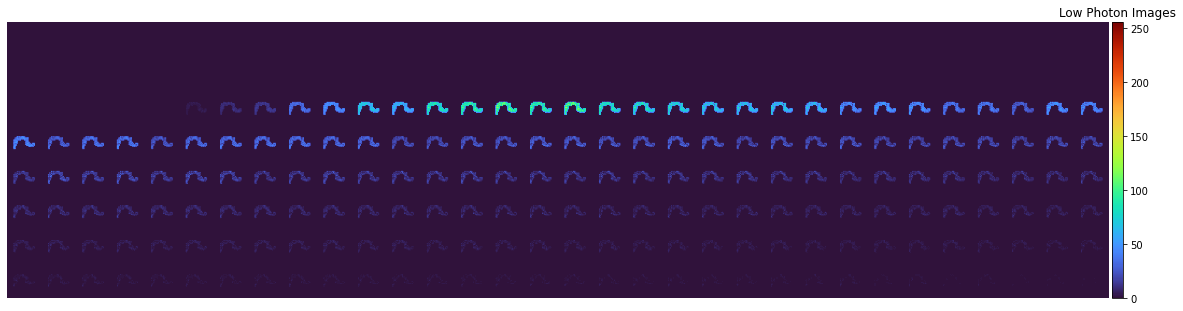

In [33]:
plt.figure(figsize=(20, round(montageGImage.shape[1] / montageGImage.shape[0] * 20)))
# plt.imshow(montageList, cmap='Blues',vmax =50)
plt.axis('off')
ax = plt.gca()
im = ax.imshow(montageGImage, cmap='turbo',vmax = 255, vmin = 0)
    
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.05)
plt.title('Low Photon Images')
plt.colorbar(im, cax=cax)
plt.show()

In [34]:
hImage = padHImage[x,:,:,:]
lImage = padLImage[x,:,:,:]
hImage = hImage.reshape(32,32,256)
lImage = lImage.reshape(32,32,256)



montageHImage = resize_image(hImage)
montageLImage = resize_image(lImage)

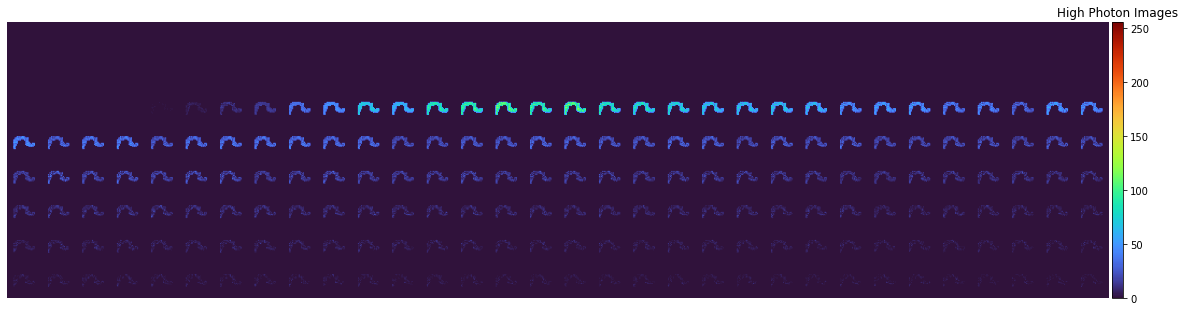

In [35]:
plt.figure(figsize=(20, round(montageHImage.shape[1] / montageHImage.shape[0] * 20)))
# plt.imshow(montageList, cmap='Blues',vmax =50)
plt.axis('off')
ax = plt.gca()
im = ax.imshow(montageHImage, cmap='turbo',vmax = 255)
    
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.05)
plt.title('High Photon Images')
plt.colorbar(im, cax=cax)
plt.show()

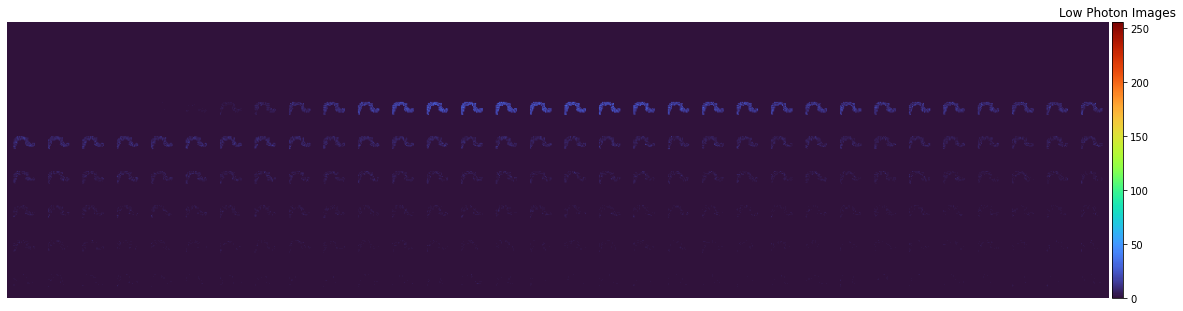

In [36]:
plt.figure(figsize=(20, round(montageLImage.shape[1] / montageLImage.shape[0] * 20)))
# plt.imshow(montageList, cmap='Blues',vmax =50)
plt.axis('off')
ax = plt.gca()
im = ax.imshow(montageLImage, cmap='turbo',vmax = 255)
    
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.05)
plt.title('Low Photon Images')
plt.colorbar(im, cax=cax)
plt.show()

In [37]:
predictDecay = np.sum(np.sum(generatedImage,axis = 0),axis = 0)
lDecay = np.sum(np.sum(lImage,axis = 0),axis = 0)
hDecay = np.sum(np.sum(hImage,axis = 0),axis = 0)

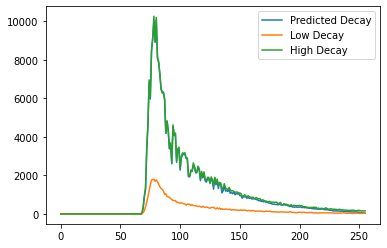

In [38]:
plt.plot(predictDecay,label = 'Predicted Decay')
plt.plot(lDecay, label = 'Low Decay')
plt.plot(hDecay,label = 'High Decay')
plt.legend()
plt.show()

In [34]:
# generate samples and save as a plot and save the model
#GAN models do not converge, we just want to find a good balance between
#the generator and the discriminator. Therefore, it makes sense to periodically
#save the generator model and check how good the generated image looks. 
def summarize_performance(step, g_model, dataset, n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + i)
		plt.axis('off')
		plt.imshow(X_realA[i])
	# plot generated target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples + i)
		plt.axis('off')
		plt.imshow(X_fakeB[i])
	# plot real target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples*2 + i)
		plt.axis('off')
		plt.imshow(X_realB[i])
	# save plot to file
	filename1 = 'plot_%06d.png' % (step+1)
	plt.savefig(filename1)
	plt.close()
	# save the generator model
	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

### Test with a untrained image

In [42]:
dataDirectory = 'E:\\Linghao Hu\\FLIM Enhan\\New Dataset\\Simulate_Dataset'  # Directory with trainging data
imageNumber = 3100
imageStacks = os.listdir(dataDirectory)[3001:imageNumber]
stackNumber = int(len(imageStacks))

timePointNumber = 256 # Number of time-points
width = 28
height = 28



# Build the stack for each endpoint tpsfH, tpsfL, t1, t2, a1, a2

tpsfHImageStack = np.ndarray((stackNumber, int(timePointNumber), int(width), int(height), int(1)), dtype=np.float32)
tpsfLImageStack = np.ndarray((stackNumber, int(timePointNumber), int(width), int(height), int(1)), dtype=np.float32)

i = 0;

for d in imageStacks:
    # Save values to respective stack
    data = h5py.File(os.path.join(dataDirectory,d),'r')
    tpsfHImageStack[i,:,:,:,0] = data.get('hFLIM')
    tpsfLImageStack[i,:,:,:,0] = data.get('lFLIM')
    i = i + 1
    
# change the axis order of the stack 
tpsfHImageStack =  np.moveaxis(tpsfHImageStack, 1, -2)
tpsfLImageStack =  np.moveaxis(tpsfLImageStack, 1, -2)

In [43]:
tpsfHImageStack = np.squeeze(tpsfHImageStack)
tpsfLImageStack = np.squeeze(tpsfLImageStack)
padHImage = padTPSFImage((imageNumber,32,32,256),tpsfHImageStack)
padLImage = padTPSFImage((imageNumber,32,32,256),tpsfLImageStack)

In [51]:
x = 80
inputImage = padLImage[x,:,:]
inputImage = (inputImage-127.5)/127.5
inputImage = inputImage.reshape(1,32,32,256)
generatedImage = g_model.predict(inputImage)

1/1 [==============================] - 0s 279ms/step


In [52]:
generatedImage = generatedImage * 127.5 +127.5
generatedImage = generatedImage.astype(int)
generatedImage = generatedImage.reshape(32,32,256)
montageGImage = resize_image(generatedImage)

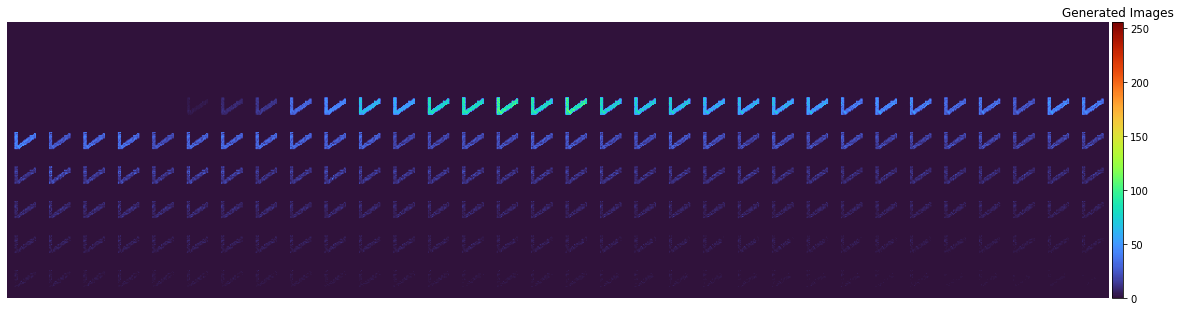

In [53]:
plt.figure(figsize=(20, round(montageGImage.shape[1] / montageGImage.shape[0] * 20)))
# plt.imshow(montageList, cmap='Blues',vmax =50)
plt.axis('off')
ax = plt.gca()
im = ax.imshow(montageGImage, cmap='turbo',vmax = 255, vmin = 0)
    
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.05)
plt.title('Generated Images')
plt.colorbar(im, cax=cax)
plt.show()

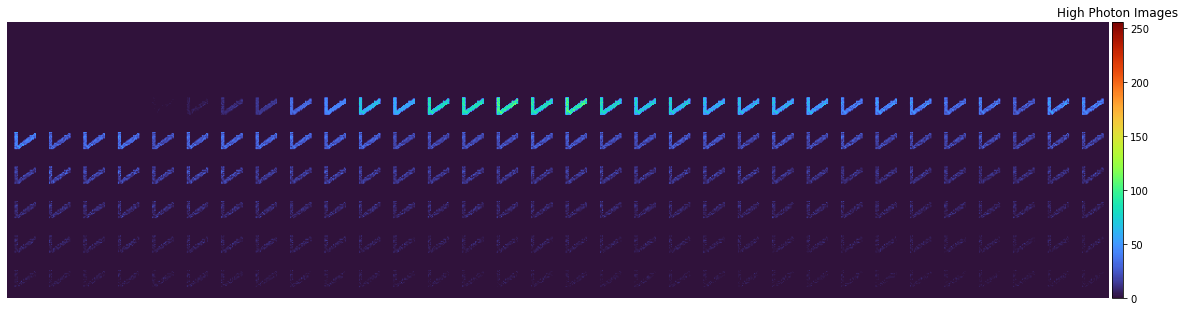

In [54]:
hImage = padHImage[x,:,:,:]
lImage = padLImage[x,:,:,:]
hImage = hImage.reshape(32,32,256)
lImage = lImage.reshape(32,32,256)
montageHImage = resize_image(hImage)
montageLImage = resize_image(lImage)
plt.figure(figsize=(20, round(montageHImage.shape[1] / montageHImage.shape[0] * 20)))
# plt.imshow(montageList, cmap='Blues',vmax =50)
plt.axis('off')
ax = plt.gca()
im = ax.imshow(montageHImage, cmap='turbo',vmax = 255)
    
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.05)
plt.title('High Photon Images')
plt.colorbar(im, cax=cax)
plt.show()

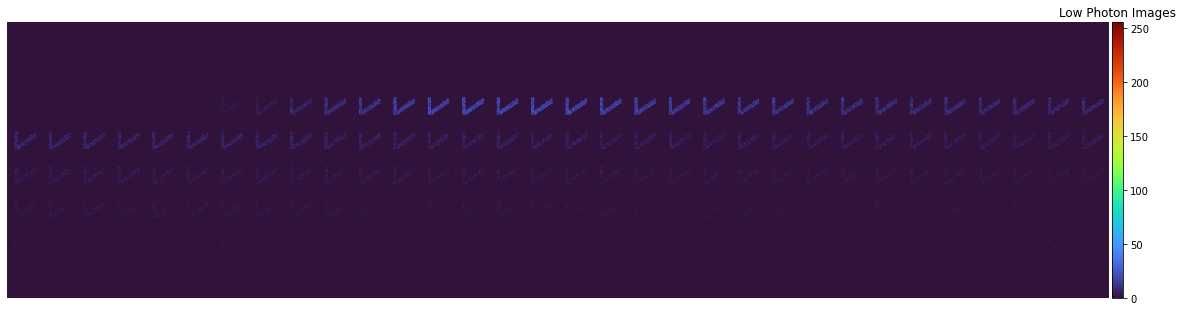

In [55]:
plt.figure(figsize=(20, round(montageLImage.shape[1] / montageLImage.shape[0] * 20)))
# plt.imshow(montageList, cmap='Blues',vmax =50)
plt.axis('off')
ax = plt.gca()
im = ax.imshow(montageLImage, cmap='turbo',vmax = 255)
    
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.05)
plt.title('Low Photon Images')
plt.colorbar(im, cax=cax)
plt.show()

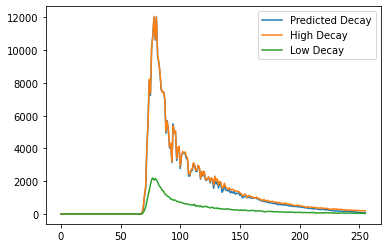

In [57]:
predictDecay = np.sum(np.sum(generatedImage,axis = 0),axis = 0)
lDecay = np.sum(np.sum(lImage,axis = 0),axis = 0)
hDecay = np.sum(np.sum(hImage,axis = 0),axis = 0)
plt.plot(predictDecay,label = 'Predicted Decay')
plt.plot(hDecay,label = 'High Decay')
plt.plot(lDecay, label = 'Low Decay')
plt.legend()
plt.show()